# Methods for Data Science: Coursework 2

# Grade: 113/125 

<img src="https://github.com/yanismiraoui/yanismiraoui.github.io/blob/master/static/media/yanis_greeting.c3fdd1ec.png?raw=true" width="200px"/>

##### My personal portfolio: https://yanismiraoui.github.io/#/

##### Email: yanis.miraoui19@imperial.ac.uk

### CID: 01731821

Throughout this second coursework, we will investigate how to use different advanced methods to analyse data. It will contain 3 different tasks and we will use only the following libraries:

In [1]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.sparse import linalg
from scipy.stats import multivariate_normal
from matplotlib.patches import Ellipse

# Library for progress bar (use 'pip install tqdm' to install)
from tqdm.notebook import tqdm

# Set seed for reproducibility
np.random.seed(1731821) # Seed chosen is my CID number

## Task 1: Neural Networks, Dimensionality Reduction and Mixture Models (65 marks)

In this task, our goal is to explore how a neural network can be used to perform modelling and how we can perform dimensionality reduction on a set of images from the MNIST dataset. We will also explore the effect of the number of hidden units in the neural network on the clustering performance. We will also use the reduced representation to perform a mixture model clustering of the images.

#### 1.1 Multi-Layer Perceptron (MLP) (25 marks)  

1.1.1

> We first load the data and proceed to some preprocessing such as standardization and one-hot encoding of the labels.

In [2]:
def loading_data():
    """
    This function loads the training and testing dataof Task 1 from the csv files.

    Returns:
    train_data: pandas dataframe 
        The training data.
    noisy_train_data: pandas dataframe 
        The noisy training data.
    test_data: pandas dataframe
        The testing data.
    noisy_test_data: pandas dataframe
        The noisy testing data.
    """
    # Load training data
    train_data = pd.read_csv('MNIST_train.csv')
    noisy_train_data = pd.read_csv('MNIST_train_noisy.txt', sep='\t')
    # Load testing data
    test_data = pd.read_csv('MNIST_test.csv')
    noisy_test_data = pd.read_csv('MNIST_test_noisy.txt', sep='\t')
    return train_data, noisy_train_data, test_data, noisy_test_data

train_data, noisy_train_data, test_data, noisy_test_data = loading_data()

In [3]:
def standardise(X):
    """
    This function standardises the data.

    Parameters:
    X: numpy array 
        The data to be standardised.
    
    Returns:
    X_modified: numpy array 
        The standardised data.
    """
    mean = np.mean(X, axis=0)
    std = np.std(X, axis=0)
    std_full = std.copy()
    std_full[std==0] = 1.
    X_modified = ((X-mean)/std_full)
    return X_modified, mean , std_full

In [4]:
# Load training data
X_train = train_data.iloc[:,1:].values
y_train = train_data.iloc[:,0].values
# To make the labels one-hot encoded
y_train = np.eye(10)[y_train]
# Load testing data
X_test = test_data.iloc[:,1:].values
y_test = test_data.iloc[:,0].values
# Make the labels one-hot encoded (using the identity)
y_test = np.eye(10)[y_test]
# Keep unstardardised data for plotting
X_train_unstd = X_train.copy()
X_test_unstd = X_test.copy()
# Standardize train and test sets (best way according to this forum post: https://edstem.org/us/courses/31518/discussion/2786023)
X_train, mean_train, std_train = standardise(X_train)
X_test, mean_test, std_test = standardise(X_test)
print("Shapes of the training and testing sets:")
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

Shapes of the training and testing sets:
(6000, 784) (6000, 10) (1000, 784) (1000, 10)


We first analyse how to implement a multi-layer perceptron with an input layer, 3 hidden layers of 200 neurons each and an output layer with 10 neurons. We will use the softplus function as the activation function for the hidden layers and the softmax function for the output layer. We will use the KL divergence loss function and the SGD optimiser.

The images are 28x28 pixels and which we flatten to a vector of 784 elements. We will use 6000 images for training and 1000 images for testing. We have used the ```np.eye``` function to create a one-hot encoding of the labels.

> The softplus activation function should be used between all layers. The softplus function is defined as f(x) = ln(1 + exp(x)). It has a smooth, non-linear shape that is commonly used in neural networks as an alternative to the popular ReLU (rectified linear unit) function.

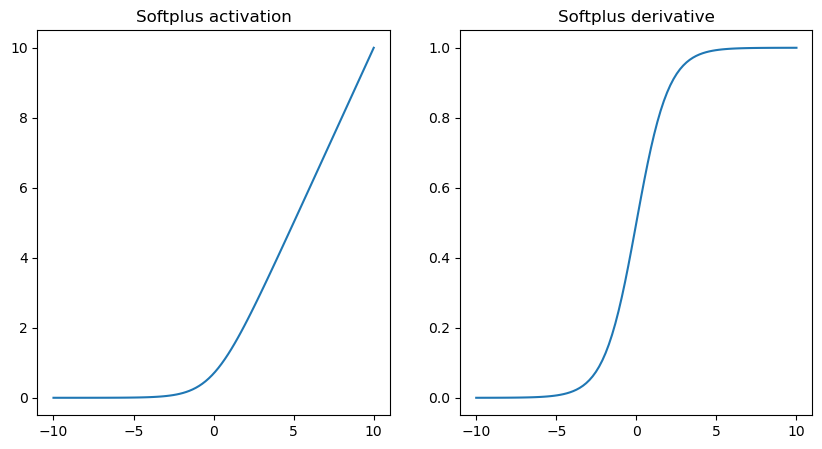

In [5]:
# Softplus activation plot and its derivative as subplots
def softplus(x):
    return np.log(1 + np.exp(x))

def softplus_derivative(x):
    return 1/(1 + np.exp(-x))

x = np.linspace(-10, 10, 100)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
ax1.plot(x, softplus(x))
ax1.set_title('Softplus activation')
ax2.plot(x, softplus_derivative(x))
ax2.set_title('Softplus derivative')
plt.show()

>The output layer should use the softmax activation function, which is commonly used for multi-class classification problems. The softmax function takes a vector of arbitrary real-valued scores as input and transforms it into a probability distribution over the output classes, with each element of the vector representing the predicted probability of the corresponding class.

> The optimisation method used in this task is stochastic gradient descent (SGD), which is a commonly used method for training neural networks. The loss function is defined as the KL divergence, which measures the dissimilarity between the predicted probability distribution and the true probability distribution over the classes. In other words, it measures how different 2 distributions are to each other.

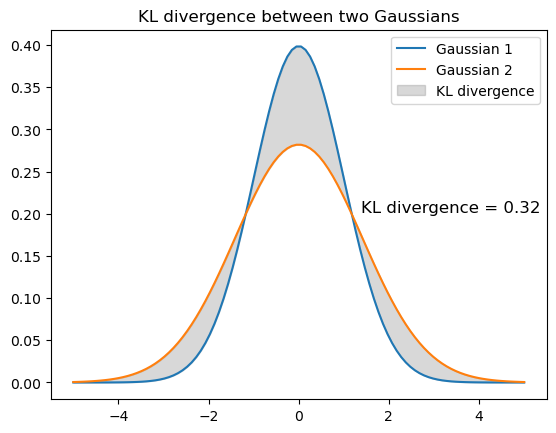

In [6]:
# KL divergence example plot (with the two Gaussians)
def KL_divergence_example(mu1, mu2, sigma1, sigma2):
    kl_div = np.log(sigma2/sigma1) + (sigma1**2 + (mu1-mu2)**2)/(2*sigma2**2) - 0.5
    return kl_div

# Plot the two Gaussians
x = np.linspace(-5, 5, 100)
mu1, sigma1 = 0, 1
mu2, sigma2 = 0, 2
plt.plot(x, multivariate_normal.pdf(x, mean=mu1, cov=sigma1), label='Gaussian 1')
plt.plot(x, multivariate_normal.pdf(x, mean=mu2, cov=sigma2), label='Gaussian 2')
# Add the KL divergence
kl_div = KL_divergence_example(mu1, mu2, sigma1, sigma2)
plt.text(0.61, 0.5, 'KL divergence = {:.2f}'.format(kl_div), fontsize=12, transform=plt.gcf().transFigure)
# Color the area between the two Gaussians
plt.fill_between(x, multivariate_normal.pdf(x, mean=mu1, cov=sigma1), multivariate_normal.pdf(x, mean=mu2, cov=sigma2), color='grey', alpha=0.3, label='KL divergence')
plt.legend()
plt.title('KL divergence between two Gaussians')
plt.show()

To implement the MLP using NumPy, we need to define the weight matrices and bias vectors for each layer, as well as the activation function and loss function. In this case, we are using the softplus activation function between all layers and the softmax function on the output layer. We are also using stochastic gradient descent (SGD) as the optimization method and defining the loss function as the KL divergence.

To train the MLP on batches of 128 data points for 40 epochs, we can loop over the training set and divide it into batches of size 128. For each batch, we can compute the forward pass through the network to obtain the output, and then compute the loss using the KL divergence. We can then compute the gradients of the loss with respect to the weights and biases using backpropagation.

Step by step in more details: to train the neural network, we will randomly divide the data into smaller sets called minibatches. For each minibatch, we will input it into the neural network and calculate the loss function. Then, we will update the weights and biases of the network based on the gradient of the KL divergence loss function with respect to each weight and bias. This is done using a technique called stochastic gradient descent, where the weights are updated by scaling the gradients with the learning rate. This process is repeated for every minibatch in the dataset and once for the entire dataset in each epoch.

For each learning rate value in the range of 10^-5 to 10^-1, we can train the network and record the final loss achieved. We can then plot the final loss as a function of the learning rate and use this plot to determine the optimal learning rate value. The trend we could expect to observe in the plot is that the loss will decrease as the learning rate increases, up to a certain point where the learning rate becomes too large and the loss begins to increase again (due to the weights and biases overshooting the optimal values). The optimal learning rate value will be the point at which the loss is minimized.

In [7]:
# Define the main activation functions and their derivatives
def softmax(y):
    """
    Softmax function

    Parameters:
    y : numpy array
        The input to the softmax function
    
    Returns:
    softmax : numpy array
        The output of the softmax function
    """
    softmax = np.exp(y - np.max(y, axis=1, keepdims=True))
    softmax = softmax / np.sum(softmax, axis=1, keepdims=True)
    return softmax

def KL_divergence(softmax, target):
    """
    KL divergence function

    Parameters:
    softmax : numpy array
        The output of the softmax function
    target : numpy array
        The target labels
    
    Returns:
    KL_divergence : numpy array
        The output of the KL divergence function
    """
    tolerance = 1e-8
    softmax = np.clip(softmax, tolerance, 1) # to avoid numerical issues
    return -np.log(softmax[target==1])

def derivative_KL_divergence_softmax(y, target):
    """
    Gradient of the KL divergence function with respect to the softmax function

    Parameters:
    y : numpy array
        The input to the softmax function
    target : numpy array
        The target labels
    
    Returns:
    grad_softmax : numpy array
        The gradient of the KL divergence function with respect to the softmax function
    """
    softmax = np.exp(y - np.max(y, axis=1, keepdims=True))
    softmax = softmax / np.sum(softmax, axis=1, keepdims=True)
    return (softmax - target)/ softmax.shape[0]

In [8]:
# Function that produces the mini batches for our training
def minibatches(x, targets, batchsize, shuffle=False):
    """
    This function produces the mini batches for our training.

    Parameters:
    x: numpy array 
        The data.
    targets: numpy array
        The target labels.
    batchsize: int
        The size of the mini batch.
    shuffle: boolean
        Whether to shuffle the data or not.
    
    Returns:
    extract: numpy array
        The mini batch.
    """
    if shuffle:
        # Shuffle the data
        indices = np.random.permutation(len(x))
    for start_idx in range(0, len(x) - batchsize + 1, batchsize):
        # Produce the mini batches
        if shuffle:
            clip = indices[start_idx:start_idx + batchsize]
        else:
            clip = slice(start_idx, start_idx + batchsize)
        # Yield the mini batches
        yield x[clip], targets[clip]

In [9]:
class Hidden_Layer:
    """
    This class defines the hidden layer of our MLP.
    """
    def forward(self, x):
        return x

    def backward(self, x, grad):
        n = x.shape[1]
        layer = np.eye(n)
        return grad @ layer
    
class Softplus(Hidden_Layer):
    """
    This class defines the softplus activation function.
    """
    def forward(self, x):
        return np.log1p(np.exp(-np.abs(x))) + np.maximum(x, 0)

    def backward(self, x, grad):
        return 1/(1 + np.exp(-x))*grad

class Dense(Hidden_Layer):
    """
    This class defines the dense layer of our MLP.
    """
    def __init__(self, input, output, lr=0.1):
        self.lr = lr
        self.weights = np.random.randn(input, output) * np.sqrt(2./(input + output))
        self.biases = np.zeros(output)

    def forward(self, x):
        # Forward pass
        return x @ self.weights + self.biases

    def backward(self, x, grad):
        # Backward pass
        grad_x = grad@self.weights.T
        grad_weights = x.T @ grad
        grad_biases = grad.mean(axis=0)*x.shape[0]

        # Update the weights and biases
        self.weights -= self.lr * grad_weights
        self.biases -= self.lr * grad_biases
        return grad_x

class MLP:
    """
    This class defines the MLP.
    """
    def __init__(self):
        self.mlp = []

    def build_mlp(self, input_shape=784, output_shape=10, width=200, lr=0.01):
        # Add the layers to the MLP model according to the exercise guidelines
        self.mlp.append(Dense(input_shape, width, lr))
        self.mlp.append(Softplus())
        self.mlp.append(Dense(width, width, lr))
        self.mlp.append(Softplus())
        self.mlp.append(Dense(width, width, lr))
        self.mlp.append(Softplus())
        self.mlp.append(Dense(width, output_shape, lr))

    def forward(self, X, return_activation=False):
        activations = []
        for i, layer in enumerate(self.mlp):
            activations.append(layer.forward(X))
            X = activations[-1]
            if return_activation and i == 1:
                # Return the activation of the first hidden layer for visualization in exercise 1.1.4
                return activations[-1]
        return activations

    def predict(self, X):
        preds = self.forward(X)[-1]
        return np.argmax(preds, axis=-1)

    def train(self, X, y):
        # Forward pass
        layer_activations = self.forward(X)
        layer_inputs = [X]+layer_activations
        softmax_probs = layer_activations[-1]
        
        # Compute the loss and the gradient of the loss with respect to the softmax function
        loss = KL_divergence(softmax(softmax_probs), y)
        loss_grad = derivative_KL_divergence_softmax(softmax_probs, y)
        
        for layer_idx in range(len(self.mlp))[::-1]:
            layer = self.mlp[layer_idx]
            loss_grad = layer.backward(layer_inputs[layer_idx], loss_grad)
        return np.mean(loss)

    def fit(self, X_train, y_train, X_test, y_test, epochs=40, lr=0.01, width=200, verbose=True):
        train_acc = []
        test_acc = []
        train_loss = []
        test_loss = []

        # Build the MLP
        self.build_mlp(input_shape=X_train.shape[1], lr=lr, width=width)

        # Train the MLP
        for epoch in tqdm(range(1, epochs+1)): # Using tqdm to show the progress bar
            loss = []
            # Iterate over the mini batches
            for X_batch, y_batch in minibatches(X_train, y_train, batchsize=128, shuffle=True):
                loss.append(self.train(X_batch, y_batch))
            
            # Compute the loss on test set
            layer_activations = self.forward(X_train)
            softmax_probs = layer_activations[-1]
            train_loss.append(np.mean(KL_divergence(softmax(softmax_probs), y_train)))
            layer_activations = self.forward(X_test)
            softmax_probs = layer_activations[-1]
            test_loss.append(np.mean(KL_divergence(softmax(softmax_probs), y_test)))
            train_acc.append(np.mean(self.predict(X_train) == np.argmax(y_train, axis=1)))
            test_acc.append(np.mean(self.predict(X_test) == np.argmax(y_test, axis=1)))
            if verbose:
                if epoch % 5 == 0:
                    # Print the loss and accuracy every 5 epochs as indicated in a forum post: https://edstem.org/us/courses/31518/discussion/2817651
                    print("Epoch: {}, Train Loss: {:.03}, Train Acc: {:.03}, Test Loss: {:.03}, Test Acc: {:.03}".format(epoch, train_loss[-1], train_acc[-1], test_loss[-1], test_acc[-1]))
        return train_acc, test_acc, train_loss, test_loss

In [10]:
# Testing our MLP class with a defined learning rate and number of epochs
mlp = MLP()
train_acc, test_acc, train_loss, test_loss = mlp.fit(X_train, y_train, X_test, y_test, epochs=40, lr=0.1)

  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 5, Train Loss: 0.224, Train Acc: 0.93, Test Loss: 0.292, Test Acc: 0.907
Epoch: 10, Train Loss: 0.113, Train Acc: 0.967, Test Loss: 0.248, Test Acc: 0.93
Epoch: 15, Train Loss: 0.0614, Train Acc: 0.984, Test Loss: 0.269, Test Acc: 0.937
Epoch: 20, Train Loss: 0.0278, Train Acc: 0.995, Test Loss: 0.282, Test Acc: 0.933
Epoch: 25, Train Loss: 0.0318, Train Acc: 0.99, Test Loss: 0.307, Test Acc: 0.932
Epoch: 30, Train Loss: 0.00705, Train Acc: 1.0, Test Loss: 0.32, Test Acc: 0.934
Epoch: 35, Train Loss: 0.0104, Train Acc: 1.0, Test Loss: 0.309, Test Acc: 0.936
Epoch: 40, Train Loss: 0.00479, Train Acc: 1.0, Test Loss: 0.34, Test Acc: 0.936


Training MLP with learning rate: 1e-05


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 5, Train Loss: 2.84, Train Acc: 0.0668, Test Loss: 2.85, Test Acc: 0.058
Epoch: 10, Train Loss: 2.78, Train Acc: 0.0642, Test Loss: 2.79, Test Acc: 0.059
Epoch: 15, Train Loss: 2.73, Train Acc: 0.0635, Test Loss: 2.74, Test Acc: 0.056
Epoch: 20, Train Loss: 2.68, Train Acc: 0.0633, Test Loss: 2.69, Test Acc: 0.057
Epoch: 25, Train Loss: 2.64, Train Acc: 0.063, Test Loss: 2.65, Test Acc: 0.057
Epoch: 30, Train Loss: 2.61, Train Acc: 0.0623, Test Loss: 2.62, Test Acc: 0.056
Epoch: 35, Train Loss: 2.58, Train Acc: 0.0632, Test Loss: 2.59, Test Acc: 0.054
Epoch: 40, Train Loss: 2.55, Train Acc: 0.0623, Test Loss: 2.56, Test Acc: 0.055
Training MLP with learning rate: 0.0001


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 5, Train Loss: 2.38, Train Acc: 0.113, Test Loss: 2.38, Test Acc: 0.107
Epoch: 10, Train Loss: 2.31, Train Acc: 0.118, Test Loss: 2.31, Test Acc: 0.112
Epoch: 15, Train Loss: 2.28, Train Acc: 0.127, Test Loss: 2.28, Test Acc: 0.126
Epoch: 20, Train Loss: 2.25, Train Acc: 0.15, Test Loss: 2.25, Test Acc: 0.148
Epoch: 25, Train Loss: 2.24, Train Acc: 0.175, Test Loss: 2.24, Test Acc: 0.176
Epoch: 30, Train Loss: 2.22, Train Acc: 0.194, Test Loss: 2.22, Test Acc: 0.204
Epoch: 35, Train Loss: 2.21, Train Acc: 0.217, Test Loss: 2.21, Test Acc: 0.229
Epoch: 40, Train Loss: 2.2, Train Acc: 0.237, Test Loss: 2.2, Test Acc: 0.249
Training MLP with learning rate: 0.001


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 5, Train Loss: 2.17, Train Acc: 0.255, Test Loss: 2.18, Test Acc: 0.264
Epoch: 10, Train Loss: 2.01, Train Acc: 0.438, Test Loss: 2.02, Test Acc: 0.463
Epoch: 15, Train Loss: 1.84, Train Acc: 0.553, Test Loss: 1.85, Test Acc: 0.552
Epoch: 20, Train Loss: 1.67, Train Acc: 0.614, Test Loss: 1.68, Test Acc: 0.616
Epoch: 25, Train Loss: 1.49, Train Acc: 0.663, Test Loss: 1.5, Test Acc: 0.667
Epoch: 30, Train Loss: 1.32, Train Acc: 0.7, Test Loss: 1.33, Test Acc: 0.706
Epoch: 35, Train Loss: 1.17, Train Acc: 0.735, Test Loss: 1.18, Test Acc: 0.746
Epoch: 40, Train Loss: 1.03, Train Acc: 0.763, Test Loss: 1.04, Test Acc: 0.77
Training MLP with learning rate: 0.01


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 5, Train Loss: 0.872, Train Acc: 0.803, Test Loss: 0.87, Test Acc: 0.813
Epoch: 10, Train Loss: 0.464, Train Acc: 0.873, Test Loss: 0.48, Test Acc: 0.874
Epoch: 15, Train Loss: 0.353, Train Acc: 0.898, Test Loss: 0.382, Test Acc: 0.904
Epoch: 20, Train Loss: 0.303, Train Acc: 0.908, Test Loss: 0.346, Test Acc: 0.908
Epoch: 25, Train Loss: 0.254, Train Acc: 0.927, Test Loss: 0.305, Test Acc: 0.913
Epoch: 30, Train Loss: 0.227, Train Acc: 0.936, Test Loss: 0.289, Test Acc: 0.922
Epoch: 35, Train Loss: 0.204, Train Acc: 0.941, Test Loss: 0.28, Test Acc: 0.92
Epoch: 40, Train Loss: 0.185, Train Acc: 0.948, Test Loss: 0.267, Test Acc: 0.919
Training MLP with learning rate: 0.1


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 5, Train Loss: 0.216, Train Acc: 0.933, Test Loss: 0.279, Test Acc: 0.914
Epoch: 10, Train Loss: 0.11, Train Acc: 0.97, Test Loss: 0.24, Test Acc: 0.926
Epoch: 15, Train Loss: 0.0518, Train Acc: 0.987, Test Loss: 0.227, Test Acc: 0.938
Epoch: 20, Train Loss: 0.025, Train Acc: 0.996, Test Loss: 0.255, Test Acc: 0.94
Epoch: 25, Train Loss: 0.0171, Train Acc: 0.998, Test Loss: 0.252, Test Acc: 0.942
Epoch: 30, Train Loss: 0.00733, Train Acc: 1.0, Test Loss: 0.278, Test Acc: 0.939
Epoch: 35, Train Loss: 0.00456, Train Acc: 1.0, Test Loss: 0.3, Test Acc: 0.935
Epoch: 40, Train Loss: 0.00281, Train Acc: 1.0, Test Loss: 0.312, Test Acc: 0.937


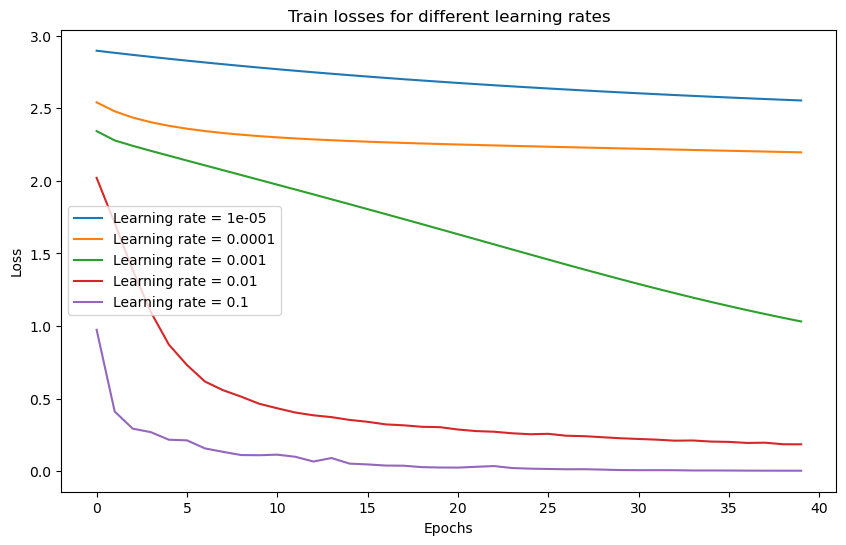

In [11]:
# Train for different learning rates between 10^-5 and 10^-1
learning_rates = [0.00001, 0.0001, 0.001, 0.01, 0.1]
losses = []
test_losses = []
for learning_rate in learning_rates:
    print('Training MLP with learning rate: {}'.format(learning_rate))
    mlp = MLP()
    train_acc, test_acc, train_loss, test_loss = mlp.fit(X_train, y_train, X_test, y_test, epochs=40, lr=learning_rate)
    losses.append(train_loss)
    test_losses.append(test_loss)

# Plot the losses for different learning rates
plt.figure(figsize=(10, 6))
for i in range(len(learning_rates)):
    plt.plot(losses[i], label = 'Learning rate = ' + str(learning_rates[i]))
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Train losses for different learning rates')
plt.show()


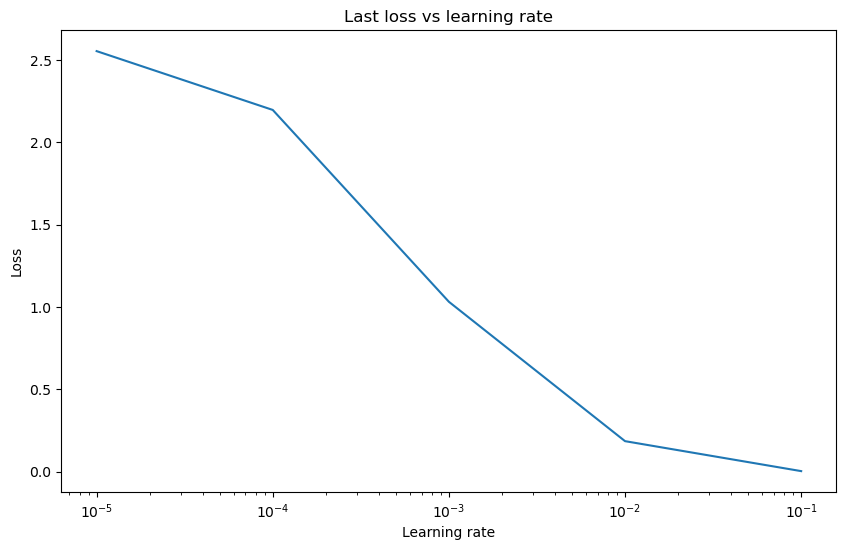

In [12]:
# Plot the last training loss vs learning rate
plt.figure(figsize=(10, 6))
plt.plot(learning_rates, [losses[i][-1] for i in range(len(learning_rates))])
plt.xscale('log')
plt.xlabel('Learning rate')
plt.ylabel('Loss')
plt.title('Last loss vs learning rate')
plt.show()

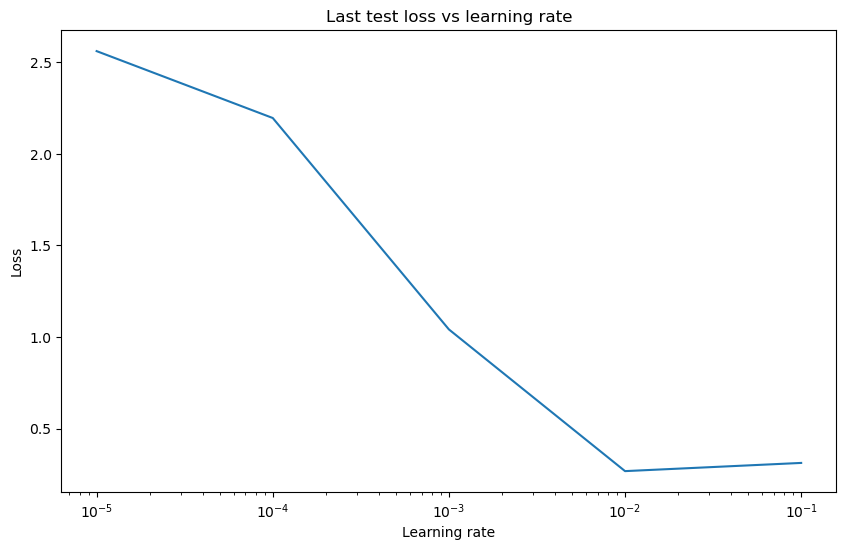

In [13]:
# Plot the last test loss vs learning rate
plt.figure(figsize=(10, 6))
plt.plot(learning_rates, [test_losses[i][-1] for i in range(len(learning_rates))])
plt.xscale('log')
plt.xlabel('Learning rate')
plt.ylabel('Loss')
plt.title('Last test loss vs learning rate')
plt.show()

Training MLP with learning rate: 0.01


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 5, Train Loss: 0.902, Train Acc: 0.795, Test Loss: 0.918, Test Acc: 0.797
Epoch: 10, Train Loss: 0.49, Train Acc: 0.867, Test Loss: 0.512, Test Acc: 0.864
Epoch: 15, Train Loss: 0.367, Train Acc: 0.898, Test Loss: 0.397, Test Acc: 0.893
Epoch: 20, Train Loss: 0.303, Train Acc: 0.912, Test Loss: 0.342, Test Acc: 0.895
Epoch: 25, Train Loss: 0.268, Train Acc: 0.921, Test Loss: 0.32, Test Acc: 0.9
Epoch: 30, Train Loss: 0.237, Train Acc: 0.928, Test Loss: 0.303, Test Acc: 0.907
Epoch: 35, Train Loss: 0.212, Train Acc: 0.939, Test Loss: 0.288, Test Acc: 0.916
Epoch: 40, Train Loss: 0.191, Train Acc: 0.944, Test Loss: 0.28, Test Acc: 0.916
Training MLP with learning rate: 0.0325


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 5, Train Loss: 0.342, Train Acc: 0.905, Test Loss: 0.368, Test Acc: 0.894
Epoch: 10, Train Loss: 0.228, Train Acc: 0.929, Test Loss: 0.285, Test Acc: 0.916
Epoch: 15, Train Loss: 0.17, Train Acc: 0.95, Test Loss: 0.26, Test Acc: 0.925
Epoch: 20, Train Loss: 0.125, Train Acc: 0.965, Test Loss: 0.248, Test Acc: 0.927
Epoch: 25, Train Loss: 0.0916, Train Acc: 0.977, Test Loss: 0.248, Test Acc: 0.931
Epoch: 30, Train Loss: 0.0769, Train Acc: 0.978, Test Loss: 0.256, Test Acc: 0.929
Epoch: 35, Train Loss: 0.0565, Train Acc: 0.988, Test Loss: 0.263, Test Acc: 0.93
Epoch: 40, Train Loss: 0.0409, Train Acc: 0.993, Test Loss: 0.27, Test Acc: 0.931
Training MLP with learning rate: 0.05500000000000001


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 5, Train Loss: 0.285, Train Acc: 0.912, Test Loss: 0.325, Test Acc: 0.911
Epoch: 10, Train Loss: 0.17, Train Acc: 0.949, Test Loss: 0.265, Test Acc: 0.922
Epoch: 15, Train Loss: 0.11, Train Acc: 0.968, Test Loss: 0.254, Test Acc: 0.925
Epoch: 20, Train Loss: 0.0811, Train Acc: 0.979, Test Loss: 0.269, Test Acc: 0.926
Epoch: 25, Train Loss: 0.0456, Train Acc: 0.99, Test Loss: 0.267, Test Acc: 0.93
Epoch: 30, Train Loss: 0.0327, Train Acc: 0.993, Test Loss: 0.28, Test Acc: 0.934
Epoch: 35, Train Loss: 0.0187, Train Acc: 0.998, Test Loss: 0.293, Test Acc: 0.933
Epoch: 40, Train Loss: 0.0149, Train Acc: 0.997, Test Loss: 0.314, Test Acc: 0.935
Training MLP with learning rate: 0.0775


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 5, Train Loss: 0.259, Train Acc: 0.917, Test Loss: 0.316, Test Acc: 0.901
Epoch: 10, Train Loss: 0.12, Train Acc: 0.966, Test Loss: 0.241, Test Acc: 0.926
Epoch: 15, Train Loss: 0.0824, Train Acc: 0.978, Test Loss: 0.258, Test Acc: 0.927
Epoch: 20, Train Loss: 0.0411, Train Acc: 0.992, Test Loss: 0.249, Test Acc: 0.934
Epoch: 25, Train Loss: 0.0235, Train Acc: 0.996, Test Loss: 0.264, Test Acc: 0.939
Epoch: 30, Train Loss: 0.0127, Train Acc: 0.998, Test Loss: 0.286, Test Acc: 0.939
Epoch: 35, Train Loss: 0.0103, Train Acc: 0.999, Test Loss: 0.301, Test Acc: 0.938
Epoch: 40, Train Loss: 0.00478, Train Acc: 1.0, Test Loss: 0.307, Test Acc: 0.939
Training MLP with learning rate: 0.1


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 5, Train Loss: 0.213, Train Acc: 0.933, Test Loss: 0.277, Test Acc: 0.918
Epoch: 10, Train Loss: 0.142, Train Acc: 0.95, Test Loss: 0.281, Test Acc: 0.918
Epoch: 15, Train Loss: 0.0713, Train Acc: 0.977, Test Loss: 0.263, Test Acc: 0.93
Epoch: 20, Train Loss: 0.0264, Train Acc: 0.996, Test Loss: 0.252, Test Acc: 0.933
Epoch: 25, Train Loss: 0.0276, Train Acc: 0.994, Test Loss: 0.287, Test Acc: 0.935
Epoch: 30, Train Loss: 0.00784, Train Acc: 0.999, Test Loss: 0.28, Test Acc: 0.934
Epoch: 35, Train Loss: 0.0041, Train Acc: 1.0, Test Loss: 0.289, Test Acc: 0.934
Epoch: 40, Train Loss: 0.0025, Train Acc: 1.0, Test Loss: 0.301, Test Acc: 0.936


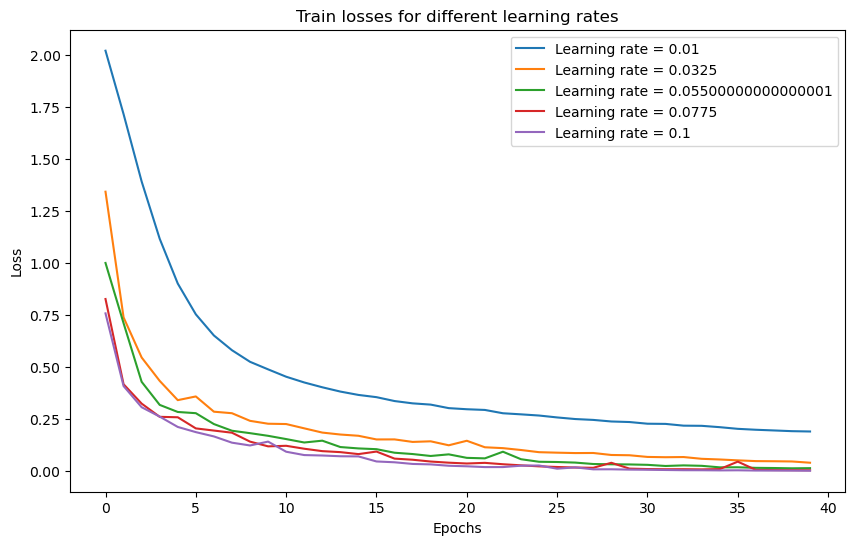

In [14]:
# Train for different learning rates between 10^-2 and 10^-1 for additional precision as indicated in this forum post: https://edstem.org/us/courses/31518/discussion/2823113
learning_rates = np.linspace(0.01, 0.1, 5)
losses = []
test_losses = []
for learning_rate in learning_rates:
    print('Training MLP with learning rate: {}'.format(learning_rate))
    mlp = MLP()
    train_acc, test_acc, train_loss, test_loss = mlp.fit(X_train, y_train, X_test, y_test, epochs=40, lr=learning_rate)
    losses.append(train_loss)
    test_losses.append(test_loss)

# Plot the losses for different learning rates
plt.figure(figsize=(10, 6))
for i in range(len(learning_rates)):
    plt.plot(losses[i], label = 'Learning rate = ' + str(learning_rates[i]))
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Train losses for different learning rates')
plt.show()


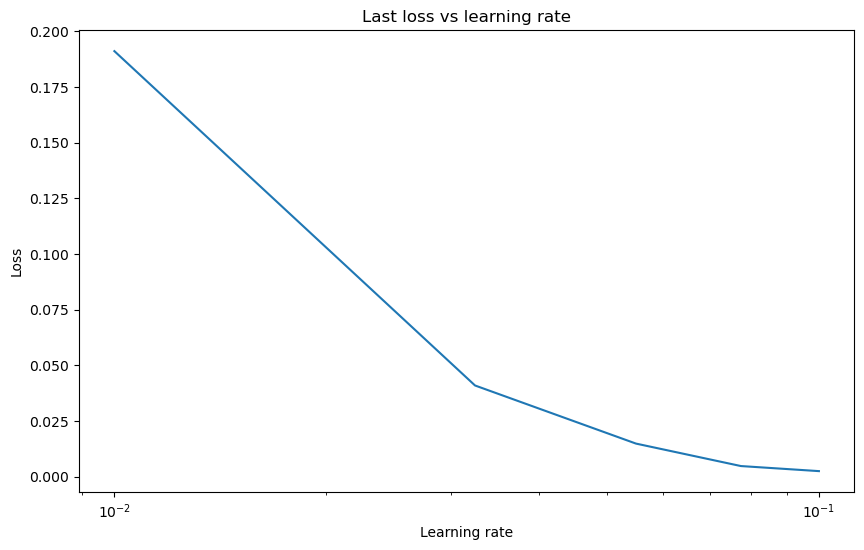

In [15]:
# Plot the last training loss vs learning rate
plt.figure(figsize=(10, 6))
plt.plot(learning_rates, [losses[i][-1] for i in range(len(learning_rates))])
plt.xscale('log')
plt.xlabel('Learning rate')
plt.ylabel('Loss')
plt.title('Last loss vs learning rate')
plt.show()

In [16]:
# Define optimal learning rate as the one with the lowest training loss
optimal_lr = learning_rates[np.argmin([losses[i][-1] for i in range(len(learning_rates))])]
print("Optimal learning rate: {}".format(optimal_lr))

Optimal learning rate: 0.1


> Note we have chosen the optimal learning rate based only on the training loss achieved as indicated in this edStem forum post: https://edstem.org/us/courses/31518/discussion/2803478. 
> We were not able to find a U-shape behaviour and as we are limited to a range of learning rates between 10^-5 and 10^-1, we have chosen the learning rate that gives the lowest training loss.

As expected, we observe in the plot that the loss decreases as the learning rate increases. As we are restricted to a range of 10^-5 to 10^-1, we can see that the optimal learning rate is around 10^-1. Therefore, we proceeded to a second analysis with a range of 10^-2 to 10^-1. Similarly, we still observed that the optimal learning rate is around 10^-1.

1.1.2

In this exercise, we aim to retrain the MLP using the determined the optimal learning rate from the previous step. We can use the same batch size of 128 and number of epochs of 40 as before. During training, we can record the loss and accuracy of the MLP for both the training and test sets after each epoch.

In [17]:
# Train the MLP with the optimal learning rate
print(f"Training the MLP with the optimal learning rate: {optimal_lr}")
mlp = MLP()
train_acc, test_acc, train_loss, test_loss = mlp.fit(X_train, y_train, X_test, y_test, epochs=40, lr=optimal_lr)

Training the MLP with the optimal learning rate: 0.1


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 5, Train Loss: 0.238, Train Acc: 0.925, Test Loss: 0.293, Test Acc: 0.908
Epoch: 10, Train Loss: 0.104, Train Acc: 0.968, Test Loss: 0.238, Test Acc: 0.93
Epoch: 15, Train Loss: 0.0517, Train Acc: 0.988, Test Loss: 0.229, Test Acc: 0.938
Epoch: 20, Train Loss: 0.0993, Train Acc: 0.964, Test Loss: 0.368, Test Acc: 0.903
Epoch: 25, Train Loss: 0.0168, Train Acc: 0.997, Test Loss: 0.255, Test Acc: 0.936
Epoch: 30, Train Loss: 0.00787, Train Acc: 0.999, Test Loss: 0.275, Test Acc: 0.937
Epoch: 35, Train Loss: 0.00401, Train Acc: 1.0, Test Loss: 0.29, Test Acc: 0.938
Epoch: 40, Train Loss: 0.00255, Train Acc: 1.0, Test Loss: 0.293, Test Acc: 0.939


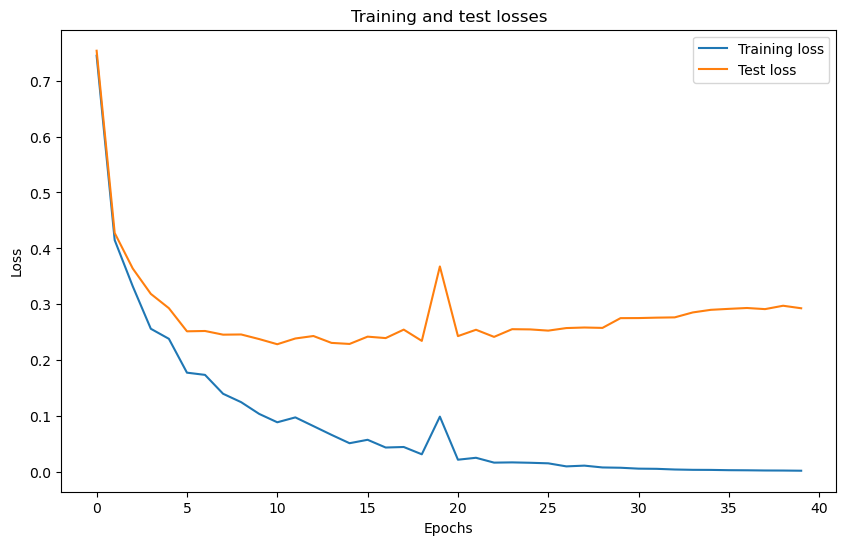

In [18]:
# Plot the training and test losses
plt.figure(figsize=(10, 6))
plt.plot(train_loss, label = 'Training loss')
plt.plot(test_loss, label = 'Test loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and test losses')
plt.show()

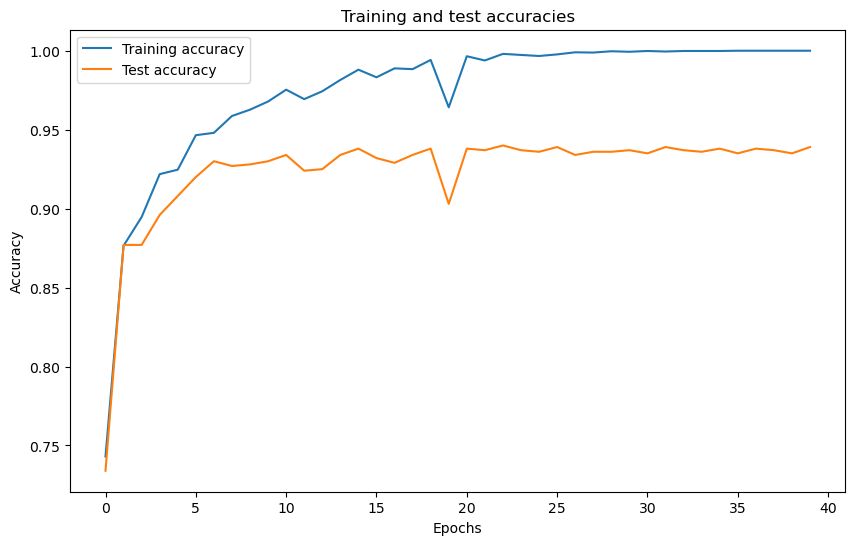

In [19]:
# Plot the training and test accuracies
plt.figure(figsize=(10, 6))
plt.plot(train_acc, label = 'Training accuracy')
plt.plot(test_acc, label = 'Test accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and test accuracies')
plt.show()

We have retrained our MLP using the optimal learning rate of 10^-1. We can see that the loss decreases as the number of epochs increases, and that the accuracy increases as the number of epochs increases. We can also see that the loss of the test set is higher than the one of the training set, which is expected as the model is being trained on the training set and is not being trained on the test set. Similarly, the accuracy of the test set is lower than the one of the training set.

Overall, we still achieve a high accuracy of around 92.5% on the test set, which is a good result. We could still argue that we are overfitting the training set as the loss of the training set is much lower than the one of the test set and as the accuracy of the training set is much higher than the one of the test set (very close to 100%).

1.1.3

In this section, we want to retrain our MLP using hidden layers with only 50 neurons. We can use the same batch size of 128 and number of epochs of 40 as before. During training, we can record the loss and accuracy of the MLP for both the training and test sets after each epoch. This will allow us to compare the performance of the MLP with 200 neurons in the hidden layers to the performance of the MLP with 50 neurons in the hidden layers.

In [20]:
# Retraining the MLP model with a width of 50 neurons
mlp = MLP()
train_acc, test_acc, train_loss, test_loss = mlp.fit(X_train, y_train, X_test, y_test, epochs=40, lr=0.1, width=50)

  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 5, Train Loss: 0.22, Train Acc: 0.934, Test Loss: 0.279, Test Acc: 0.923
Epoch: 10, Train Loss: 0.11, Train Acc: 0.965, Test Loss: 0.24, Test Acc: 0.926
Epoch: 15, Train Loss: 0.046, Train Acc: 0.99, Test Loss: 0.253, Test Acc: 0.941
Epoch: 20, Train Loss: 0.0274, Train Acc: 0.995, Test Loss: 0.292, Test Acc: 0.939
Epoch: 25, Train Loss: 0.0112, Train Acc: 0.999, Test Loss: 0.299, Test Acc: 0.939
Epoch: 30, Train Loss: 0.00547, Train Acc: 1.0, Test Loss: 0.307, Test Acc: 0.94
Epoch: 35, Train Loss: 0.0036, Train Acc: 1.0, Test Loss: 0.32, Test Acc: 0.94
Epoch: 40, Train Loss: 0.00254, Train Acc: 1.0, Test Loss: 0.332, Test Acc: 0.94


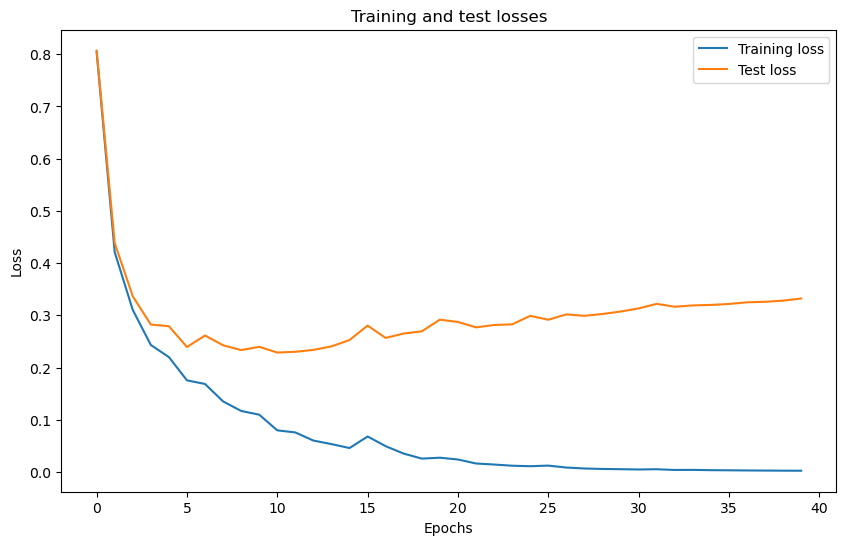

In [21]:
# Plot the training and test losses
plt.figure(figsize=(10, 6))
plt.plot(train_loss, label = 'Training loss')
plt.plot(test_loss, label = 'Test loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and test losses')
plt.show()

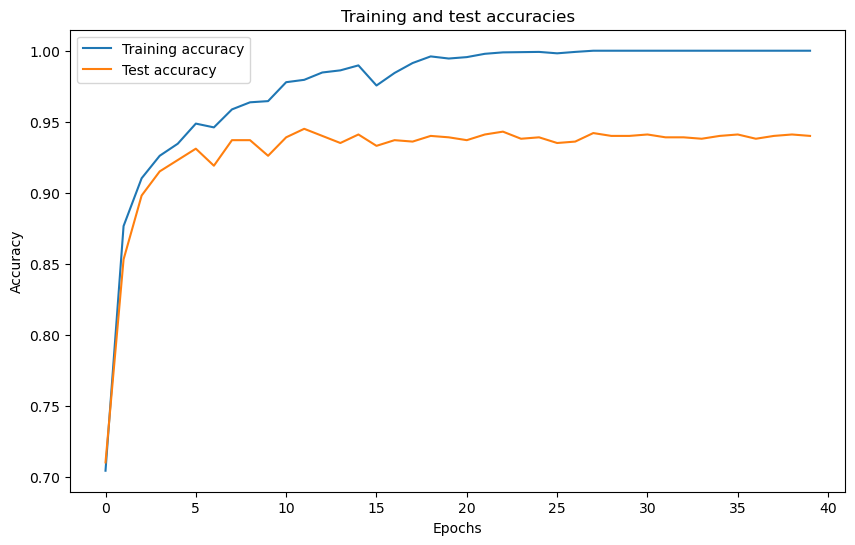

In [22]:
# Plot the training and test accuracies
plt.figure(figsize=(10, 6))
plt.plot(train_acc, label = 'Training accuracy')
plt.plot(test_acc, label = 'Test accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and test accuracies')
plt.show()

Training the MLP with a width of 50 neurons


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 5, Train Loss: 0.205, Train Acc: 0.94, Test Loss: 0.28, Test Acc: 0.923
Epoch: 10, Train Loss: 0.103, Train Acc: 0.971, Test Loss: 0.254, Test Acc: 0.929
Epoch: 15, Train Loss: 0.0481, Train Acc: 0.99, Test Loss: 0.272, Test Acc: 0.933
Epoch: 20, Train Loss: 0.0368, Train Acc: 0.99, Test Loss: 0.315, Test Acc: 0.93
Epoch: 25, Train Loss: 0.0118, Train Acc: 0.998, Test Loss: 0.322, Test Acc: 0.939
Epoch: 30, Train Loss: 0.00659, Train Acc: 1.0, Test Loss: 0.344, Test Acc: 0.936
Epoch: 35, Train Loss: 0.00364, Train Acc: 1.0, Test Loss: 0.357, Test Acc: 0.937
Epoch: 40, Train Loss: 0.00255, Train Acc: 1.0, Test Loss: 0.368, Test Acc: 0.936
Training the MLP with a width of 200 neurons


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 5, Train Loss: 0.221, Train Acc: 0.934, Test Loss: 0.275, Test Acc: 0.918
Epoch: 10, Train Loss: 0.119, Train Acc: 0.964, Test Loss: 0.241, Test Acc: 0.94
Epoch: 15, Train Loss: 0.0964, Train Acc: 0.965, Test Loss: 0.276, Test Acc: 0.926
Epoch: 20, Train Loss: 0.0272, Train Acc: 0.996, Test Loss: 0.259, Test Acc: 0.935
Epoch: 25, Train Loss: 0.0156, Train Acc: 0.998, Test Loss: 0.274, Test Acc: 0.938
Epoch: 30, Train Loss: 0.00698, Train Acc: 0.999, Test Loss: 0.3, Test Acc: 0.934
Epoch: 35, Train Loss: 0.00471, Train Acc: 1.0, Test Loss: 0.311, Test Acc: 0.933
Epoch: 40, Train Loss: 0.00263, Train Acc: 1.0, Test Loss: 0.321, Test Acc: 0.936


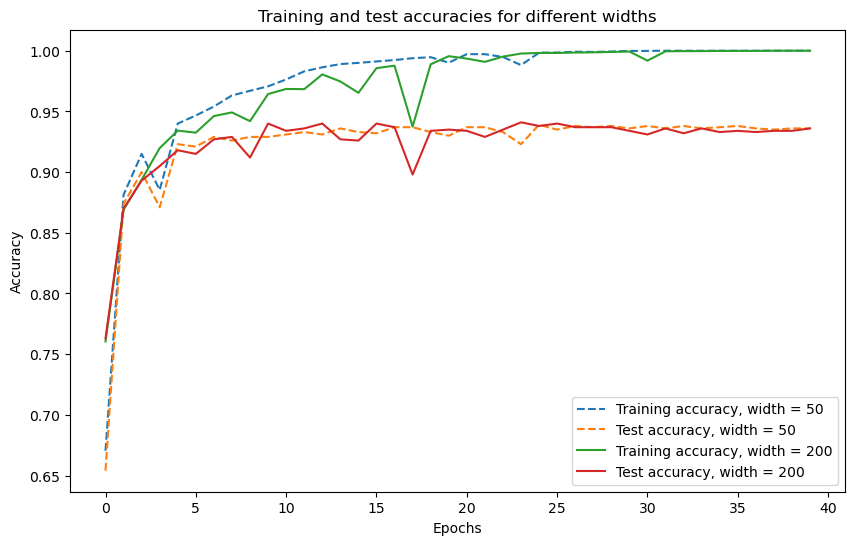

In [23]:
# Compare the training and test accuracies for different widths
widths = [50, 200]
train_accs = []
test_accs = []
for width in widths:
    # Retraining the MLP model with a width of 50 neurons
    print(f"Training the MLP with a width of {width} neurons")
    mlp = MLP()
    train_acc, test_acc, train_loss, test_loss = mlp.fit(X_train, y_train, X_test, y_test, epochs=40, lr=0.1, width=width)
    # Append the accuracies
    train_accs.append(train_acc)
    test_accs.append(test_acc)

# Plot the training and test accuracies for different widths
plt.figure(figsize=(10, 6))
for i in range(len(widths)):
    if i == 0:
        # Plot dashed lines for the width of 50
        plt.plot(train_accs[i], label = 'Training accuracy, width = ' + str(widths[i]), linestyle='dashed')
        plt.plot(test_accs[i], label = 'Test accuracy, width = ' + str(widths[i]), linestyle='dashed')
    else:
        # Plot solid lines for the width of 200
        plt.plot(train_accs[i], label = 'Training accuracy, width = ' + str(widths[i]))
        plt.plot(test_accs[i], label = 'Test accuracy, width = ' + str(widths[i]))
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and test accuracies for different widths')
plt.show()

After retraining the MLP with a reduced width of the hidden layers to 50 neurons, we evaluate the accuracy on both the training and test sets. Then, we compare it to the accuracies of the MLP from task 1.1.2.

We notice from our comparison that it seems that in the first epochs the model with 50 neurons in the hidden layers has a better training and test accuracies than the model with 200 neurons in the hidden layers. However, after a few epochs, the model with 200 neurons in the hidden layers performs better than the model with 50 neurons in the hidden layers. This is probably due to the fact that the model with 200 neurons in the hidden layers has more parameters to learn and therefore is able to learn more complex patterns in the data.

We can explain this by the fact that the model with smaller width has less parameters to learn and therefore is likely to learn simpler patterns in the data faster. On the other hand, the model with larger width has more parameters to learn and therefore is likely to learn more complex patterns in the data but it would require more epochs.

The comparison of the accuracies between the two models provides insight into whether the reduction in width has a significant effect on the performance of the network. If the drop in accuracy was too significant, it may have not be worth reducing the width of the hidden layers. However, in our case the drop in accuracy is minimal, it may be more efficient to use a smaller network architecture to save computational resources. Indeed, both models perform similarly well, with an accuracy of around 92.5% on the test set.

1.1.4

In this question, we introduce dropout regularization to the MLP from task 1.1.2. Dropout is a regularization technique that randomly drops out (i.e., set to zero) a fraction of the neurons in a layer during training, which prevents the network from relying too much on any individual neuron and promotes better generalization. We set the dropout rate to 0.2 for each hidden layer and scale the output of each neuron in the hidden layers during training to compensate for the dropout. We then plot the loss and accuracy of the MLP as a function of the number of epochs for both the training and test sets to demonstrate convergence. Note that we use larger learning rates and number of epochs in the presence of dropout.

In [24]:
class Hidden_Layer:
    """
    This class defines the hidden layer of our MLP.
    """
    def forward(self, x):
        return x

    def backward(self, x, grad):
        n = x.shape[1]
        layer_input = np.eye(n)
        return grad @ layer_input
    
class SoftPlus(Hidden_Layer):
    """
    This class defines the softplus activation function.
    """
    def __init__(self):
        self.mask=None

    def forward(self, x):
        # Create a mask of 0.8s and 0.2s
        self.mask = np.random.binomial(1,1-0.2, size=x.shape).astype(bool)/(1-0.2) # Scale the neurons with the denominator
        # Apply the mask on the forward pass
        return (np.log1p(np.exp(-np.abs(x))) + np.maximum(x, 0))*self.mask

    def backward(self, x, grad):
        # Apply the mask on the backward pass
        return 1/(1 + np.exp(-x))*grad*self.mask

class MLP:
    """
    This class defines the MLP.
    """
    def __init__(self):
        self.mlp = []

    def build_mlp(self, input_shape=784, output_shape=10, width=200, lr=0.5):
        self.mlp.append(Dense(input_shape, width, lr=lr))
        self.mlp.append(SoftPlus())
        self.mlp.append(Dense(width, width, lr=lr))
        self.mlp.append(SoftPlus())
        self.mlp.append(Dense(width, width, lr=lr))
        self.mlp.append(SoftPlus())
        self.mlp.append(Dense(width, output_shape, lr=lr))

    def forward(self, X, return_activation=False):
        activations = []
        for i, layer in enumerate(self.mlp):
            activations.append(layer.forward(X))
            X = activations[-1]
            if return_activation and i==1:
                return activations[-1]

        return activations

    def predict(self, X):
        preds = self.forward(X)[-1]
        return np.argmax(preds, axis=-1)

    def train(self, X, y):
        layer_activations = self.forward(X)
        layer_inputs = [X]+layer_activations
        softmax_probs = layer_activations[-1]

        loss = KL_divergence(softmax(softmax_probs), y)
        loss_grad = derivative_KL_divergence_softmax(softmax_probs, y)

        for layer_idx in range(len(self.mlp))[::-1]:
            layer = self.mlp[layer_idx]
            loss_grad = layer.backward(layer_inputs[layer_idx], loss_grad)
            
        return np.mean(loss)

    def fit(self, X_train, y_train, X_test, y_test, epochs=40, lr=0.01, width=200, verbose=True):
        train_acc = []
        test_acc = []
        train_loss = []
        test_loss = []

        self.build_mlp(input_shape=X_train.shape[1], lr=lr, width=width)

        for epoch in tqdm(range(1, epochs+1)):
            loss = []
            for X_batch,y_batch in minibatches(X_train, y_train, batchsize=128, shuffle=True):
                loss.append(self.train(X_batch, y_batch))
            
            # Compute the loss on validation set
            layer_activations = self.forward(X_train)
            softmax_probs = layer_activations[-1]
            train_loss.append(np.mean(KL_divergence(softmax(softmax_probs), y_train)))
            layer_activations = self.forward(X_test)
            softmax_probs = layer_activations[-1]
            test_loss.append(np.mean(KL_divergence(softmax(softmax_probs), y_test)))
            train_acc.append(np.mean(self.predict(X_train)==np.argmax(y_train, axis=1)))
            test_acc.append(np.mean(self.predict(X_test)==np.argmax(y_test, axis=1)))
            if verbose:
                if epoch % 5 == 0:
                    # Print the loss and accuracy every 5 epochs as indicated in a forum post: https://edstem.org/us/courses/31518/discussion/2817651
                    print("Epoch: {}, Train Loss: {:.03}, Train Acc: {:.03}, Test Loss: {:.03}, Test Acc: {:.03}".format(epoch, train_loss[-1], train_acc[-1], test_loss[-1], test_acc[-1]))

        return train_acc, test_acc, train_loss, test_loss

mlp_dropout = MLP()

In [25]:
train_acc_drop, test_acc_drop, train_loss_drop, test_loss_drop = mlp_dropout.fit(X_train, y_train, X_test, y_test, epochs=200, lr=0.1)

  0%|          | 0/200 [00:00<?, ?it/s]

Epoch: 5, Train Loss: 0.406, Train Acc: 0.873, Test Loss: 0.44, Test Acc: 0.856
Epoch: 10, Train Loss: 0.277, Train Acc: 0.909, Test Loss: 0.344, Test Acc: 0.913
Epoch: 15, Train Loss: 0.224, Train Acc: 0.924, Test Loss: 0.319, Test Acc: 0.907
Epoch: 20, Train Loss: 0.179, Train Acc: 0.943, Test Loss: 0.31, Test Acc: 0.911
Epoch: 25, Train Loss: 0.149, Train Acc: 0.949, Test Loss: 0.325, Test Acc: 0.914
Epoch: 30, Train Loss: 0.136, Train Acc: 0.958, Test Loss: 0.289, Test Acc: 0.922
Epoch: 35, Train Loss: 0.115, Train Acc: 0.961, Test Loss: 0.293, Test Acc: 0.919
Epoch: 40, Train Loss: 0.116, Train Acc: 0.963, Test Loss: 0.302, Test Acc: 0.924
Epoch: 45, Train Loss: 0.0957, Train Acc: 0.965, Test Loss: 0.276, Test Acc: 0.928
Epoch: 50, Train Loss: 0.0876, Train Acc: 0.972, Test Loss: 0.312, Test Acc: 0.933
Epoch: 55, Train Loss: 0.0719, Train Acc: 0.977, Test Loss: 0.283, Test Acc: 0.935
Epoch: 60, Train Loss: 0.0729, Train Acc: 0.975, Test Loss: 0.288, Test Acc: 0.927
Epoch: 65, Trai

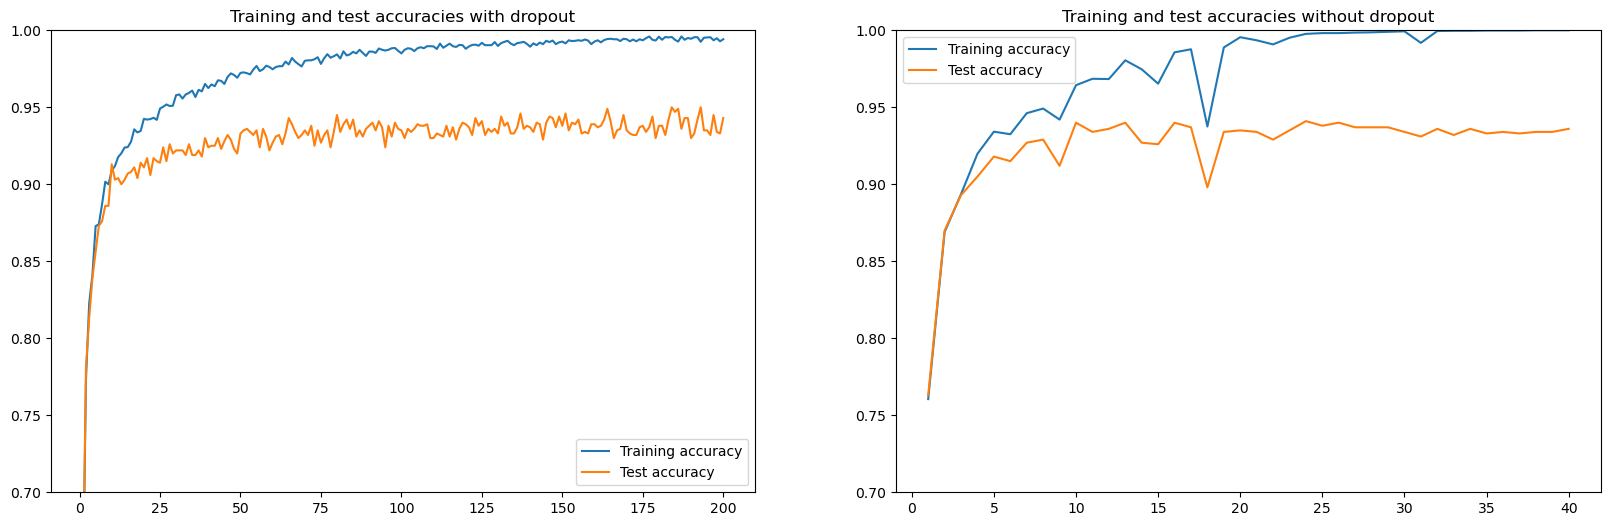

In [26]:
fig = plt.figure(figsize=(20, 6))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

ax1.plot(np.arange(1,201), train_acc_drop,label="Training accuracy")
ax1.plot(np.arange(1,201), test_acc_drop,label="Test accuracy")
ax1.set_title("Training and test accuracies with dropout")
ax1.set_ylim(0.7,1)
ax1.legend()

ax2.plot(np.arange(1,41),train_acc,label="Training accuracy")
ax2.plot(np.arange(1,41),test_acc,label="Test accuracy")
ax2.set_title("Training and test accuracies without dropout")
ax2.set_ylim(0.7,1)
ax2.legend()

plt.show()

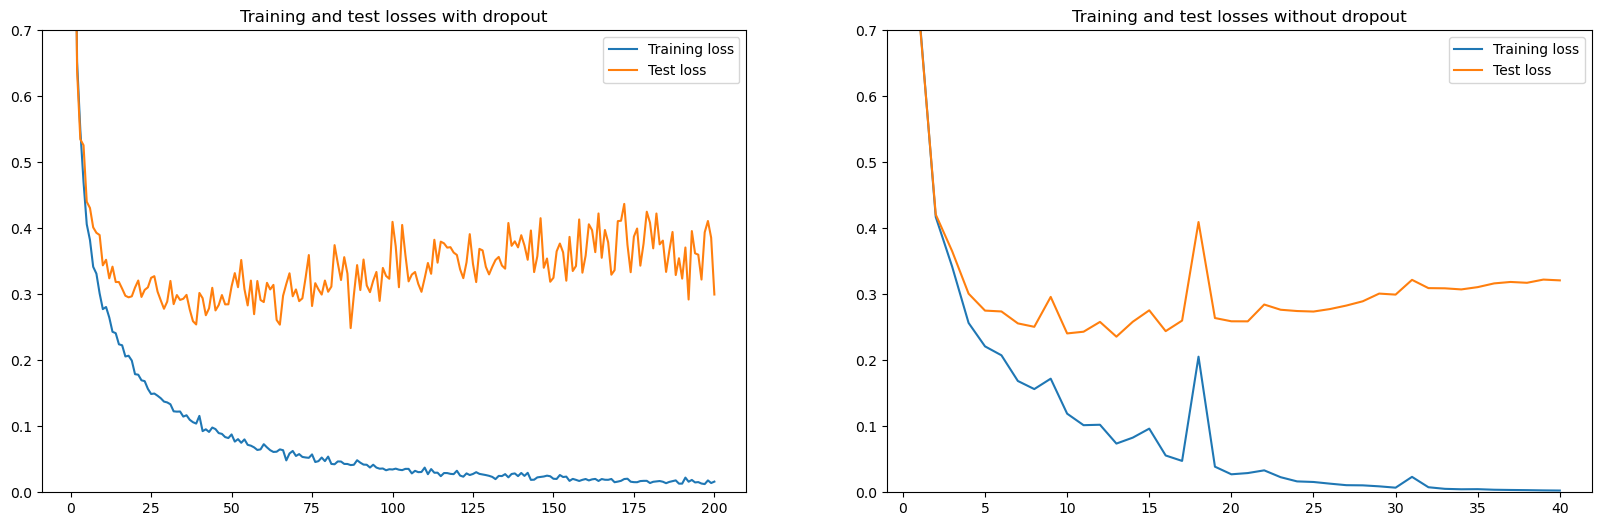

In [27]:
fig = plt.figure(figsize=(20, 6))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

ax1.plot(np.arange(1,201),train_loss_drop,label="Training loss")
ax1.plot(np.arange(1,201),test_loss_drop,label="Test loss")
ax1.set_title("Training and test losses with dropout")
ax1.set_ylim(0,0.7)
ax1.legend()

ax2.plot(np.arange(1,41),train_loss,label="Training loss")
ax2.plot(np.arange(1,41),test_loss,label="Test loss")
ax2.set_title("Training and test losses without dropout")
ax2.set_ylim(0,0.7)
ax2.legend()

plt.show()

> Please note that as indicated in this edStem forum post (https://edstem.org/us/courses/31518/discussion/2737313), we do not have to retrain the MLP without dropout with the same parameters for comparison.

By plotting the train and test accuracies for both the MLP with and without dropout, we notice that the model with dropout has a similar accuracy to the model without dropout. Similarly, both models have a final loss that are very close. 

However, we can also observe that the model with dropout has a higher variance in the accuracy and loss of the test set. This is due to the fact that the dropout is applied randomly during training and therefore the model is not always the same. This is why the accuracy of the test set is not as stable as the one of the training set.

We also produce histograms of the activations of the units in the first hidden layer when the network is evaluated on a batch of our choice of the test data, both for the network with dropout and without dropout (task 1.1.2).

In [28]:
# Batch of my choice
indices = np.random.permutation(len(X_test[1]))[:128]
X_batch = X_test[indices]
y_batch = y_test[indices]


# Compute the activations of the first layer with and without dropout
activations = mlp.forward(X_batch, return_activation=True)
activations_dropout = mlp_dropout.forward(X_batch, return_activation=True)

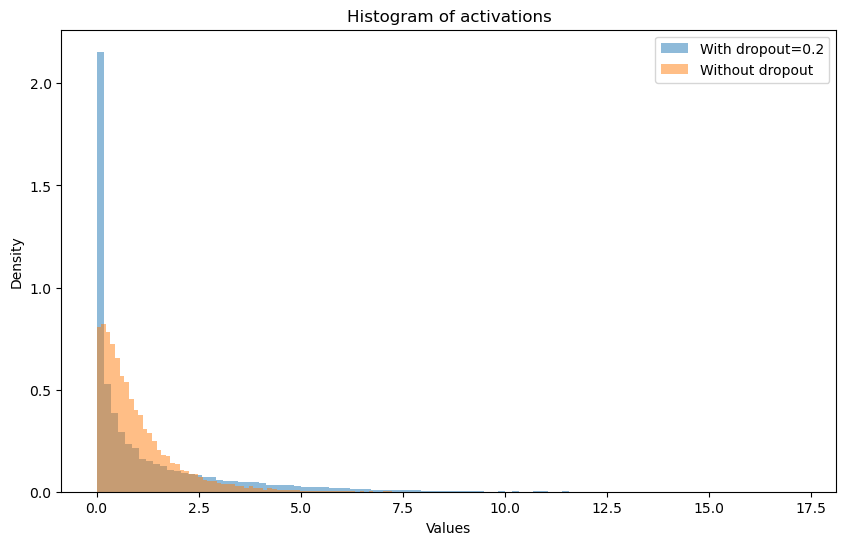

In [29]:
plt.figure(figsize=(10, 6))
plt.hist(activations_dropout.flatten(), density=True, bins=100, alpha=0.5 ,label='With dropout=0.2')
plt.hist(activations.flatten(), density=True, bins=100, alpha=0.5, label='Without dropout')
plt.xlabel('Values')
plt.ylabel('Density')
plt.title('Histogram of activations')
plt.legend()
plt.show()

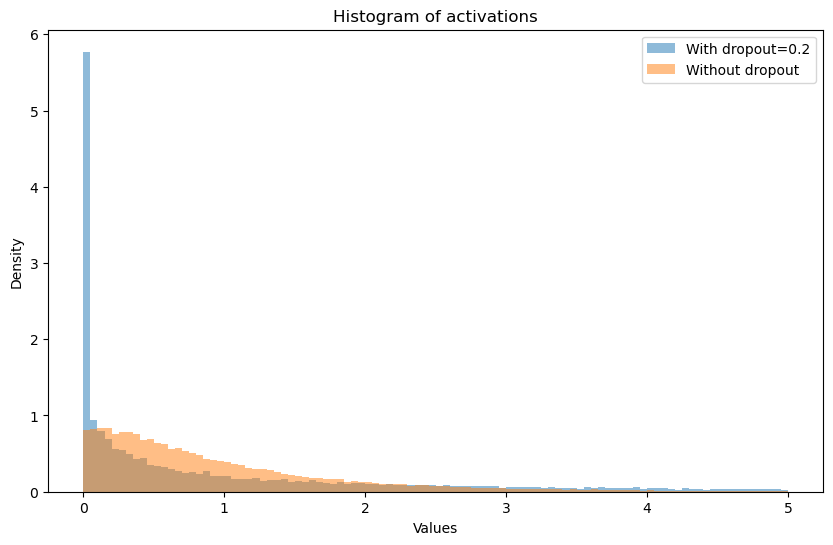

In [30]:
plt.figure(figsize=(10, 6))
plt.hist(activations_dropout.flatten(), density=True, bins=100, alpha=0.5 ,label='With dropout=0.2', range=(0, 5))
plt.hist(activations.flatten(), density=True, bins=100, alpha=0.5, label='Without dropout', range=(0, 5))
plt.xlabel('Values')
plt.ylabel('Density')
plt.title('Histogram of activations')
plt.legend()
plt.show()

The histograms of the activations of the units in the first hidden layer both for the network with dropout and without dropout are quite different. Indeed, the histogram of the activations of the units in the first hidden layer for the network without dropout is quite spread over multiple values. This means that multiple units have been activated and thus, the network is not relying on a single unit. On the other hand, the histogram of the activations of the units in the first hidden layer for the network with dropout contains more values close to 0. This means that the network is relying on less units and that the other units have been dropped out. This is due to the fact that the dropout is applied randomly during training and therefore the model is not always the same.

In theory, the difference of performance between models with and without dropout is due to the fact that the model with dropout is more robust to the noise in the data. Indeed, the dropout is applied randomly during training and therefore the model is not always the same. This is why the accuracy of the test set is not as stable as the one of the training set. Moreover, in theory, the difference between testing and training should be slightly smaller as the presence of dropout by preventing overfitting to particular nodes in the model enables the model the generalise a bit better, however in our case this is hardly visible. However, in our case, the difference of performance between models with and without dropout is minimal. Maybe, by increasing the amount of dropout, we could further minimize the overfitting of our MLP. This would allow us in theory to have a better generalization of our model.

#### 1.2 Dimensionality reduction (20 marks)

1.2.1

In this task, we want to use PCA and NMF to perform image denoising on a version of the MNIST dataset that is corrupted by noise. Before proceeding to our analysis, we first load the data and visualize the corrupted images that we have obtained.

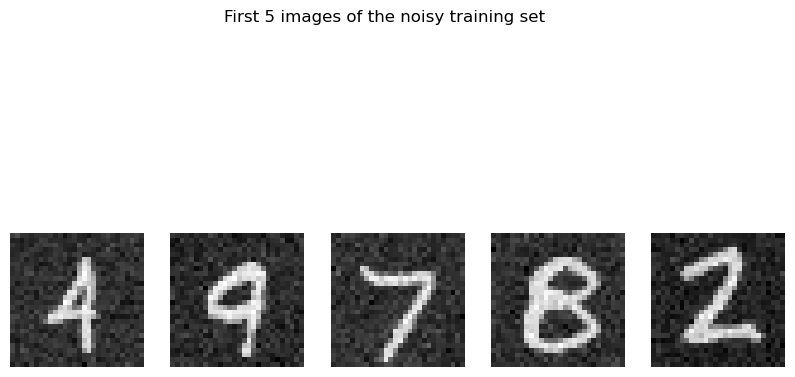

In [31]:
# Load the noisy version of the data
X_train_noisy = np.loadtxt('MNIST_train_noisy.txt')
X_test_noisy = np.loadtxt('MNIST_test_noisy.txt')

# Plot the first 5 images of the noisy training set
plt.figure(figsize=(10, 6))
for i in range(5):
    plt.subplot(1, 5, i+1)
    plt.imshow(X_train_noisy[i].reshape(28,28), cmap='gray')
    plt.axis('off')
plt.suptitle('First 5 images of the noisy training set')
plt.show()

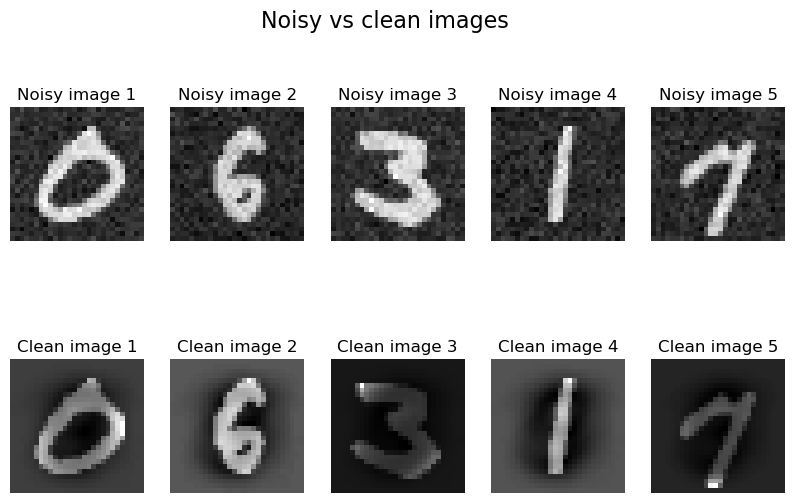

In [32]:
# Plot the first 5 images of the noisy test set along with the corresponding clean images
plt.figure(figsize=(10, 6))
for i in range(5):
    plt.subplot(2, 5, i+1)
    plt.title(f"Noisy image {i+1}")
    plt.imshow(X_test_noisy[i].reshape(28,28), cmap='gray')
    plt.axis('off')
    plt.subplot(2, 5, i+6)
    plt.title(f"Clean image {i+1}")
    plt.imshow(X_test[i].reshape(28,28), cmap='gray')
    plt.axis('off')
plt.suptitle('Noisy vs clean images', fontsize=16)
plt.show()

> We indeed notice that the corrupted images are quite noisy and that the digits are less clear than the original images. 

In [33]:
# Function that standardises the data (extracted from the previous coding tutorials)
def standardise_pca(X):
    """
    This function standardises the data.

    Parameters:
    X: numpy array
        The data to be standardised.

    Returns:
    X_modified: numpy array 
        The standardised data.
    
    """
    mean = np.mean(X, axis=0)
    std = np.std(X, axis=0)
    std_full = std.copy()
    std_full[std==0] = 1.
    X_modified = ((X-mean)/std_full)
    # Return the standardised data and the mean and standard deviation used for standardisation in order to be able to recover the original scale
    return X_modified, mean, std_full

Before proceeding PCA, we first normalize the data. Indeed, normalizing the data is an important step in PCA because it ensures that all the features (in this case, the pixel values of the images) are on the same scale. If the features are not on the same scale, PCA can be skewed towards features with larger magnitudes, which can result in a distorted representation of the data. Thus, we normalize the data by subtracting the mean and dividing by the standard deviation of each feature.

In [34]:
# Standardize the data using the function above
X_train_noisy_std, mean_train, std_train = standardise_pca(X_train_noisy)
X_test_noisy_std, mean_test, std_test = standardise_pca(X_test_noisy)

In [35]:
# Function that computes the PCA (extracted from the previous coding tutorials)
def pca_function(X,k):
    """
    This function computes the PCA.

    Parameters:
    X: numpy array
        The data to be reduced.
    k: int
        The number of principal components to be kept.

    Returns:
    X_pca: numpy array 
        The data projected onto the k principal components.
    eigenvectors: numpy array
        The eigenvectors of the covariance matrix.
    """
    # create covariance matrix C
    C = 1.0/(len(X)-1) * np.dot(X.T, X)

    # compute eigenvalues and eigenvectors using the eigsh scipy function
    eigenvalues, eigenvectors = linalg.eigsh(C, k, which="LM", return_eigenvectors=True) 

    # sorting the eigenvectors and eigenvalues from largest to smallest eigenvalue
    sorted_index = np.argsort(eigenvalues)[::-1]
    eigenvalues = eigenvalues[sorted_index]
    eigenvectors = eigenvectors[:,sorted_index ]

    # transform our data
    X_pca = X.dot(eigenvectors)

    return X_pca, eigenvectors, eigenvalues

In [36]:
# Compute the PCA of the noisy training set
m = X_train_noisy.shape[1]-1
X_train_pca, eigenvectors, eigenvalues = pca_function(X_train_noisy_std, m)
# Redefine C in order to compute the trace
C = 1.0/(len(X_train_noisy_std)-1) * np.dot(X_train_noisy_std.T, X_train_noisy_std)
# Compute the sum of all the eigenvalues (using the trace function)
trace = np.trace(C)

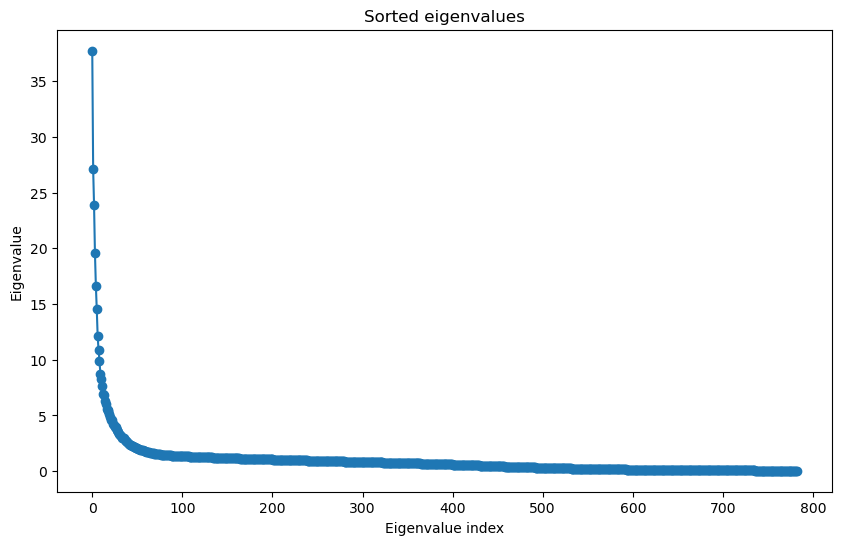

In [37]:
# Plot the eigenvalues sorted in decreasing order
plt.figure(figsize=(10, 6))
plt.plot(eigenvalues, 'o-')
plt.xlabel('Eigenvalue index')
plt.ylabel('Eigenvalue')
plt.title('Sorted eigenvalues')
plt.show()

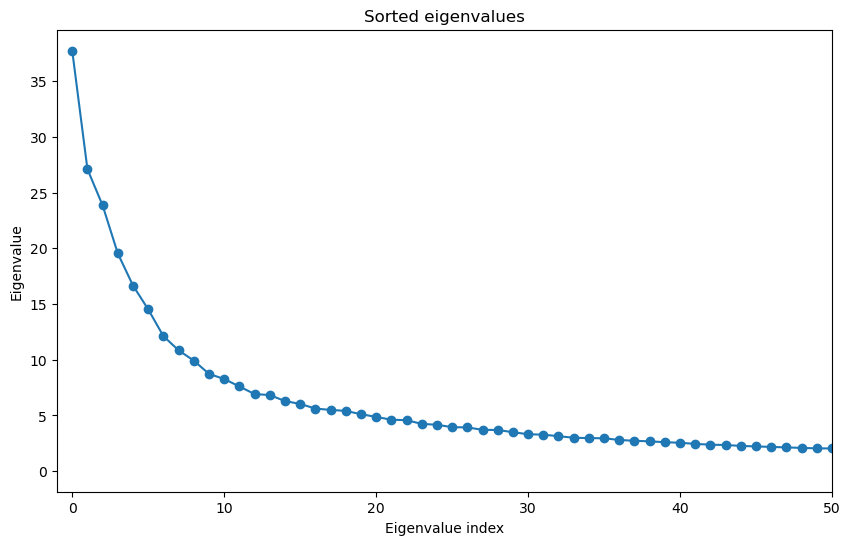

In [38]:
# Plot the first eigenvalues for better visualization
plt.figure(figsize=(10, 6))
plt.plot(eigenvalues, 'o-')
plt.xlabel('Eigenvalue index')
plt.ylabel('Eigenvalue')
plt.xlim(-1, 50)
plt.title('Sorted eigenvalues')
plt.show()

> Now that we have computed the eigenvalues as well as the sum of the eigenvalues, we can compute the explained variance of each principal component. We can also compute the cumulative explained variance of the first k principal components. To compute it the explained variance of each principal component, we simply divide the eigenvalue of each principal component by the sum of the eigenvalues.

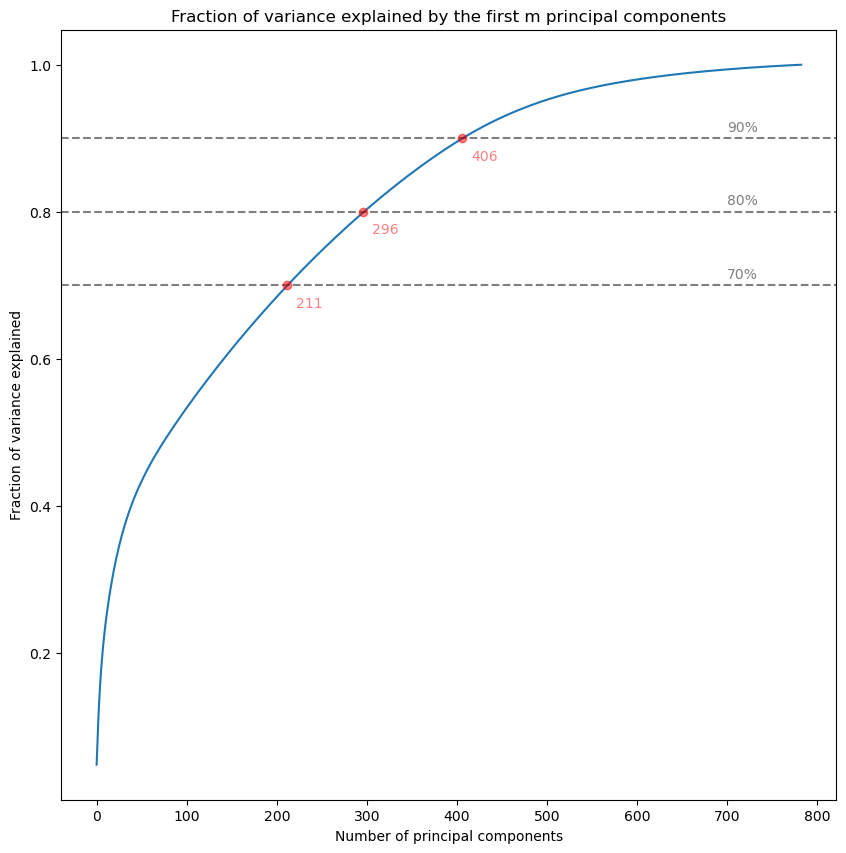

In [39]:
# Compute the number of principal components needed to explain 70%, 80%, and 90% of the variance
m_70 = np.argmax(np.cumsum(eigenvalues)/trace > 0.7)-1
m_80 = np.argmax(np.cumsum(eigenvalues)/trace > 0.8)-1
m_90 = np.argmax(np.cumsum(eigenvalues)/trace > 0.9)-1

# Plot the percentage of variance explained by the first m principal components
plt.figure(figsize=(10, 10))
plt.plot(np.cumsum(eigenvalues)/np.sum(eigenvalues))
plt.xlabel('Number of principal components')
plt.ylabel('Fraction of variance explained')
# Add dotted red lines at 70%, 80%, and 90%
plt.axhline(y=0.7, color='k', linestyle='--', alpha=0.5)
plt.axhline(y=0.8, color='k', linestyle='--', alpha=0.5)
plt.axhline(y=0.9, color='k', linestyle='--', alpha=0.5)
# Add text for the dotted red lines
plt.text(700, 0.71, '70%', color='k', alpha=0.5)
plt.text(700, 0.81, '80%', color='k', alpha=0.5)
plt.text(700, 0.91, '90%', color='k', alpha=0.5)
# Add text for the vertical dotted red lines
plt.text(m_70+10, 0.67, f'{m_70}', color='r', alpha=0.5)
plt.text(m_80+10, 0.77, f'{m_80}', color='r', alpha=0.5)
plt.text(m_90+10, 0.87, f'{m_90}', color='r', alpha=0.5)
# add dot at 70%, 80%, and 90%
plt.plot(m_70, 0.7, 'ro', alpha=0.5)
plt.plot(m_80, 0.8, 'ro', alpha=0.5)
plt.plot(m_90, 0.9, 'ro', alpha=0.5)
plt.title('Fraction of variance explained by the first m principal components')
plt.show()

In [40]:
# Get the number of components that explain 70%, 80%, and 90% of the variance
m_70 = np.argmax(np.cumsum(eigenvalues)/trace > 0.7)
m_80 = np.argmax(np.cumsum(eigenvalues)/trace > 0.8)
m_90 = np.argmax(np.cumsum(eigenvalues)/trace > 0.9)
print('Number of components that explain 70% of the variance: ', m_70+1)
print('Number of components that explain 80% of the variance: ', m_80+1)
print('Number of components that explain 90% of the variance: ', m_90+1)

Number of components that explain 70% of the variance:  213
Number of components that explain 80% of the variance:  298
Number of components that explain 90% of the variance:  408


> Therefore, to explain 70% of the variance, we need 213 principal components. To explain 80% of the variance, we need 298 principal components. To explain 90% of the variance, we need 408 principal components.

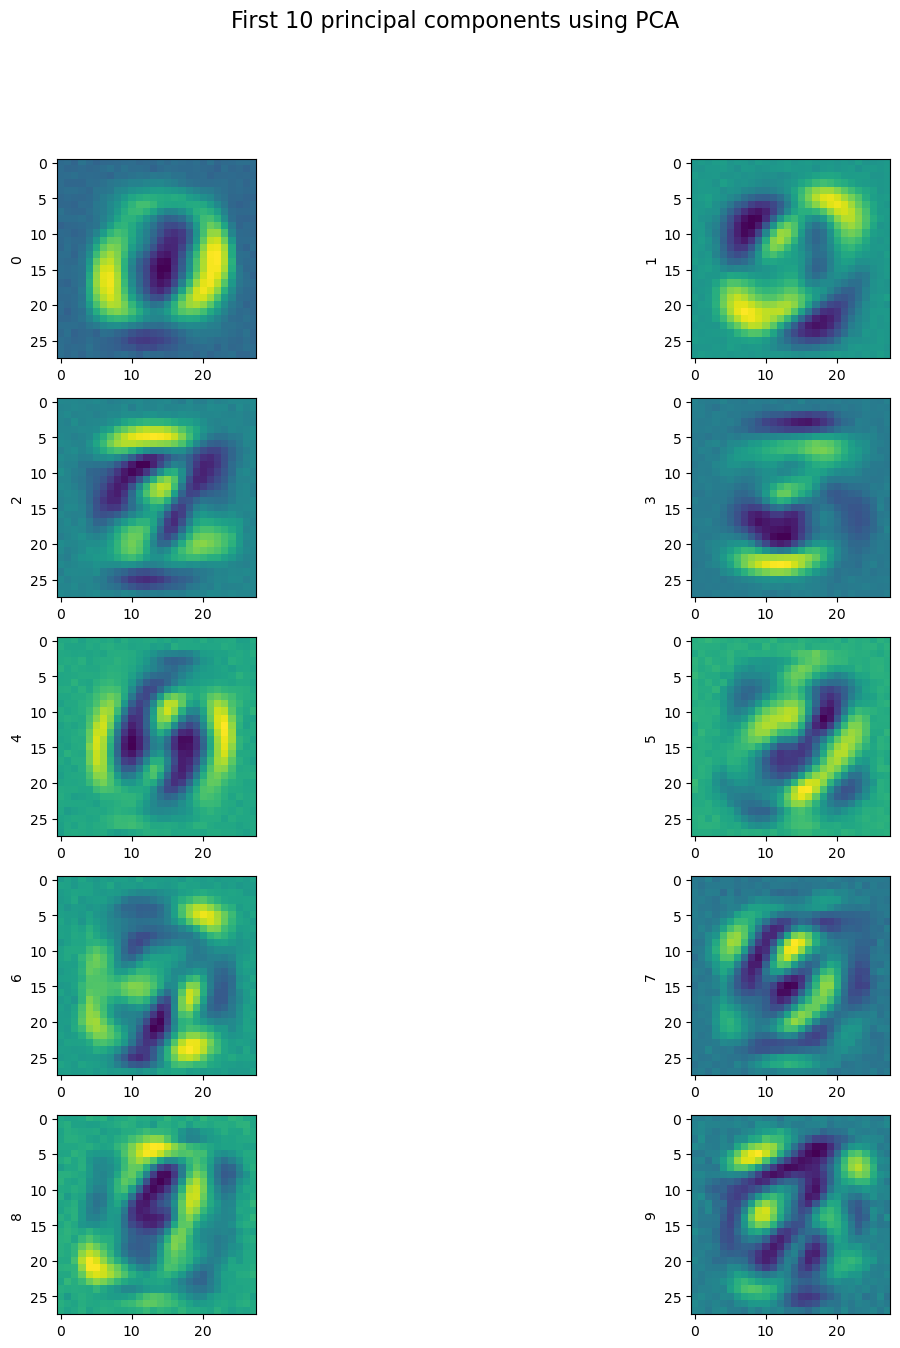

In [41]:
# Plot the first 10 principal components using PCA
k = 10
X_pca, eigenvectors, eigenvalues = pca_function(X_train_noisy_std,k)

nrow = 5; ncol = 2
fig, axs = plt.subplots(nrows=nrow, ncols=ncol,figsize=(15,15))

for i,ax in enumerate(axs.reshape(-1)): 
    ax.imshow(eigenvectors[:,i].reshape([28,28]))
    ax.set_ylabel(str(i))
plt.suptitle('First 10 principal components using PCA', fontsize=16)
plt.show()

>We also visualise the first 10 principal components that we have obtained using PCA. We can easily notice some patterns and number in these principal components. For instance, the first principal component seems to be close to the *0* digit. This shows that PCA correctly identified some essential features of the digits.

We have been able to built a PCA model and determine the number of principal components needed to explain 70%, 80% and 90% of the variance:
- *213* principal components to explain 70% of the variance
- *298* principal components to explain 80% of the variance
- *408* principal components to explain 90% of the variance

We will be able to use this method in order to reconstruct the corrupted images.

1.2.2

Similarly, we want to use another method in order to perform dimensionality reduction on the corrupted images. We will use NMF to perform dimensionality reduction on the corrupted images. We will then use the NMF model to reconstruct the corrupted images.

> We first have to normalize the data using the minimum and maximum. In NMF, we typically normalize the data to have unit Euclidean length along each sample dimension (i.e., each row of the data matrix). This means that the norm of each row of the data matrix is 1, which ensures that each sample has equal importance in the decomposition.

In [42]:
# Normalise min max to 0-1
def normalize_nmf(X):
    X_norm = (X- np.min(X)) / (np.max(X) - np.min(X))
    # Return the normalized data and the min and max values in order to denormalize the data for the reconstruction
    return X_norm, np.min(X), np.max(X)

X_train_noisy_nmf, min_train, max_train = normalize_nmf(X_train_noisy)
X_test_noisy_nmf, min_test, max_test = normalize_nmf(X_test_noisy)

In [43]:
def cost(X, W, H):
  
    # Compute the difference between X and the dot product of W and H
    diff = X - np.dot(W, H)

    chi2 = ((X*diff) * diff).sum() / (X.shape[0]*X.shape[1])
    
    return chi2

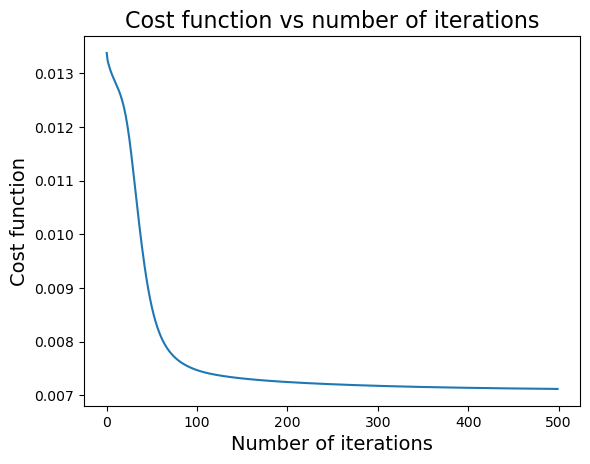

In [44]:
# Choosing the number of dimensions (r, called here k) on which to project
k = 10

# k x P matrix interpreted as the basis set, where k is the number of components, P the number of descriptors of the data
H = np.random.rand(k, X_train_noisy_nmf.shape[1])

# N x k components matrix, usually interpreted as the coefficients, N is the number of data
W = np.random.rand(X_train_noisy_nmf.shape[0], k)

# Set the number of iterations
n_iters = 500
pseudo_count = 0.001 ## this is just a small value that we place at the denominator to avoid division by zero

# Empty list 
cost_values = []

# Loop over the n iterations
for i in range(n_iters):

    # Compute the update on H
    H = H * ((W.T.dot(X_train_noisy_nmf))/(W.T.dot(W.dot(H))+pseudo_count))

    # Compute the update on W
    W = W * ((X_train_noisy_nmf.dot(H.T))/(W.dot(H.dot(H.T))+pseudo_count))

    # Compute the cost and append to list
    cost_values.append(cost(X_train_noisy_nmf,W,H))

# Plotting the cost
plt.plot(cost_values)
plt.xlabel('Number of iterations', fontsize=14)
plt.ylabel('Cost function', fontsize=14)
plt.title('Cost function vs number of iterations', fontsize=16)
plt.show()

> By plotting the cost function in terms of the number of iterations, we notice that the cost function decreases as the number of iterations increases. This is due to the fact that the cost function is the sum of the squared errors between the original data and the reconstructed data. Moreover, we can see that this number of iteration is enough has it seems that the cost function is not significantly decreasing anymore and remains very low for the majority of the iterations.

> Note: We have implemented the NMF algorithm using the Lee and Seung's multiplication rule, updating H and W simultaneously at each step. We have also used the chi-square loss function.

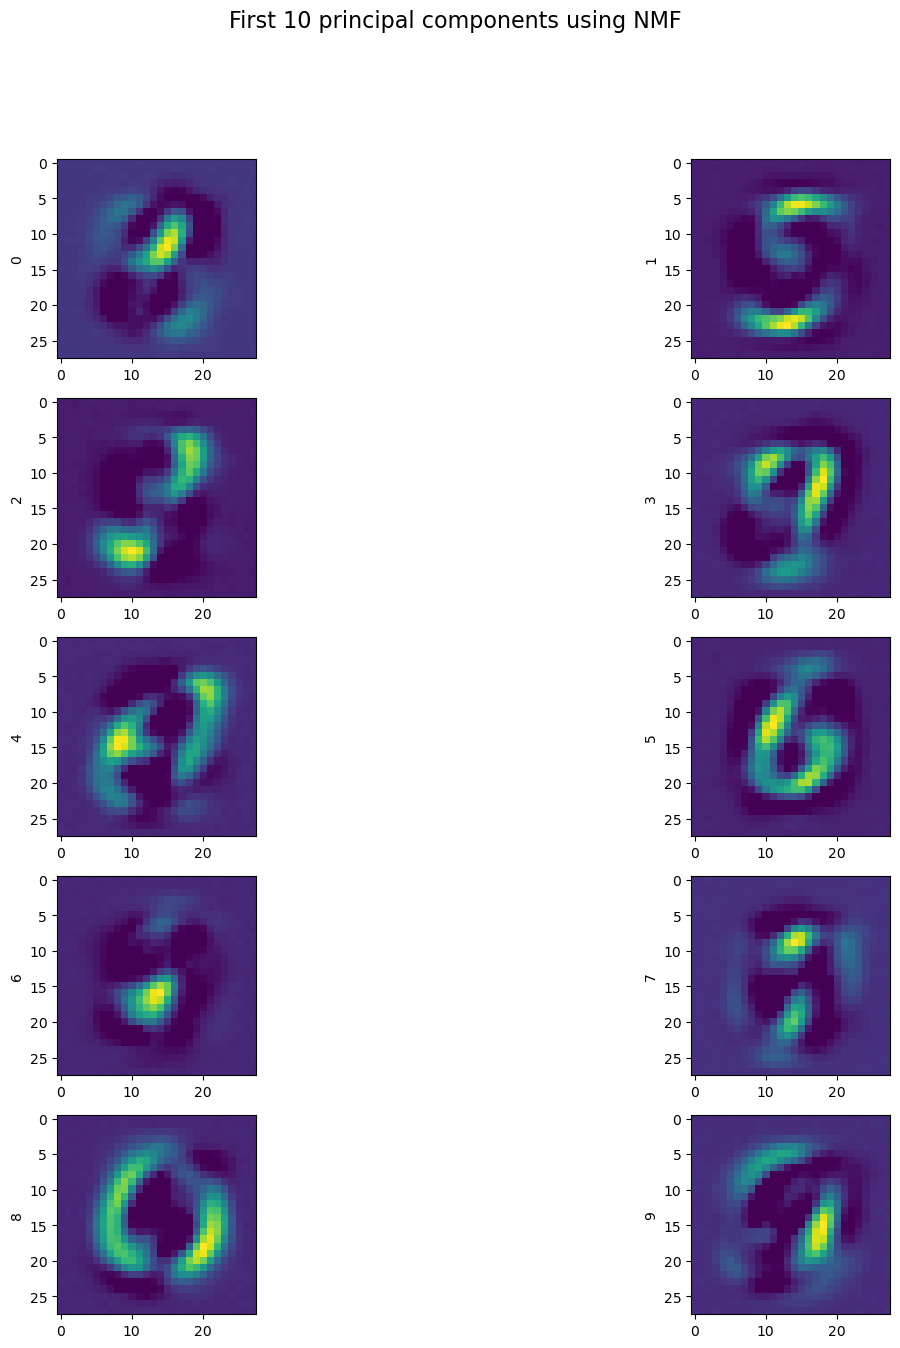

In [45]:
# Plot the first 10 NMF components
nrow = 5; ncol = 2;
fig, axs = plt.subplots(nrows=nrow, ncols=ncol, figsize=(15,15))

for i,ax in enumerate(axs.reshape(-1)): 
    ax.imshow(H[i,:].reshape([28,28]))
    ax.set_ylabel(str(i))
plt.suptitle('First 10 principal components using NMF', fontsize=16)
plt.show()

> By plotting the first 10 NMF components, we notice that the NMF components are quite different from the PCA components. Indeed, the NMF components are more blurry than the PCA components. Indeed, the NMF components are not orthogonal to each other because the NMF components are not linear combinations of the original features. This is why the NMF components are more blurry than the PCA components.

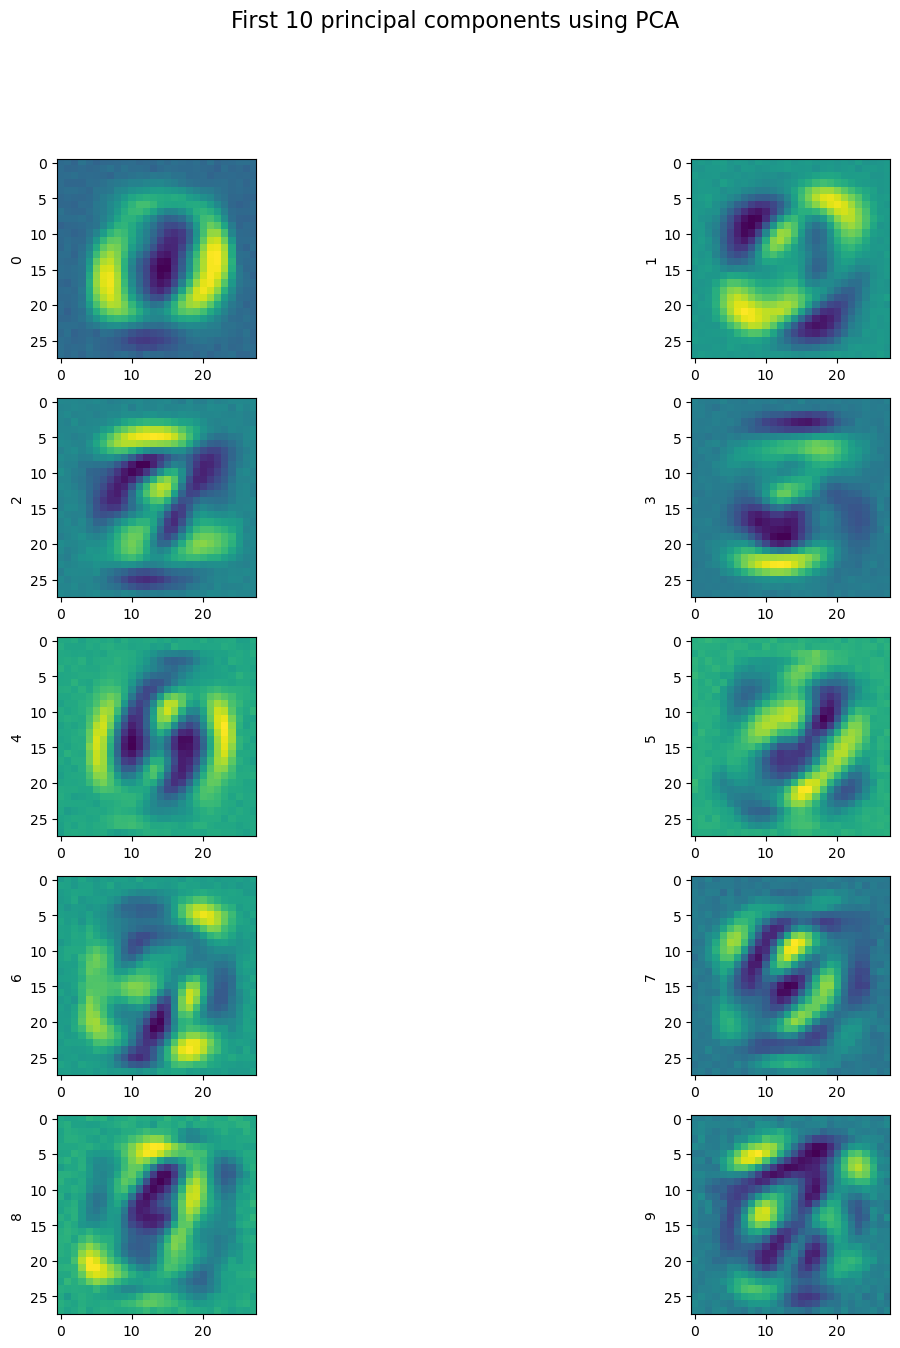

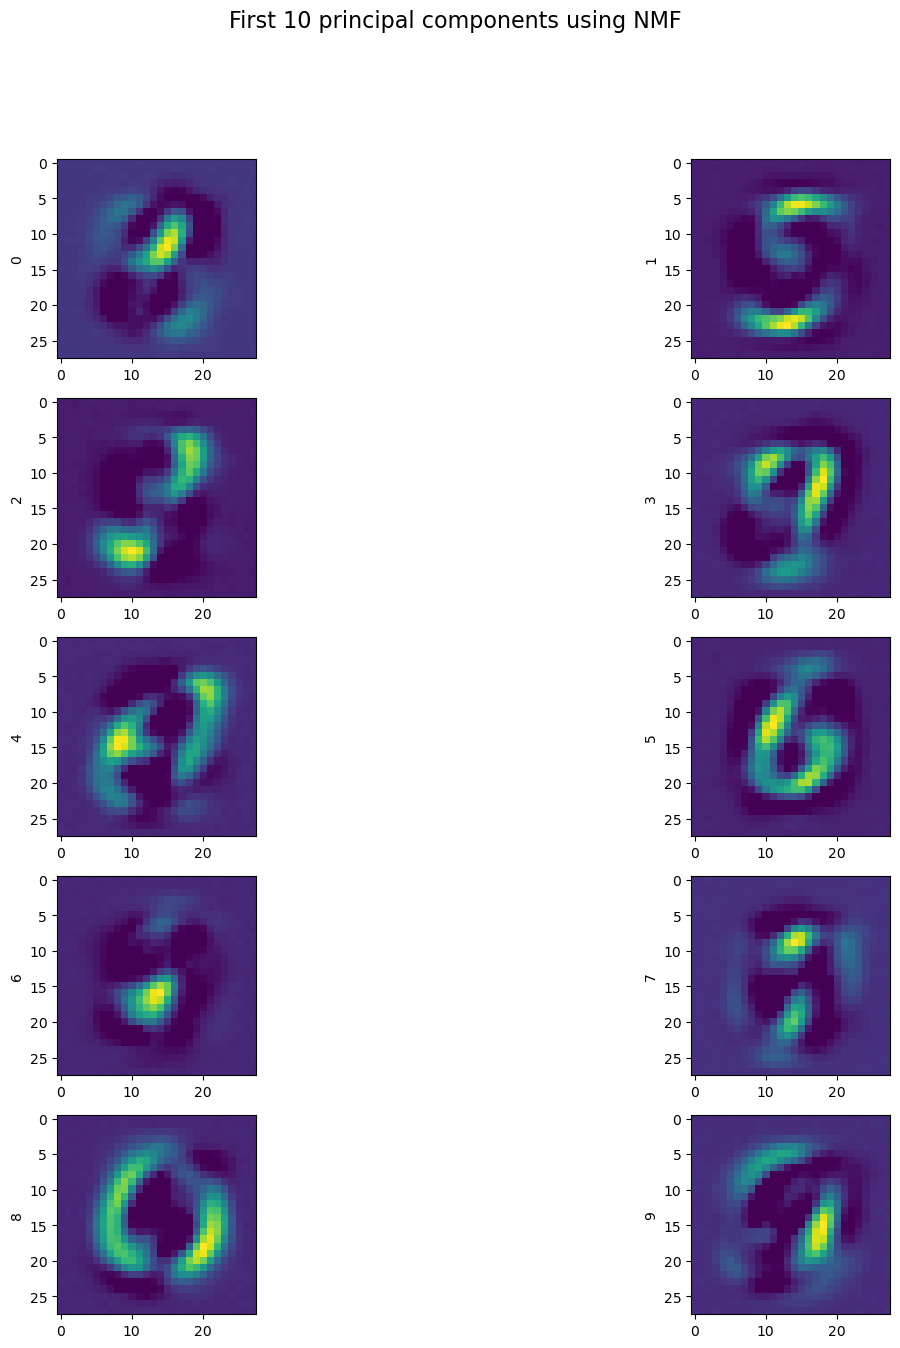

In [46]:
# Plot the PCA and NMF imshow together for comparison
nrow = 5; ncol = 2;
fig, axs = plt.subplots(nrows=nrow, ncols=ncol, figsize=(15,15))

for i,ax in enumerate(axs.reshape(-1)):
    ax.imshow(eigenvectors[:,i].reshape([28,28]))
    ax.set_ylabel(str(i))
plt.suptitle('First 10 principal components using PCA', fontsize=16)

nrow = 5; ncol = 2;
fig, axs = plt.subplots(nrows=nrow, ncols=ncol, figsize=(15,15))

for i,ax in enumerate(axs.reshape(-1)):
    ax.imshow(H[i,:].reshape([28,28]))
    ax.set_ylabel(str(i))
plt.suptitle('First 10 principal components using NMF', fontsize=16)
plt.show()

By plotting the first 10 components for both PCA and NMF, we notice that the NMF components are more blurry than the PCA components. Indeed, the NMF components are not orthogonal to each other because the NMF components are not linear combinations of the original features. Moreover, the colors (i.e. values) of the NMF components are different to the PCA components but this is mainly due to the fact that the NMF components cannot have values below 0.

&nbsp;
&nbsp;

Overall, PCA and NMF are two different methods of dimensionality reduction that work in fundamentally different ways, and as a result, their results are quite different. They are different methods because the algorithms used to find them make different assumptions about the structure of the data: 
- PCA is a linear method that seeks to find a set of orthogonal axes that capture the most variance in the data. These axes are defined based on the covariance matrix of the data and are ordered according to the amount of variance they capture.
- NMF, on the other hand, is a non-linear method that seeks to represent the data as a non-negative linear combination of basis vectors. These basis vectors are learned from the data.

This means that PCA tends to be better suited to identifying global patterns in the data, whereas NMF tends to be better suited to identifying local, non-negative patterns. Another difference between PCA and NMF is that PCA produces both positive and negative principal components, whereas NMF produces only non-negative basis vectors. This means that the interpretation of the components can be different between PCA and NMF.

This is very translatable to our results. Indeed, the PCA components are more interpretable than the NMF components. This is because the PCA components are orthogonal to each other and thus, they are linear combinations of the original features. This means that the PCA components are more interpretable than the NMF components

1.2.3

As indicated in the question guidelines, we first refit PCA and NMF on the noisy training set using $m=100$ components. We will then use these models to reconstruct the noisy test set images. We will be able to compare our reconstructed images by plotting the original images, the noisy images and the reconstructed images next to each other.

In [47]:
# Fit PCA and NMF to the noisy training set with 100 components
X_train_pca, eigenvectors, eigenvalues = pca_function(X_train_noisy_std, 100)

# choosing the number of dimensions (r, called here k) on which to project
k = 100

# k x P matrix interpreted as the basis set, where k is the number of components, P the number of descriptors of the data
H = np.random.rand(k, X_train_noisy_nmf.shape[1])

# N x k components matrix, usually interpreted as the coefficients, N is the number of data
W = np.random.rand(X_train_noisy_nmf.shape[0], k)

W_test = np.random.rand(X_test_noisy_nmf.shape[0], k)

# set the number of iterations
n_iters = 500
pseudo_count = 0.001 ## this is just a small value that we place at the denominator to avoid division by zero

# empty list 
cost_values = []

# loop over the n iterations
for i in range(n_iters):

    # compute the update on H
    H = H * ((W.T.dot(X_train_noisy_nmf))/(W.T.dot(W.dot(H))+pseudo_count))

    # compute the update on W
    W = W * ((X_train_noisy_nmf.dot(H.T))/(W.dot(H.dot(H.T))+pseudo_count))

    # compute the cost and append to list
    cost_values.append(cost(X_train_noisy_nmf,W,H))

> We define two functions that allow us to rescale the images in order to be able to plot them next to each other.

In [48]:
def back_to_scale_pca(X, eigenvectors, mean, std, rescale=True):
    """
    This function transforms the data back to the original scale.

    Parameters:
    X: numpy array 
        The data to be transformed.
    eigenvectors: numpy array 
        The eigenvectors of the covariance matrix.
    mean: numpy array 
        The mean of the data.
    std: numpy array 
        The standard deviation of the data.
    
    Returns:
    X_modified: numpy array 
        The transformed data.
    
    """
    X_modified = X.dot(eigenvectors.T) # transform the data
    if rescale:
        X_modified = X_modified*std + mean # rescale the data
    return X_modified

def back_to_scale_nmf(X, H, min_value, max_value):
    """
    This function transforms the data back to the original scale.

    Parameters:
    X: numpy array 
        The data to be transformed.
    H: numpy array 
        The basis set.
    min_value: float 
        The minimum value of the data.
    max_value: float 
        The maximum value of the data.
    
    Returns:
    X_modified: numpy array 
        The transformed data.
    
    """
    X_modified = X # copy the data
    X_modified = X_modified*(max_value-min_value) + min_value # rescale the data
    return X_modified

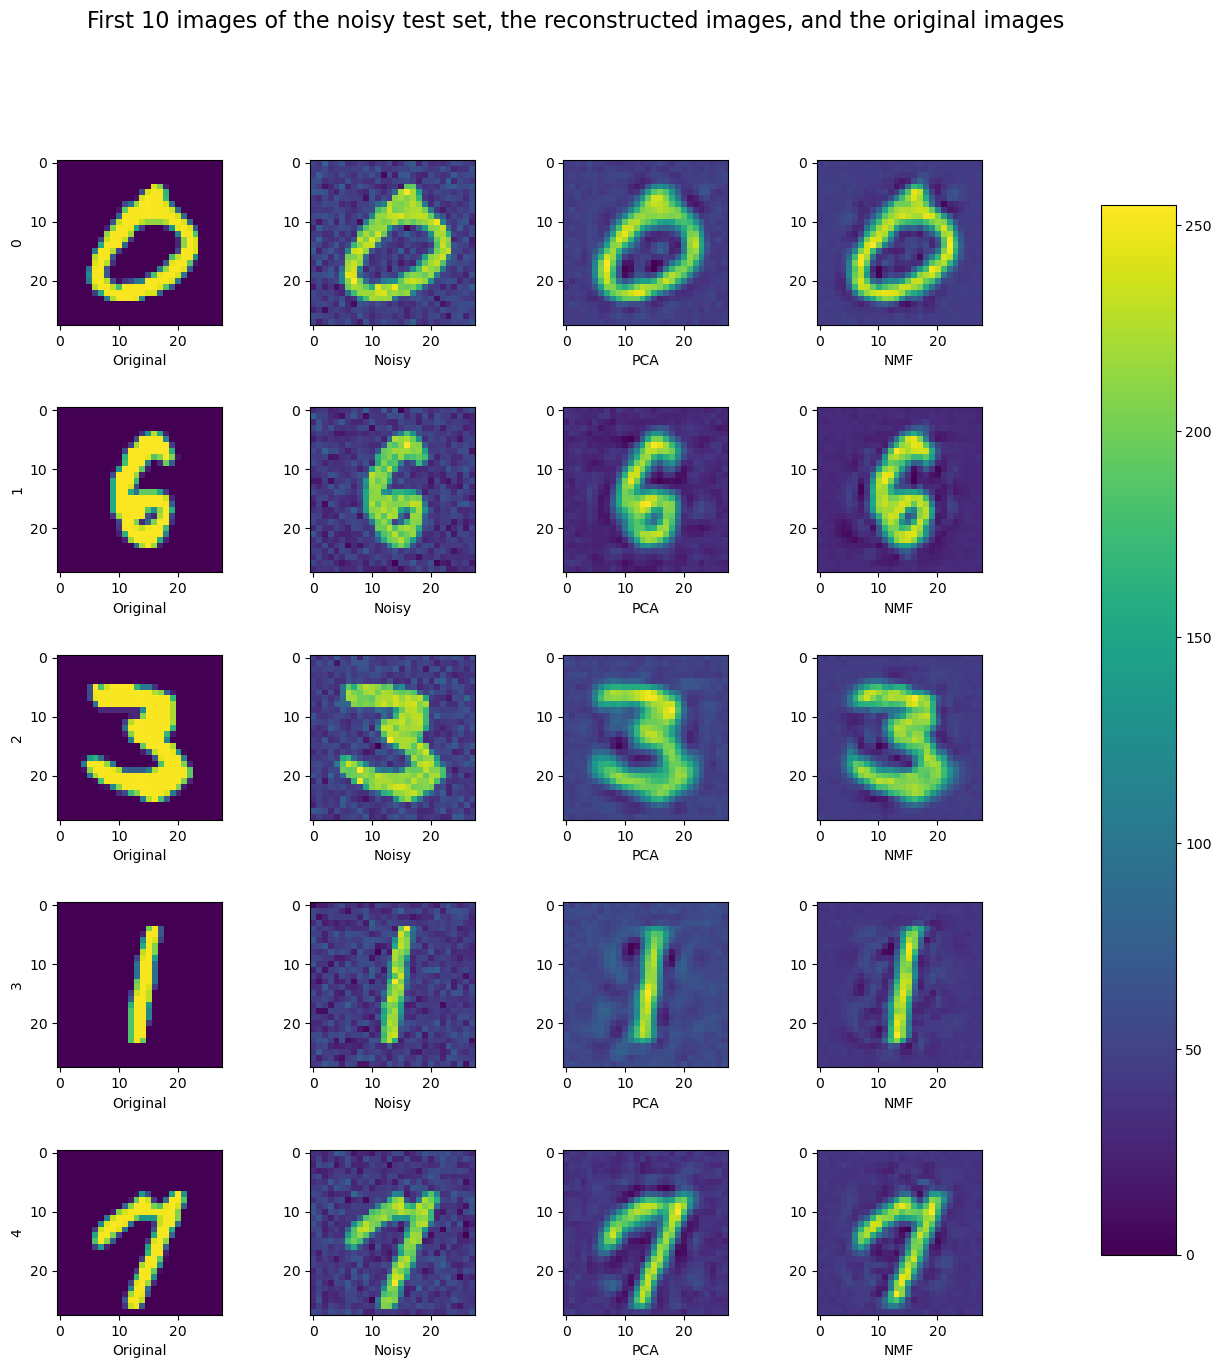

In [49]:
# Use the fitted PCA and NMF models to transform the noisy test set
# Use a linear combination of PCA and NMF to reconstruct the noisy test set
X_test_pca = np.dot(X_test_noisy_std, eigenvectors)
W_test = X_test_noisy_nmf.dot(np.linalg.pinv(H)) # Get the weights matrix for the test set
X_test_nmf = np.dot(W_test, H)
X_test_pca = back_to_scale_pca(X_test_pca, eigenvectors, mean_train, std_train)
X_test_nmf = back_to_scale_nmf(X_test_nmf, H, min_train, max_train)


# Plot the first 10 images of the noisy test set, the reconstructed images, and the original images
nrow = 5; ncol = 4
fig, axs = plt.subplots(nrows=nrow, ncols=ncol, figsize=(15,15))
fig.subplots_adjust(hspace = .5, wspace=.001)
img_idx = 0
for i,ax in enumerate(axs.reshape(-1)):
    # Plot the original image on the first column 
    if i%4 == 0:
        ax.imshow(X_test_unstd[img_idx].reshape([28,28])) # unstandardized data plotted
        ax.set_ylabel(str(img_idx))
        ax.set_xlabel('Original')
    # Plot the noisy image on the second column
    elif i%4 == 1:
        ax.imshow(X_test_noisy[img_idx].reshape([28,28]))
        ax.set_xlabel('Noisy')
    # Plot the reconstructed image on the third column
    elif i%4== 2:
        ax.imshow(X_test_pca[img_idx].reshape([28,28]))
        ax.set_xlabel('PCA')
    else:
        ax.imshow(X_test_nmf[img_idx].reshape([28,28]))
        ax.set_xlabel('NMF')
        img_idx += 1
# add colorbar
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
fig.colorbar(axs[0,0].get_images()[0], cax=cbar_ax)
plt.suptitle('First 10 images of the noisy test set, the reconstructed images, and the original images', fontsize=16)
plt.show()


> Please note that we have made sure that we use the unstandardized data in order to be able to plot the images and accurately compare them to the noisy and reconstructed images.

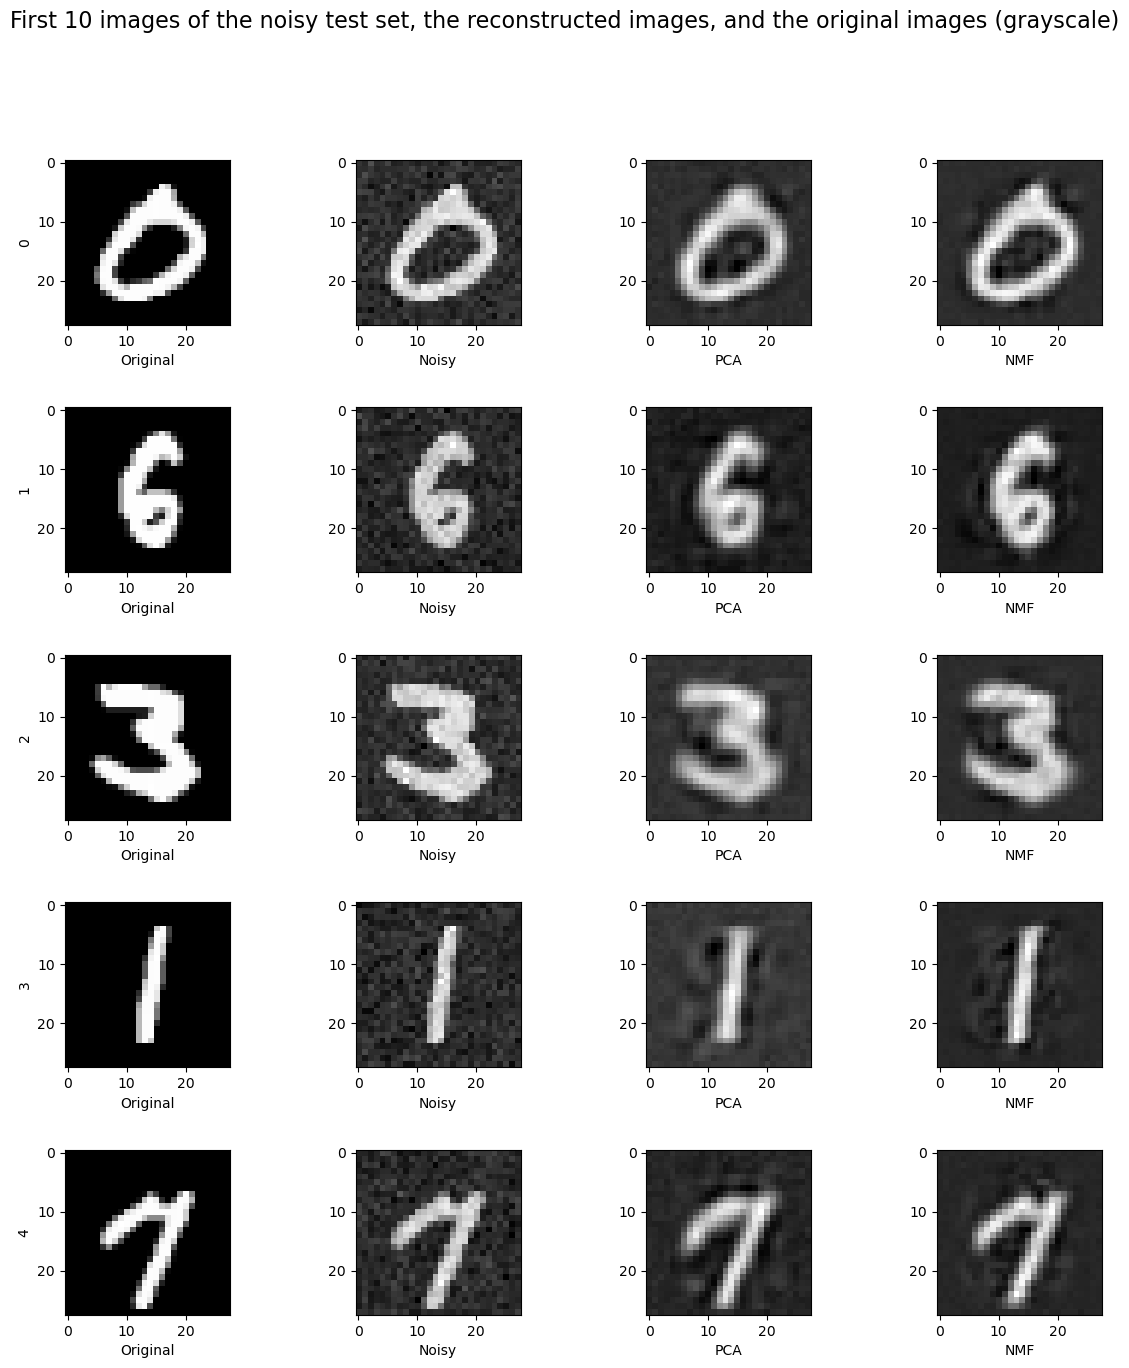

In [50]:
# Use the fitted PCA and NMF models to transform the noisy test set
X_test_pca = np.dot(X_test_noisy_std, eigenvectors)
W_test = X_test_noisy_nmf.dot(np.linalg.pinv(H))
X_test_nmf = W_test @ H
X_test_pca = back_to_scale_pca(X_test_pca, eigenvectors, mean_train, std_train)
X_test_nmf = back_to_scale_nmf(X_test_nmf, H, min_train, max_train)


# Plot the first 10 images of the noisy test set, the reconstructed images, and the original images
nrow = 5; ncol = 4
fig, axs = plt.subplots(nrows=nrow, ncols=ncol, figsize=(15,15))
fig.subplots_adjust(hspace = .5, wspace=.001)
img_idx = 0
for i,ax in enumerate(axs.reshape(-1)):
    # Plot the original image on the first column 
    if i%4 == 0:
        ax.imshow(X_test_unstd[img_idx].reshape([28,28]), cmap='gray') # unstandardized data plotted
        ax.set_ylabel(str(img_idx))
        ax.set_xlabel('Original')
    # Plot the noisy image on the second column
    elif i%4 == 1:
        ax.imshow(X_test_noisy[img_idx].reshape([28,28]), cmap='gray')
        ax.set_xlabel('Noisy')
    # Plot the reconstructed image on the third column
    elif i%4== 2:
        ax.imshow(X_test_pca[img_idx].reshape([28,28]), cmap='gray')
        ax.set_xlabel('PCA')
    else:
        ax.imshow(X_test_nmf[img_idx].reshape([28,28]), cmap='gray')
        ax.set_xlabel('NMF')
        img_idx += 1
plt.suptitle('First 10 images of the noisy test set, the reconstructed images, and the original images (grayscale)', fontsize=16)
plt.show()

> We also plot the images in grayscale for better comparison between the images and to have a more realistic representation of the images.

In order to reconstruct the images, we used some essential derivations from the PCA and NMF algorithms. Indeed, we used the following derivations:

- For PCA, we have reconstructed the images using a linear combination of the principal components in PCA, that we can express as
$$X_{reconstructed} = X_{test} * C * C^T$$ 
where $C = \{c_1, c_2, ..., c_m\}$ is the set of the first $m=100$ principal components. We have then rescaled the reconstructed images using the following formula:
$$X_{reconstructed} = X_{reconstructed}* \sigma + \mu$$ 
where $\sigma$ is the standard deviation of the original images and $\mu$ is the mean of the original images.

&nbsp;
&nbsp;
&nbsp;

- For NMF, we have reconstructed the images using a linear combination of the basis vectors in NMF. We first got the $W_{test}$ matrix:
$$W_{test} = X_{test} * H_{train}^{-1_p}$$ 
where $H_{train}$ is the matrix of the basis vectors in NMF for the training set and $H_{train}^{-1_p}$ is the pseudo-inverse of $H_{train}$.

We then compute the reconstructed images using the following formula:
$$X_{reconstructed} = W_{test} * H_{train}$$
Finally, we have obtained the reconstructed images by rescaling them using the following formula:
$$X_{reconstructed} = X_{reconstructed}* (max-min) + min$$ 
where $min$ is the minimum of the original images and $max$ is the maximum of the original images.

By visualising the different versions of the first 10 images, we notice quite some differences in the two versions used to reconstruct the images. Indeed, the PCA reconstructed images seem more blurry than the NMF reconstructed images.

From the visual inspection, it appears that PCA has effectively reduced the noise in the image, as the background is now more uniform in color than in the original image. However, the reconstructed image using PCA is not an exact replica of the original image, which had a completely dark background. This is likely because the standardization and unstandardization steps in PCA may have altered the color scheme of the image, resulting in a reconstructed image that is not identical to the original. It is possible that further optimization of the parameters or methods used in PCA could yield a more accurate reconstruction. Additionally, it is possible that some noise may still be present in the reconstructed image, resulting in deviations from the original image. Overall, while PCA has shown promise in denoising the image, there is still room for improvement in terms of achieving a more accurate reconstruction of the original image.

In contrast to PCA, NMF has shown to effectively denoise the background of the image, resulting in a reconstructed image that closely resembles the original with a dark background. However, while NMF has been able to remove more noise from the background than PCA, it appears to have lost some reconstruction value in the central portion of the image. The light ring in the NMF reconstructed image is more blurry in some areas. Therefore, it appears that NMF may excel at denoising the background, but may struggle to preserve finer details in the central portion of the image.

We could say that NMF seems to be more performant in extracting the most important information out of the image and thus to preserve the important information while denoising.

1.2.4

We now want to evaluate the performance of PCA as the number of components $m$ changes using the MSE error. We will then plot the MSE error as a function of the number of components $m$. We will also visualise the reconstructed images for different values of $m$ to compare visually how the reconstructed images change as $m$ changes.

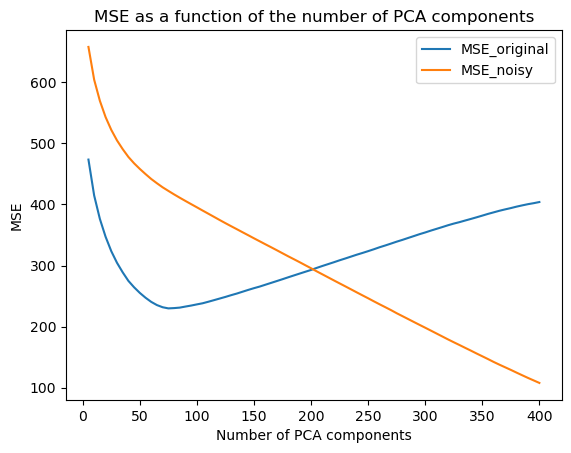

In [51]:
# Plot, on the same figure, these two MSEs as a function of the number of PCA components m, varying m in the interval 5-400 with a step size 5
MSE_original = []
MSE_noisy = []
X_train_pca, eigenvectors, eigenvalues = pca_function(X_train_noisy_std, 400)
for m in range(5, 401, 5):
    # Use the fitted PCA models to transform the noisy test set
    X_test_pca = np.dot(X_test_noisy_std, eigenvectors[:, :m])
    X_test_pca = back_to_scale_pca(X_test_pca, eigenvectors[:, :m], mean_train, std_train, rescale=False)
    # Compute the MSE between the PCA reconstructed images and the original images (by image)
    # Sum the squared errors over the images and take the mean
    MSE = np.mean(np.sum((X_test_pca - X_test)**2, axis=1))
    MSE_original.append(MSE)
    # Compute the MSE between the PCA reconstructed images and the noisy images
    MSE =  np.mean(np.sum((X_test_pca - X_test_noisy_std)**2, axis=1))
    MSE_noisy.append(MSE)

# Plot, on the same figure, these two MSEs as a function of the number of PCA components m, varying m in the interval 5-400 with a step size 5
plt.plot(range(5, 401, 5), MSE_original, label='MSE_original')
plt.plot(range(5, 401, 5), MSE_noisy, label='MSE_noisy')
plt.legend()
plt.xlabel('Number of PCA components')
plt.ylabel('MSE')
plt.title('MSE as a function of the number of PCA components')
plt.show()

> Note that we have ensured that we are computing the average MSE error by image and not by feature/pixel in order to be able to compare the MSE error between the different images. This was indicated in a edStem post: https://edstem.org/us/courses/31518/discussion/2743911

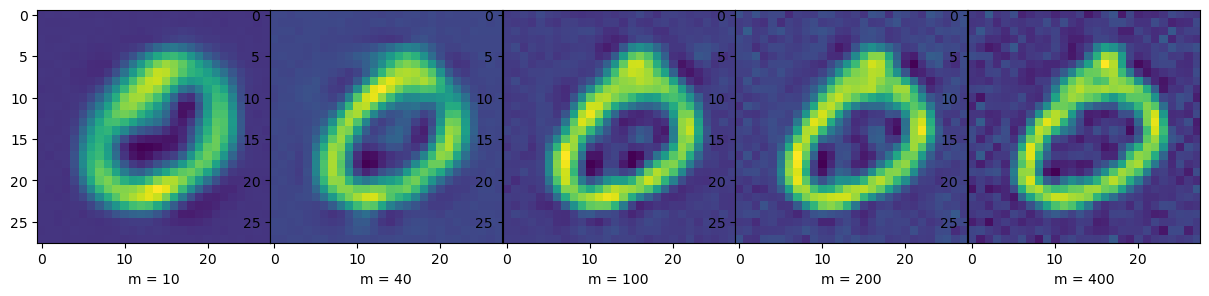

In [52]:
# Visualise an example of a reconstructed image for m = 10, 40, 100, 200 and 400
m = [10, 40, 100, 200, 400]
fig, axs = plt.subplots(nrows=1, ncols=5, figsize=(15,15))
fig.subplots_adjust(hspace = .5, wspace=.001)
for i, ax in enumerate(axs.reshape(-1)):
    X_test_pca = np.dot(X_test_noisy_std, eigenvectors[:, :m[i]])
    X_test_pca = back_to_scale_pca(X_test_pca, eigenvectors[:, :m[i]], mean_train, std_train, rescale=True)
    ax.imshow(X_test_pca[0].reshape([28,28]))
    ax.set_xlabel('m = ' + str(m[i]))
plt.show()

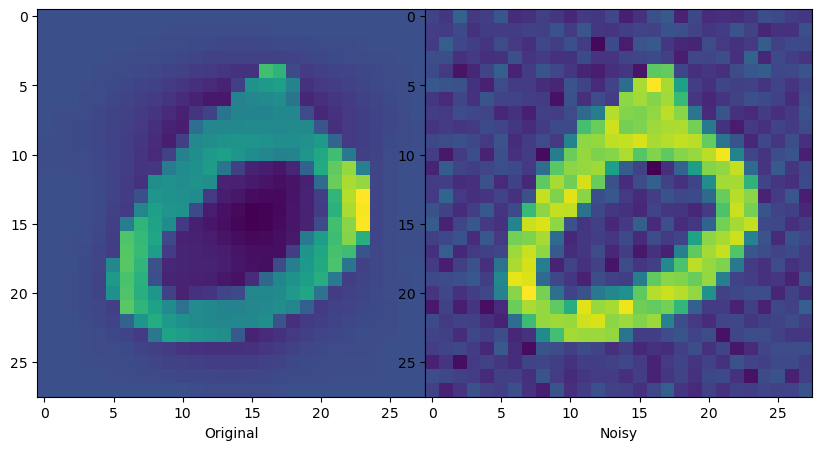

In [53]:
# Plot original image and noisy image
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(10,10))
fig.subplots_adjust(hspace = .5, wspace=.001)
axs[0].imshow(X_test[0].reshape([28,28]))
axs[0].set_xlabel('Original')
axs[1].imshow(X_test_noisy[0].reshape([28,28]))
axs[1].set_xlabel('Noisy')
plt.show()

By observing the plot of MSEs, we notice that by progressively increasing m, the reconstructed images for the first image become progressively closer to the noisy image as we recover more variance. The reconstruction with $m=10$ has the lowest MSE with the original image and thus is the closest to the original image. Moreover, the MSE plot shows that the MSE between the reconstructed images and the corrupted image decreases to 0 as we increase $m$. This could be explained by the fact that as we increase m, more of the variance is being retained by more principal components. In contrast, the MSE between the reconstructed images and the original unnoisy images decreases until around $m=60$, which is an optimal number of components to reconstruct the original images well. As we increase $m$ beyond this point, the MSE increases. This is most likely because the explained variance past the first 50 eigenvalues is just noise: our PCA decomposition is then fitting the noise present in the noisy images. On the other hand, beyond $m=200$, the reconstructed images become closer to the noisy images than to the unnoisy ones. 

&nbsp;
&nbsp;

We can observe in the plot of the first image with $m=10$ that the central digit is a bit blury but that it becomes less blurry as $m$ increases. Even though it becomes more and more clear as we increase $m$, we can see that the images become more and more noisy especially in the background. Please note that even though it was not asked in the question to plot for $m=400$, we decided to plot it in order to confirm that the reconstructed images become more and more noisy as $m$ increases.

#### 1.3 Gaussian Mixture Models (20 marks)

In this task, we will be using Gaussian Mixture Models (GMM) to perform clustering on the MNIST dataset. GMM is a probabilistic model that assumes that each data point is generated by a mixture of several Gaussian distributions, where each distribution represents a cluster. The model learns the parameters of the Gaussian distributions, including their means and covariances, from the data.


1.3.1

In this subtask, we will use the first five principal components of the PCA on the first 1000 images of the MNIST_train.csv dataset to perform clustering using a GMM with ten hidden components. We will visualize the space spanned by the top two principal components, coloring each point according to their cluster. This will help us understand the clustering performance and visualize the clusters in a lower-dimensional space.

In [54]:
# Compute the first five principal components of the PCA on the first N=1000 images of the dataset MNIST_train.csv 
X_train_pca, eigenvectors, eigenvalues = pca_function(X_train[:1000], 5)
print("Check the shape of the first five principal components: {}".format(X_train_pca.shape))

Check the shape of the first five principal components: (1000, 5)


In [55]:
class GMModel:
    """Struct to define Gaussian Mixture Model"""
    """:param dim: number of mixture components"""
    """:param weights: mixture weights"""
    """:param mu: mixture component means for each cluster"""
    """:param sigma: mixture component covariance matrix for each cluster"""
    
    def __init__(self, X, dim):
        """Initialises parameters through random split of the data"""
        
        self.dim = dim

        # initial weights given to each cluster are stored in phi or P(Ci=j)
        self.phi = np.full(shape=self.dim, fill_value=1/self.dim) 

        # initial weights given to each data point wrt to each cluster or P(Xi/Ci=j)
        self.weights = np.full(shape=X.shape, fill_value=1/self.dim)
        
        n,m = X.shape 
        # dataset is divided randomly into k parts of unequal sizes
        random_row = np.random.randint(low=0, high=n, size=self.dim)

        # initial value of mean of k Gaussians
        self.mu = [  X[row_index,:] for row_index in random_row ]  

        # initial value of covariance matrix of k Gaussians
        self.sigma = [ np.cov(X.T) for _ in range(self.dim) ] 

def cluster_probabilities(gmm, X):
    """Predicts probability of each data point with respect to each cluster"""
    
    # n has the number of rows while m has the number of columns of dataset X
    n,m = X.shape 
    # Creates a n*k matrix denoting likelihood belonging to each cluster 
    likelihood = np.zeros( (n, gmm.dim) ) 
    for i in range(gmm.dim):
        # likelihood of data belonging to i-th cluster 
        distribution = multivariate_normal(mean=gmm.mu[i],cov=gmm.sigma[i])
        likelihood[:,i] = distribution.pdf(X) 

        numerator = likelihood * gmm.phi
        denominator = numerator.sum(axis=1)[:, np.newaxis]
        weights = numerator / denominator
    return weights

def predict(gmm, X):
    """Performs hard clustering"""
    weights = cluster_probabilities(gmm,X)
    return np.argmax(weights, axis=1)

def fitStep(gmm,X):
    """Performs an EM step by updating all parameters"""
    
    # E-Step: update weights and phi holding mu and sigma constant
    weights = cluster_probabilities(gmm,X)
    gmm.phi = weights.mean(axis=0)
        
    # M-Step: update mu and sigma holding pi and weights constant
    for i in range(gmm.dim):
        weight = weights[:, [i]]
        total_weight = weight.sum()

        gmm.mu[i] = (X * weight).sum(axis=0) / total_weight 
        gmm.sigma[i] = np.cov(X.T,aweights=(weight/total_weight).flatten(), bias=True)
    
    # Return the log-likelihood
    return np.sum(np.log(np.sum(cluster_probabilities(gmm,X) * gmm.phi, axis=1)))

def draw_ellipse(position, covariance, ax=None, **kwargs):
    """Draw an ellipse with a given position and covariance"""
    ax = ax or plt.gca()
    
    # Convert covariance to principal axes
    if covariance.shape == (2, 2):
        U, s, Vt = np.linalg.svd(covariance)
        angle = np.degrees(np.arctan2(U[1, 0], U[0, 0]))
        width, height = 2 * np.sqrt(s)
    else:
        angle = 0
        width, height = 2 * np.sqrt(covariance)
    
    # Draw the Ellipse
    for nsig in range(1, 4):
        ax.add_patch(Ellipse(position, nsig * width, nsig * height,
                             angle=angle, **kwargs))
        
def plot_gmm(gmm, X, label=True, ax=None, class_labels=None, colorbar=False, ellipse=True):
    """Plots the Gaussian Mixture Model"""
    ax = ax or plt.gca()
    labels = predict(gmm,X)
    if label:
        if class_labels is None:
            ax.scatter(X[:, 0], X[:, 1], c=labels, s=40, cmap='viridis', zorder=2)
        else:
            if colorbar:
                im = ax.scatter(X[:, 0], X[:, 1], c=class_labels, s=40, cmap='viridis', zorder=2, label=class_labels, vmin=0, vmax=1)
                plt.colorbar(im)
            else:
                ax.scatter(X[:, 0], X[:, 1], c=class_labels, s=40, cmap='viridis', zorder=2, label=class_labels)
    else:
        ax.scatter(X[:, 0], X[:, 1], s=40, zorder=2)
    ax.axis('equal')
    if ellipse:
        w_factor = 0.2 / gmm.weights.max()
        for pos, covar, w in zip(gmm.mu, gmm.sigma, gmm.phi):
            # select only top two components
            pos = pos[:2]
            covar = covar[:2, :2]
            draw_ellipse(pos, covar, alpha=w * w_factor)
    return ax

Iteration: 1 Log-Likelihood: -2019.3473970562773
Iteration: 2 Log-Likelihood: -2031.5954086176644
Iteration: 3 Log-Likelihood: -2038.3999977660917
Iteration: 4 Log-Likelihood: -2042.8415985249394
Iteration: 5 Log-Likelihood: -2046.809475876606
Iteration: 6 Log-Likelihood: -2050.3726941607015
Iteration: 7 Log-Likelihood: -2055.0252696403977
Iteration: 8 Log-Likelihood: -2064.3348790975324
Iteration: 9 Log-Likelihood: -2075.3560406680754
Iteration: 10 Log-Likelihood: -2084.387072198645
Iteration: 11 Log-Likelihood: -2091.566520780015
Iteration: 12 Log-Likelihood: -2097.6621926554944
Iteration: 13 Log-Likelihood: -2101.77592299436
Iteration: 14 Log-Likelihood: -2103.848713017006
Iteration: 15 Log-Likelihood: -2104.264763136299
Iteration: 16 Log-Likelihood: -2103.7198303025198
Iteration: 17 Log-Likelihood: -2103.0209142987624
Iteration: 18 Log-Likelihood: -2102.550922308543
Iteration: 19 Log-Likelihood: -2102.1756742045654
Iteration: 20 Log-Likelihood: -2101.823850319006
Iteration: 21 Log-

/var/folders/rl/d4jq2g217cv1hy_ssxxj4k0r0000gn/T/ipykernel_3920/2334194511.py:43: RuntimeWarning: invalid value encountered in divide
  weights = numerator / denominator


Iteration: 38 Log-Likelihood: -2103.5159101834533
Iteration: 39 Log-Likelihood: -2104.268554233778
Iteration: 40 Log-Likelihood: -2105.1187990348467
Iteration: 41 Log-Likelihood: -2106.0186785047536
Iteration: 42 Log-Likelihood: -2106.9831855041957
Iteration: 43 Log-Likelihood: -2108.044374817604
Iteration: 44 Log-Likelihood: -2109.210881765711
Iteration: 45 Log-Likelihood: -2110.471437661849
Iteration: 46 Log-Likelihood: -2111.806123372125
Iteration: 47 Log-Likelihood: -2113.1933522599834
Iteration: 48 Log-Likelihood: -2114.6131790589725
Iteration: 49 Log-Likelihood: -2116.048929875211
Iteration: 50 Log-Likelihood: -2117.4877525491765
Iteration: 51 Log-Likelihood: -2118.9198175641086
Iteration: 52 Log-Likelihood: -2120.33607863817
Iteration: 53 Log-Likelihood: -2121.7251694725983
Iteration: 54 Log-Likelihood: -2123.070726161812
Iteration: 55 Log-Likelihood: -2124.350818281927
Iteration: 56 Log-Likelihood: -2125.540434952392
Iteration: 57 Log-Likelihood: -2126.6159327022474
Iteration: 

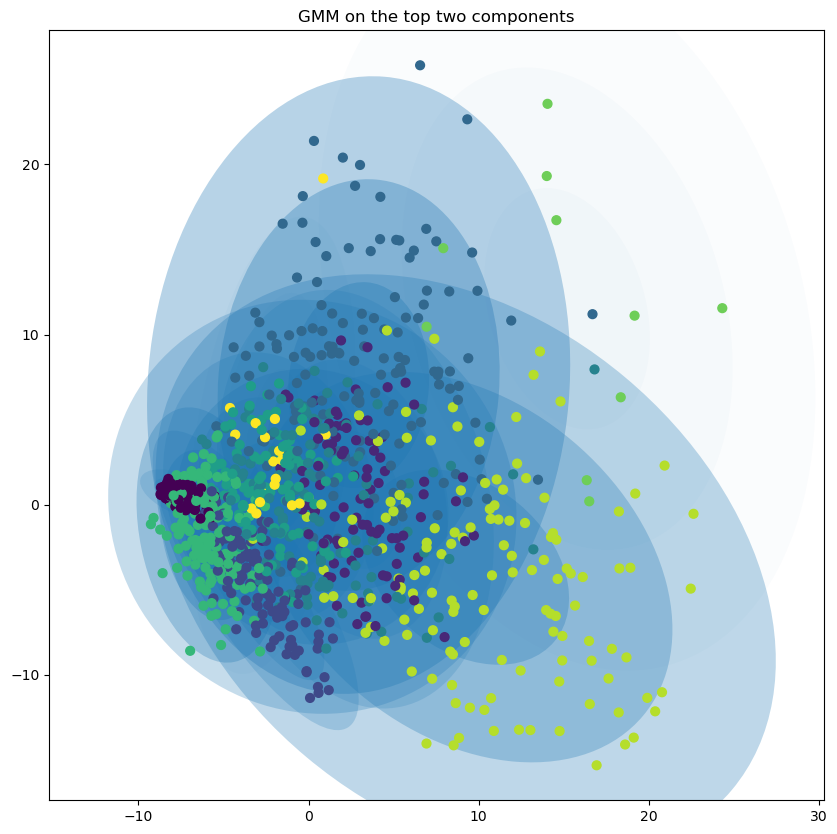

In [56]:
# Train GMM model with 10 components
gmm = GMModel(X_train_pca, 10)
n_iterations = 10000 # maximum number of iterations
prev_log_likelihood = 0 # previous log likelihood
threshold = 0.0001 # threshold for convergence
for i in range(n_iterations):
    log_likelihood = fitStep(gmm, X_train_pca)
    print("Iteration: {}".format(i+1), "Log-Likelihood: {}".format(log_likelihood))
    if abs(log_likelihood - prev_log_likelihood) < threshold: # check for convergence
        print("Converged at iteration: {}".format(i+1))
        break
    prev_log_likelihood = log_likelihood


# Plot the top two components coloring each point according to the cluster it belongs to
plt.figure(figsize=(10, 10))
plot_gmm(gmm, X_train_pca, label=True)
plt.title('GMM on the top two components')
plt.show()

> The model is trained using the Expectation-Maximization (EM) algorithm, which iteratively estimates the parameters of the Gaussian distributions.

> The EM algorithm consists of two main steps: the E-step and the M-step. In the E-step, the algorithm estimates the probability that each data point belongs to each Gaussian distribution by computing the posterior probabilities.

> In the M-step, the algorithm updates the parameters of the Gaussian distributions using the posterior probabilities computed in the E-step. Specifically, it updates the means, covariances, and weights of the Gaussian distributions. The means and covariances are updated based on the weighted average of the data points.

We have successfully implemented the GMM algorithm using the first five principal components of the PCA on the first 1000 images of the MNIST_train.csv dataset. We have also visualized the space spanned by the top two principal components, coloring each point according to their cluster and adding ellipses to represent the covariance and mean of each cluster. Note that we have used a convergence criterion for the GMM algorithm to ensure that our model had correctly converged (as indicated on an edStem forum post: https://edstem.org/us/courses/31518/discussion/2796914)

Overall, it seems that some cluster are well seperated from each other, while others are not. Our model seems to have a hard time separating the clusters...

1.3.2

In this subtask, we will use the class labels to visualize the space spanned by the top two principal components and color each point according to their class label. We will map the class labels to the best-fitting cluster index and print and discuss the result. We will use the log-likelihood of each mixture component evaluated at the images in each class to measure the fit quality. This will help us understand how well the GMM model is fitting to the data and whether the clusters are representative of the classes.

/var/folders/rl/d4jq2g217cv1hy_ssxxj4k0r0000gn/T/ipykernel_3920/2334194511.py:43: RuntimeWarning: invalid value encountered in divide
  weights = numerator / denominator


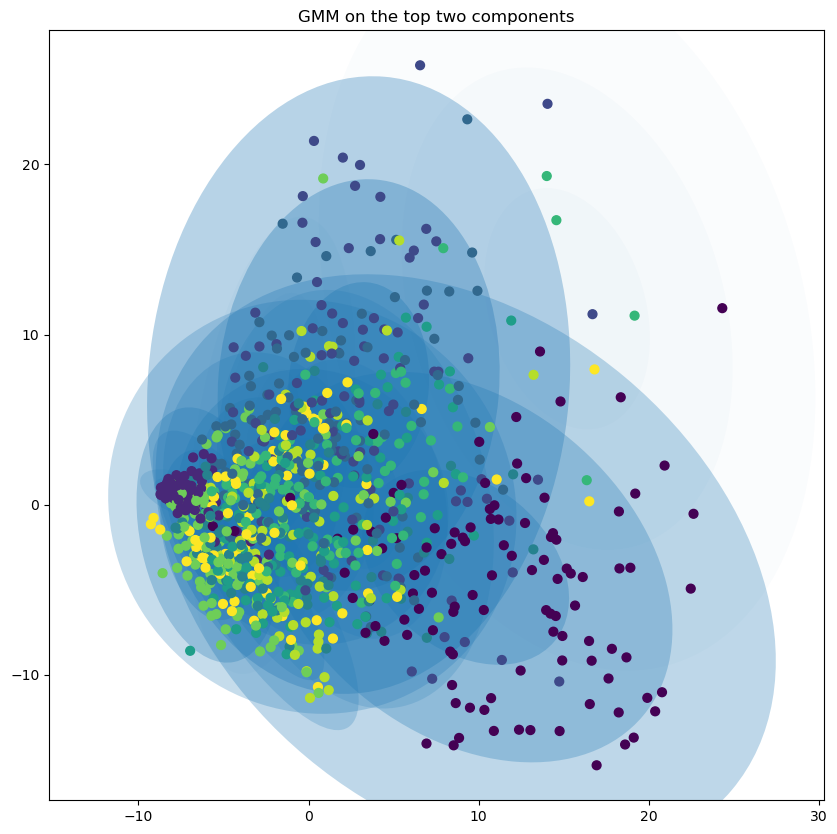

In [57]:
# Extract the true class labels for the first 1000 images
class_labels = train_data["label"].values[:1000]

# Plot the top two components coloring each point according to the class label it belongs to
plt.figure(figsize=(10, 10))
plot_gmm(gmm, X_train_pca, label=True, class_labels=class_labels)
plt.title('GMM on the top two components')
plt.show()

By plotting the space spanned by the top two principal components and coloring each point according to their class label, we notice that the clusters are not well separated from each other. This could show that the task seems to be very difficult to solve as the clusters are not well separated from each other with the top two principal components. The task might actually still be a bit easier as we use the first five principal components to fit our GMM model.

In [58]:
# Map the class labels to the best-fitting cluster index using the log-likelihood of each gaussian mixture component
class_to_cluster = {}
store_log_likelihood = np.zeros((1000, 10))
# Iterate over the class 0-9 and for each class determine the cluster with the highest loglikelihood
log_likelihood = np.array([multivariate_normal.logpdf(X_train_pca, mean=gmm.mu[j], cov=gmm.sigma[j]) for j in range(gmm.dim)])
for i in range(10):
    # Sum likelihood over images 
    sum_log_likelihood = np.sum(log_likelihood[:,class_labels == i], axis=1)
    print("Class: {}, Cluster: {}".format(i, np.argmax(sum_log_likelihood)))
    class_to_cluster[i] = np.argmax(sum_log_likelihood)
    print("Log-Likelihood: {}".format(np.max(sum_log_likelihood)))

Class: 0, Cluster: 8
Log-Likelihood: -1563.26940607721
Class: 1, Cluster: 0
Log-Likelihood: -976.7767844230531
Class: 2, Cluster: 3
Log-Likelihood: -1572.233760432969
Class: 3, Cluster: 3
Log-Likelihood: -1770.1810830336185
Class: 4, Cluster: 4
Log-Likelihood: -1231.27658697539
Class: 5, Cluster: 8
Log-Likelihood: -1522.2719895730288
Class: 6, Cluster: 3
Log-Likelihood: -1716.2308249546707
Class: 7, Cluster: 4
Log-Likelihood: -1958.1194622335672
Class: 8, Cluster: 8
Log-Likelihood: -1204.7497838716533
Class: 9, Cluster: 4
Log-Likelihood: -1167.036625906353


The mapping seems to be correct, as the log-likelihood of each mixture component evaluated at the images in each class is the highest for the class-cluster map that we have found. However, we notice that our model is still very sensible to initialisations: rerunning the code can give us very different cluster assignments. This is due to the fact that the EM algorithm is a local maximum search algorithm, which means that it can get stuck in local optima. 

On the other, we notice that there are some instances where multiple labels are associated with the same cluster, such as when multiple labels are assigned to cluster 0, while some clusters have no labels assigned to them. This indicates that our class-cluster map is not a one-to-one mapping and is not perfectly matching the actual labels.



1.3.3

 In this subtask, we will use the label-cluster index map to compute the cluster probabilities for each digit. For each class, we will visualize the space spanned by the top two components by coloring each point according to the cluster probability of the best-fitting cluster. We will interpret the result with respect to the uncertainty of the clustering. This will help us understand how confident we are in assigning each data point to a particular cluster.

/var/folders/rl/d4jq2g217cv1hy_ssxxj4k0r0000gn/T/ipykernel_3920/2334194511.py:43: RuntimeWarning: invalid value encountered in divide
  weights = numerator / denominator


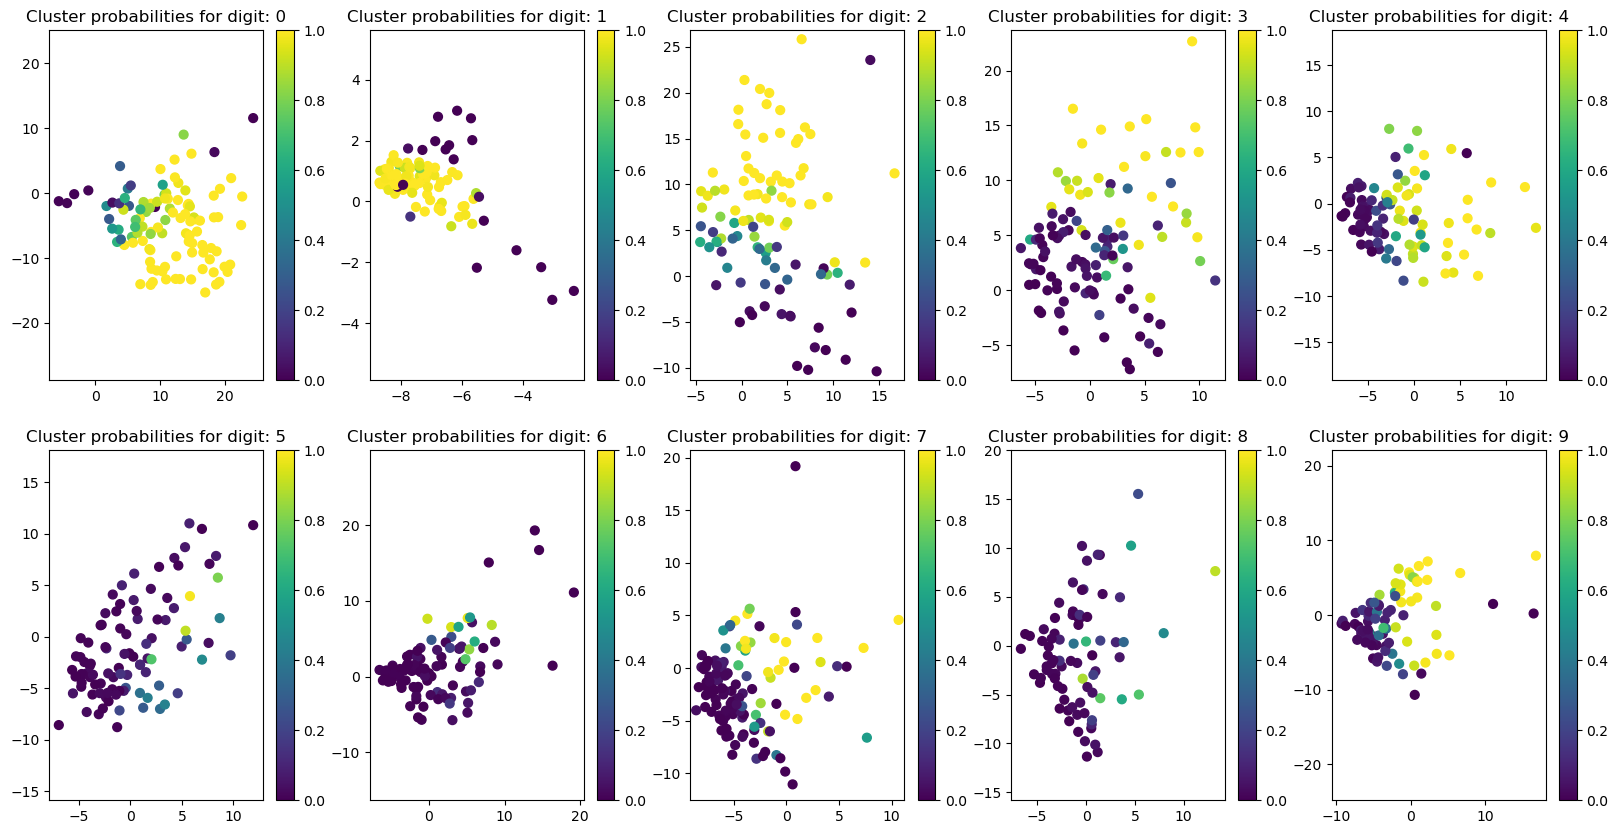

In [59]:
# Use the label-cluster index map to compute the cluster probabilities for each digit and plot for each class
# Make one plot of 10 subplots 
fig, axs = plt.subplots(2, 5, figsize=(20, 10))
probas = cluster_probabilities(gmm, X_train_pca)
for i, ax in enumerate(axs.flatten()):
    # Plot the top two components coloring each point according to the probabilities that it belongs to the cluster associated with digits number i
    plot_gmm(gmm, X_train_pca[class_labels==i,:], label=True, class_labels=probas[class_labels == i, class_to_cluster[i]], ax=ax, colorbar=True, ellipse=False)
    ax.set_title("Cluster probabilities for digit: {}".format(i))

The clustering probability for some labels, like label 0, shows that many data points have a high probability of belonging to the assigned cluster, while a few data points have a lower probability. However, for other labels, a large number of data points have a low probability of belonging to the assigned cluster. This shows that the clustering is not very confident in assigning some data points to a particular cluster. This was also shown previsously by the fact that the clusters are not well separated from each other.

The probability of a data point belonging to each cluster is calculated based on its distance from the mean and the covariance matrix of each cluster component. These probabilities, called posterior probabilities, are used to measure the uncertainty of the clustering. When a data point has high posterior probabilities for only one cluster, there is low uncertainty about its assignment. Conversely, when a data point has similar posterior probabilities for multiple clusters, there is high uncertainty about its assignment. This is demonstrated by data points that have a low probability for the cluster to which they were assigned, indicating that they were almost equally likely to be assigned to multiple clusters or that their assignment is not accurate.

We can see that overall our GMM model struggles to cluster correctly the data. A lot of the digits have a large number of points with very low cluster probabilities. This shows that the model is not very confident in assigning some data points to a particular cluster.

1.3.4

 In this subtask, we will retrain the GMM model with a reduced number of five and eight components and compute the map of the class labels to the best-fitting cluster. This will help us understand the effect of reducing the number of components on the clustering performance and whether we can still achieve good cluster assignments with a lower number of components.

Iteration: 1 Log-Likelihood: -1563.3817698932507
Iteration: 2 Log-Likelihood: -1573.1462568044728
Iteration: 3 Log-Likelihood: -1578.7044219481159
Iteration: 4 Log-Likelihood: -1582.5992404822618
Iteration: 5 Log-Likelihood: -1586.3227598713447
Iteration: 6 Log-Likelihood: -1590.9282216834454
Iteration: 7 Log-Likelihood: -1594.9532412098304
Iteration: 8 Log-Likelihood: -1597.6337540786083
Iteration: 9 Log-Likelihood: -1599.0545590985134
Iteration: 10 Log-Likelihood: -1599.5411400267499
Iteration: 11 Log-Likelihood: -1599.388768320814
Iteration: 12 Log-Likelihood: -1598.8090418713557
Iteration: 13 Log-Likelihood: -1597.953159113291
Iteration: 14 Log-Likelihood: -1596.9256735258555
Iteration: 15 Log-Likelihood: -1595.797435111428
Iteration: 16 Log-Likelihood: -1594.619675717419
Iteration: 17 Log-Likelihood: -1593.4333753611495
Iteration: 18 Log-Likelihood: -1592.272182962598
Iteration: 19 Log-Likelihood: -1591.162236311182
Iteration: 20 Log-Likelihood: -1590.1216918035966
Iteration: 21 L

/var/folders/rl/d4jq2g217cv1hy_ssxxj4k0r0000gn/T/ipykernel_3920/2334194511.py:43: RuntimeWarning: invalid value encountered in divide
  weights = numerator / denominator


Iteration: 76 Log-Likelihood: -1543.0521357238163
Iteration: 77 Log-Likelihood: -1543.0457693404887
Iteration: 78 Log-Likelihood: -1543.04041721015
Iteration: 79 Log-Likelihood: -1543.0359707423067
Iteration: 80 Log-Likelihood: -1543.0323288620077
Iteration: 81 Log-Likelihood: -1543.029398173259
Iteration: 82 Log-Likelihood: -1543.0270929324063
Iteration: 83 Log-Likelihood: -1543.0253348784868
Iteration: 84 Log-Likelihood: -1543.0240529590233
Iteration: 85 Log-Likelihood: -1543.023182982303
Iteration: 86 Log-Likelihood: -1543.0226672211234
Iteration: 87 Log-Likelihood: -1543.0224539877213
Iteration: 88 Log-Likelihood: -1543.022497195346
Converged at iteration: 88


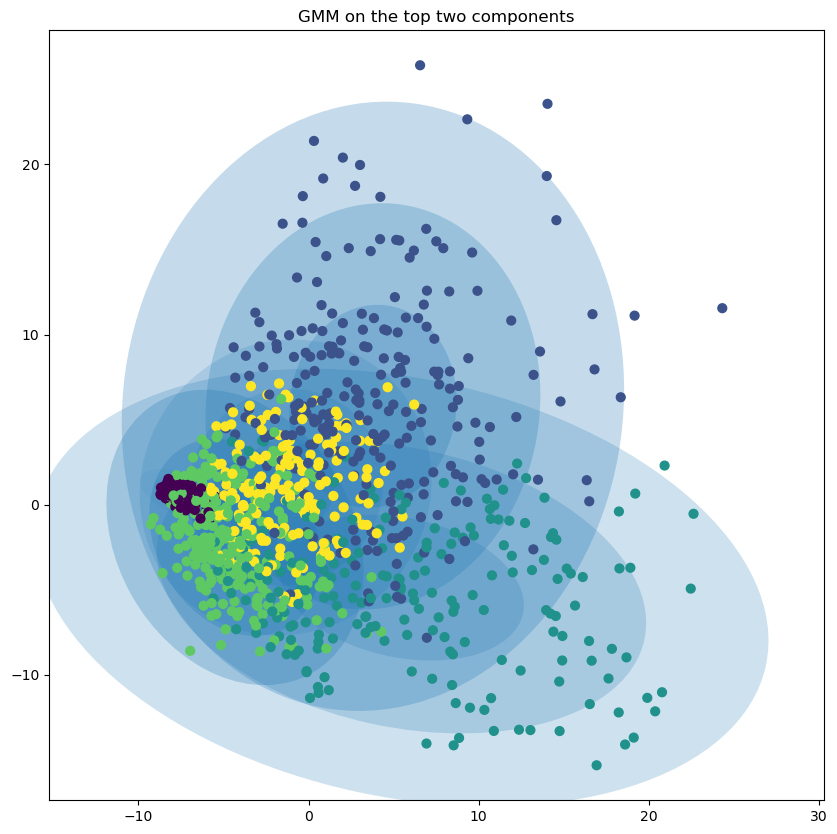

Class: 0, Cluster: 2
Log-Likelihood: -1632.6718698241846
Class: 1, Cluster: 0
Log-Likelihood: -966.1972981247037
Class: 2, Cluster: 1
Log-Likelihood: -1641.2790374049143
Class: 3, Cluster: 1
Log-Likelihood: -1837.2277223676506
Class: 4, Cluster: 3
Log-Likelihood: -1368.5088294467537
Class: 5, Cluster: 2
Log-Likelihood: -1450.5573112717607
Class: 6, Cluster: 1
Log-Likelihood: -1573.3449750328268
Class: 7, Cluster: 3
Log-Likelihood: -1954.0489113633125
Class: 8, Cluster: 2
Log-Likelihood: -1146.6278503244946
Class: 9, Cluster: 1
Log-Likelihood: -1403.7291972119651


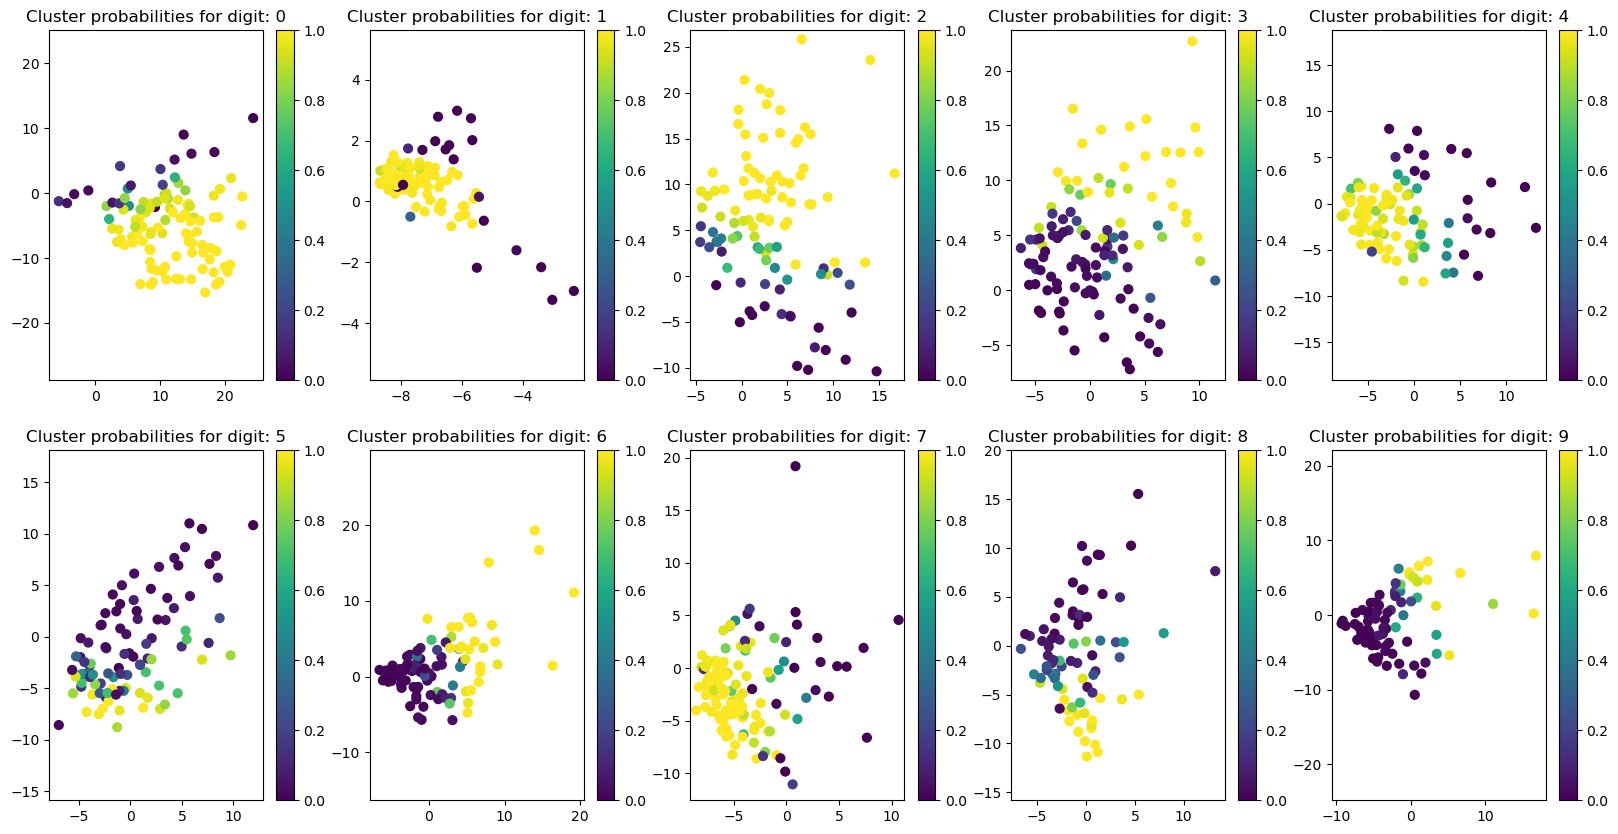

In [60]:
gmm = GMModel(X_train_pca, 5)
n_iterations = 10000
prev_log_likelihood = 0
threshold = 0.0001
for i in range(n_iterations):
    log_likelihood = fitStep(gmm, X_train_pca)
    print("Iteration: {}".format(i+1), "Log-Likelihood: {}".format(log_likelihood))
    if abs(log_likelihood - prev_log_likelihood) < threshold:
        print("Converged at iteration: {}".format(i+1))
        break
    prev_log_likelihood = log_likelihood# Train GMM model with 10 components


# Plot the top two components coloring each point according to the cluster it belongs to
plt.figure(figsize=(10, 10))
plot_gmm(gmm, X_train_pca, label=True)
plt.title('GMM on the top two components')
plt.show()

# Extract the true class labels for the first 1000 images
class_labels = train_data["label"].values[:1000]

# Map the class labels to the best-fitting cluster index using the log-likelihood of each gaussian mixture component
class_to_cluster = {}
store_log_likelihood = np.zeros((1000, 10))
# Iterate over the class 0-9 and for each class determine the cluster with the highest loglikelihood
log_likelihood = np.array([multivariate_normal.logpdf(X_train_pca, mean=gmm.mu[j], cov=gmm.sigma[j]) for j in range(gmm.dim)])
for i in range(10):
    # sum likelihood over images 
    sum_log_likelihood = np.sum(log_likelihood[:,class_labels == i], axis=1)
    print("Class: {}, Cluster: {}".format(i, np.argmax(sum_log_likelihood)))
    print("Log-Likelihood: {}".format(np.max(sum_log_likelihood)))
    class_to_cluster[i] = np.argmax(sum_log_likelihood)

# Use the label-cluster index map to compute the cluster probabilities for each digit and plot for each class
# Make one plot of 10 subplots 
fig, axs = plt.subplots(2, 5, figsize=(20, 10))
probas = cluster_probabilities(gmm, X_train_pca)
for i, ax in enumerate(axs.flatten()):
    # Plot the top two components coloring each point according to the probabilities that it belongs to the cluster associated with digits number i
    plot_gmm(gmm, X_train_pca[class_labels==i, :], label=True, class_labels=probas[class_labels==i,class_to_cluster[i]], colorbar=True, ax=ax, ellipse=False)
    ax.set_title("Cluster probabilities for digit: {}".format(i))

Iteration: 1 Log-Likelihood: -1682.4220750120007
Iteration: 2 Log-Likelihood: -1702.2087623534032
Iteration: 3 Log-Likelihood: -1716.0711099886285
Iteration: 4 Log-Likelihood: -1724.3991984010893
Iteration: 5 Log-Likelihood: -1729.654230042906
Iteration: 6 Log-Likelihood: -1734.192055314304
Iteration: 7 Log-Likelihood: -1739.3691555300738
Iteration: 8 Log-Likelihood: -1744.6932203263468
Iteration: 9 Log-Likelihood: -1749.3976858414776
Iteration: 10 Log-Likelihood: -1752.8626368151
Iteration: 11 Log-Likelihood: -1755.1792887857466
Iteration: 12 Log-Likelihood: -1756.8164695969372
Iteration: 13 Log-Likelihood: -1758.1039153474167
Iteration: 14 Log-Likelihood: -1759.310655113106
Iteration: 15 Log-Likelihood: -1760.5604241767273
Iteration: 16 Log-Likelihood: -1761.8627821262498
Iteration: 17 Log-Likelihood: -1763.2033826957334
Iteration: 18 Log-Likelihood: -1764.6053101072703
Iteration: 19 Log-Likelihood: -1766.0802966266622
Iteration: 20 Log-Likelihood: -1767.553354397031
Iteration: 21 Lo

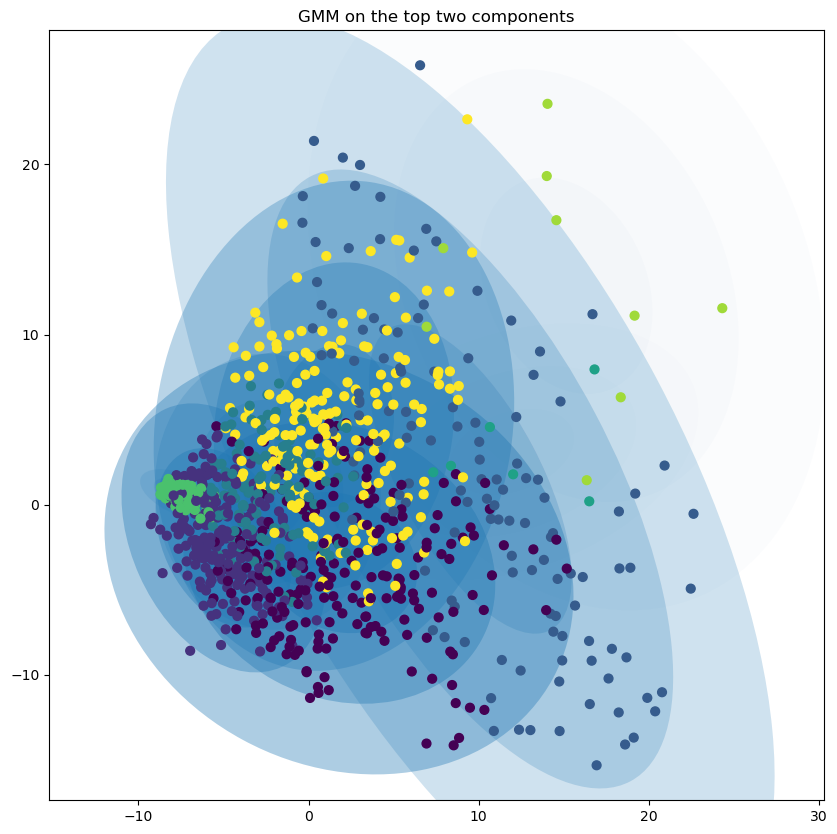

Class: 0, Cluster: 2
Log-Likelihood: -1751.8270944347664
Class: 1, Cluster: 5
Log-Likelihood: -971.5285083825664
Class: 2, Cluster: 2
Log-Likelihood: -1591.403093664016
Class: 3, Cluster: 7
Log-Likelihood: -1880.6050341692985
Class: 4, Cluster: 7
Log-Likelihood: -1489.3881311465072
Class: 5, Cluster: 0
Log-Likelihood: -1406.0742911415152
Class: 6, Cluster: 7
Log-Likelihood: -1631.5282266373122
Class: 7, Cluster: 0
Log-Likelihood: -2072.948957972614
Class: 8, Cluster: 0
Log-Likelihood: -1121.389615950855
Class: 9, Cluster: 7
Log-Likelihood: -1399.6930877331758


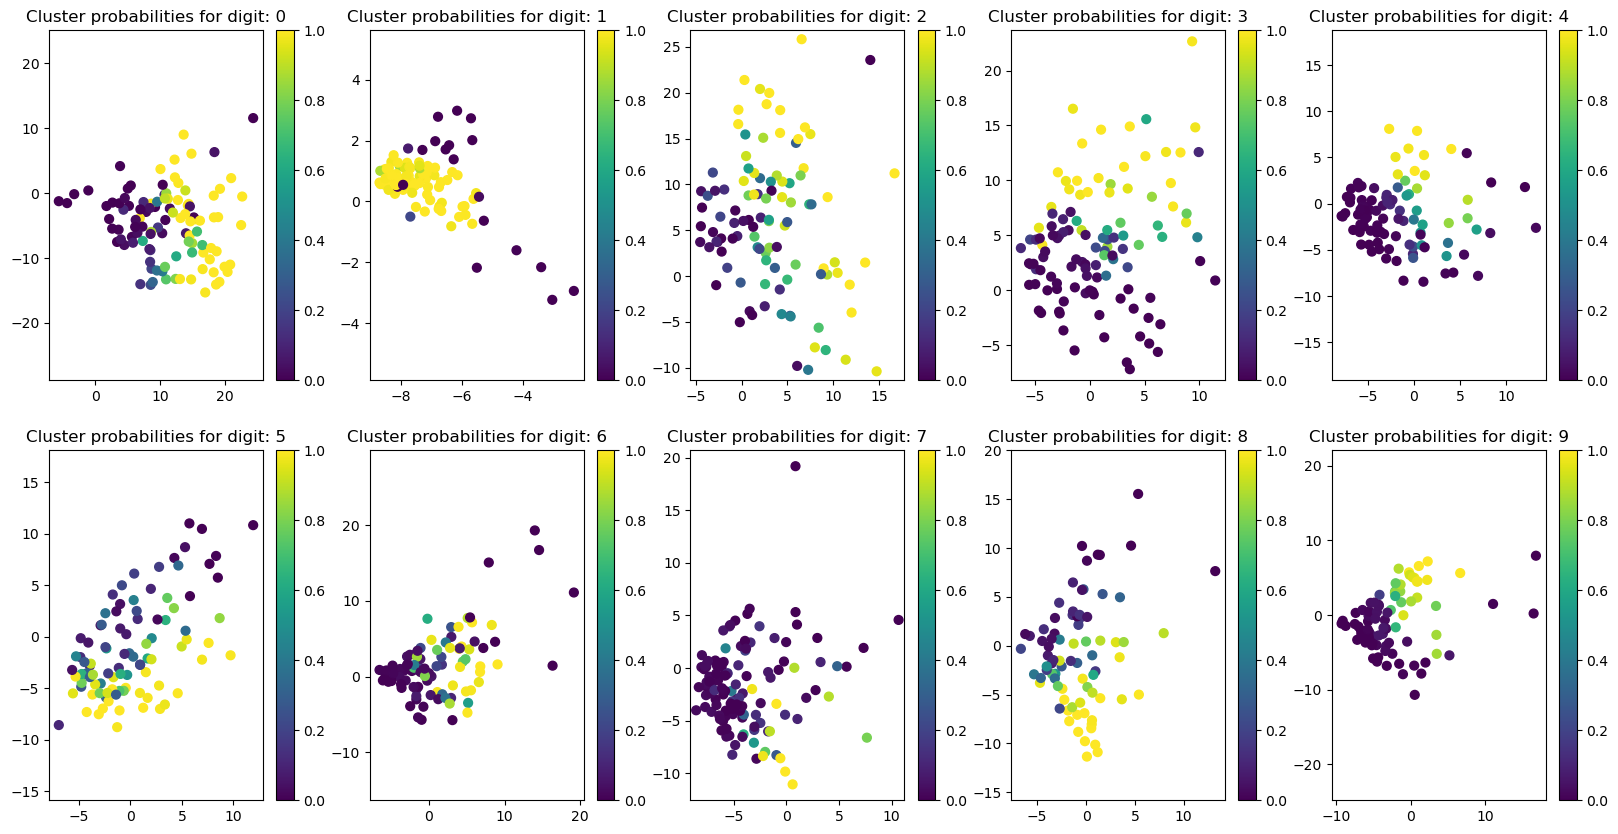

In [61]:
gmm = GMModel(X_train_pca, 8)
n_iterations = 10000
prev_log_likelihood = 0
threshold = 0.0001
for i in range(n_iterations):
    log_likelihood = fitStep(gmm, X_train_pca)
    print("Iteration: {}".format(i+1), "Log-Likelihood: {}".format(log_likelihood))
    if abs(log_likelihood - prev_log_likelihood) < threshold:
        print("Converged at iteration: {}".format(i+1))
        break
    prev_log_likelihood = log_likelihood


# Plot the top two components coloring each point according to the cluster it belongs to
plt.figure(figsize=(10, 10))
plot_gmm(gmm, X_train_pca, label=True)
plt.title('GMM on the top two components')
plt.show()

# Extract the true class labels for the first 1000 images
class_labels = train_data["label"].values[:1000]

# Map the class labels to the best-fitting cluster index using the log-likelihood of each gaussian mixture component
class_to_cluster = {}
store_log_likelihood = np.zeros((1000, 10))
# Iterate over the class 0-9 and for each class determine the cluster with the highest loglikelihood
log_likelihood = np.array([multivariate_normal.logpdf(X_train_pca, mean=gmm.mu[j], cov=gmm.sigma[j]) for j in range(gmm.dim)])
for i in range(10):
    # sum likelihood over images 
    sum_log_likelihood = np.sum(log_likelihood[:,class_labels == i], axis=1)
    print("Class: {}, Cluster: {}".format(i, np.argmax(sum_log_likelihood)))
    print("Log-Likelihood: {}".format(np.max(sum_log_likelihood)))
    class_to_cluster[i] = np.argmax(sum_log_likelihood)

# Use the label-cluster index map to compute the cluster probabilities for each digit and plot for each class
# Make one plot of 10 subplots 
fig, axs = plt.subplots(2, 5, figsize=(20, 10))
probas = cluster_probabilities(gmm, X_train_pca)
for i, ax in enumerate(axs.flatten()):
    # Plot the top two components coloring each point according to the probabilities that it belongs to the cluster associated with digits number i
    plot_gmm(gmm, X_train_pca[class_labels==i, :], label=True, class_labels=probas[class_labels==i, class_to_cluster[i]], colorbar=True, ax=ax, ellipse=False)
    ax.set_title("Cluster probabilities for digit: {}".format(i))

By retraining a GMM model with less components (5 and 8 components) and using the same methods to build the map betweem the class labels and the best-fitting cluster index as well as for the plotting of the cluster probabilities, we are able to compare our results.

 We can also compare the map between the class labels and the best-fitting cluster index. For both the GMM with 5 and 8 components, multiple class labels are assigned to the same cluster. This indicates that our class-cluster map is not a one-to-one mapping and is not perfectly matching the actual labels.

On the other hand, when inspecting the cluster probabilities plots, we notice that the GMM with 5 components seems to perform better and cluster better some digits (0, 1, and 2 for example). Indeed, the cluster probabilities for these digits are higher for these digits, which indicate that there is less uncertainty in the clustering. When inspecting the cluster probabilities for our GMM with 8 components, we observe that the cluster probabilities are lower for some digits, which indicates that there is more uncertainty in the clustering. The results seem to be closer to the ones we have previously obtained with the GMM with 10 components.
 

### Task 2: Clustering and graph-based analysis (35 marks)

In this second task, we work with a dataset reporting measurements of gene experession in different tumor samples. Our goal is to cluster the samples based on their gene expression profiles. Moreover, we will perform a graph-based analysis to study the structure of the network.

#### 2.1 Clustering (15 marks)
2.1.1

In this task, we are given a matrix of gene expression levels across 800 samples and we need to implement k-means clustering to find groups of samples with similar gene expression patterns. We will also code a function to compute the Calinski-Harabasz index of a given clustering, which measures the clustering quality based on a ratio of the between-cluster scatter matrix and the within-cluster scatter matrix. We need to use this function to determine the optimal k, running k-means for each k, for 5 different initialisations and averaging the corresponding Calinski-Harabasz indices. We also provide the size of the clusters found by k-means with the optimal k and plot the average Calinski-Harabasz index as a function of k.

In [62]:
# Load the dataset and have a look at the first 5 rows
df = pd.read_csv('gene_expression_data.csv')
print("Shape of the dataset:", df.shape)
print("Number of unique type:", len(df['Type'].unique()))
df.head(5)

Shape of the dataset: (800, 96)
Number of unique type: 5


Gene 0    Gene 1    Gene 2    Gene 3     Gene 4     Gene 5     Gene 6  \
0   9.796088  0.591871  0.591871  0.000000  11.420571  13.453759   4.411847   
1  10.070470  0.000000  0.000000  0.000000  13.085672  14.531863  10.462298   
2   8.970920  0.000000  0.452595  0.000000   8.263119   9.754908   8.964549   
3   8.524616  1.039419  0.434882  0.000000  10.798520  12.263020   7.440695   
4   8.047238  0.000000  0.000000  0.360982  12.283010  14.033759   8.719180   

     Gene 7     Gene 8     Gene 9  ...   Gene 86   Gene 87    Gene 88  \
0  5.412334  10.771613  10.225665  ...  5.974369  8.086513  12.727750   
1  9.832926  13.520312  13.968046  ...  0.000000  0.000000  11.197204   
2  9.948113   8.693773   8.776111  ...  3.907160  5.324101  11.487066   
3  8.062343   8.802083   9.237487  ...  4.296083  6.959747  12.974639   
4  8.831472   8.462073   8.211202  ...  0.000000  0.000000  11.337237   

     Gene 89    Gene 90    Gene 91   Gene 92    Gene 93    Gene 94  Type  
0  15.205717   6.438116   6.412577  0.000000   6.814730  13.618145  PRAD  
1  12.993933  10.800746  10.749811  0.000000  11.445610   0.000000  LUAD  
2  13.380596   6.656236  10.209734  0.000000   7.748830  12.759976  PRAD  
3  14.891812   6.030725   7.315648  0.434882   7.117924  12.353276  PRAD  
4  13.390061   5.989593   8.359671  0.000000   6.327545   0.000000  BRCA  

[5 rows x 96 columns]

In [63]:
# Value counts of type for better understanding of the dataset 
df['Type'].value_counts()

BRCA    300
KIRC    146
LUAD    141
PRAD    135
COAD     78
Name: Type, dtype: int64

In [64]:
# Building the training set (X_train)
# All columns except the last one
X_train = df.iloc[:,:-1].values
X_train.shape
# Standardize the data
X_train = (X_train - np.mean(X_train, axis = 0)) / np.std(X_train, axis = 0)

> Standardizing data is an important step in K-means clustering because it controls the variability of the dataset. Since K-means uses distance-based measurements to determine the similarity between data points, we have to standardize the data to have a mean of zero and a standard deviation of one. This is because almost always the features in any dataset would have different units of measurements. Standardization converts data into a specific range using a linear transformation which generates good quality clusters and improves the accuracy of clustering.

In [65]:
# Bulding the training set (y_train)
y_train = df['Type'].values
print("Shape of the training set:", X_train.shape)

Shape of the training set: (800, 95)


In [66]:
# Function to compute the Calinski-Harabasz index for a given clustering
def calinski_harabasz(X_labels, n_samples, n_features, centroids, k):
    # Compute the mean of the whole dataset
    mean = np.mean(X_labels, axis=0)[:n_features]
    # Build the clusters
    clusters =[]
    for i in range(k):
        cluster = np.array([x[:n_features] for x in X_labels if x[-1]==i])
        clusters.append(cluster)
    # Compute the BCSM
    BCSM = np.sum([len(clusters[j])*(np.linalg.norm(centroids[j] - mean))**2 for j in range(k)])
    # Compute the WCSM
    WCSM = np.sum([np.sum([(np.linalg.norm(x - centroids[j]))**2 for x in clusters[j]]) for j in range(k)])
    # Compute the CH index
    CH = (BCSM/(k-1))*((n_samples-k)/WCSM)
    return CH

> The Calinski-Harabasz index is given by:
> $$\text{CH}(k) = \frac{\text{SSB}(k)/(k-1)}{\text{SSW}(k)/(n-k)}$$
> where
> $$\text{SSB}(k)= \sum_{j=1}^k n_j(\bar{x}_j - \bar{x})^2$$
> $$\text{SSW}(k) = \sum_{j=1}^k \sum_{i=1}^{n_j} (x_{ij} - \bar{x}_j)^2 $$
> $$\bar{x}_j = \frac{1}{n_j} \sum_{i=1}^{n_j} x_{ij} $$
> $$\bar{x} = \frac{1}{n} \sum_{j=1}^k \sum_{i=1}^{n_j} x_{ij} $$


In [67]:
# K-means algorithm implementation (partly extracted from one of the coding tutorials)
def k_means(X, k, max_iter=50, verbose=True, centroids=None):
    n_samples, n_features = X.shape
    new_labels = np.zeros(len(X))
    difference = 0
    labels = np.random.randint(low=0, high=k, size=n_samples)
    X_labels = np.append(X, labels.reshape(-1,1), axis=1)
    if centroids is None:
        centroids = np.zeros((k, n_features))
        for i in range(k):
            centroids[i] = np.mean([x[:n_features] for x in X_labels if x[-1]==i], axis=0)

    # k-means algorithm
    for i in range(max_iter):
        if verbose:
            print('Iteration:', i)
        # distances: between data points and centroids
        distances = np.array([np.linalg.norm(X - c, axis=1) for c in centroids])
        # new_labels: computed by finding centroid with minimal distance
        new_labels = np.argmin(distances, axis=0)

        if (labels==new_labels).all():
            # labels unchanged
            labels = new_labels
            if verbose:
                print('Labels unchanged! Terminating k-means.')
            break
        else:
            # labels changed
            # difference: percentage of changed labels
            difference = np.mean(labels!=new_labels)
            if verbose:
                print('%4f%% labels changed' % (difference * 100))
            labels = new_labels
            for c in range(k):
                # update centroids by taking the mean over associated data points
                if (labels == c).any():
                    centroids[c] = np.mean(X[labels==c], axis=0)
    
    X_labels = np.append(X, labels.reshape(-1,1), axis=1)
    ch = calinski_harabasz(X_labels, n_samples, n_features, centroids, k)
    if verbose:
        print('Calinski-Harabasz score:', ch)
    
    return centroids, labels, difference, ch

# Run k-means for k = 5 for testing
centroids, labels, difference, ch = k_means(X_train, k=5, max_iter=50)
# Value counts of labels for testing
pd.Series(labels).value_counts()


Iteration: 0
74.750000% labels changed
Iteration: 1
13.625000% labels changed
Iteration: 2
2.250000% labels changed
Iteration: 3
1.125000% labels changed
Iteration: 4
0.625000% labels changed
Iteration: 5
0.625000% labels changed
Iteration: 6
0.250000% labels changed
Iteration: 7
0.125000% labels changed
Iteration: 8
Labels unchanged! Terminating k-means.
Calinski-Harabasz score: 208.9956978610391


4    303
1    218
0    140
3    138
2      1
dtype: int64

k = 2
k = 3
k = 4
k = 5
k = 6
k = 7
k = 8
k = 9
k = 10
k = 11
k = 12
k = 13
k = 14
k = 15
k = 16
k = 17
k = 18
k = 19
k = 20
k = 21
k = 22
k = 23
k = 24
k = 25
k = 26
k = 27
k = 28
k = 29


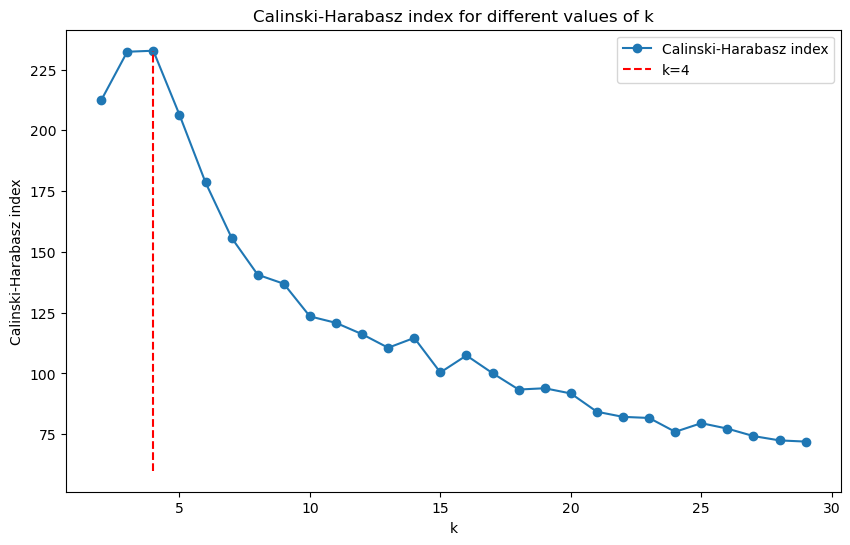

In [68]:
# Determine the optimal number of clusters k 
k_values = range(2, 30)
CH_values = []
for k in k_values:
    k_store = []
    print('k =', k)
    # Run k-means 5 times for each k and compute the average Calinski-Harabasz index (different initializations)
    for seed in range(1,6):
        np.random.seed(seed)
        centroids, labels, difference, ch = k_means(X_train, k=k, max_iter=30, verbose=False)
        k_store.append(ch)
    # Store average Calinski-Harabasz index for each k
    CH_values.append(np.mean(k_store))

# Plot the Calinski-Harabasz index for different values of k
plt.figure(figsize=(10, 6))
plt.plot(k_values, CH_values, label='Calinski-Harabasz index', marker='o')
plt.vlines(x=4, ymin=60, ymax=max(CH_values), color='red', label='k=4', linestyles='dashed')
plt.xlabel('k')
plt.ylabel('Calinski-Harabasz index')
plt.title('Calinski-Harabasz index for different values of k')
plt.legend()
plt.show()

> We notice that the optimal k i around $k=4$. Indeed the Calinski-Harabasz index is the highest for this value of k. We also notice that as k increases the Calinski-Harabasz index decreases.

In [69]:
# Refit the model using the optimal number of clusters k = 4
k = np.argmax(CH_values) + 2
print('Optimal number of clusters k =', k)
centroids, labels, difference, ch = k_means(X_train, k=k, max_iter=50, verbose=True)

Optimal number of clusters k = 4
Iteration: 0
71.875000% labels changed
Iteration: 1
32.125000% labels changed
Iteration: 2
11.375000% labels changed
Iteration: 3
6.250000% labels changed
Iteration: 4
4.375000% labels changed
Iteration: 5
2.750000% labels changed
Iteration: 6
2.375000% labels changed
Iteration: 7
3.125000% labels changed
Iteration: 8
2.375000% labels changed
Iteration: 9
1.000000% labels changed
Iteration: 10
1.750000% labels changed
Iteration: 11
1.625000% labels changed
Iteration: 12
1.250000% labels changed
Iteration: 13
0.625000% labels changed
Iteration: 14
0.250000% labels changed
Iteration: 15
0.125000% labels changed
Iteration: 16
0.250000% labels changed
Iteration: 17
0.125000% labels changed
Iteration: 18
0.250000% labels changed
Iteration: 19
0.375000% labels changed
Iteration: 20
0.125000% labels changed
Iteration: 21
0.250000% labels changed
Iteration: 22
0.250000% labels changed
Iteration: 23
0.125000% labels changed
Iteration: 24
0.125000% labels changed

In [70]:
# Size of the clusters
print('Size of the clusters:')
pd.Series(labels).value_counts()

Size of the clusters:


1    303
0    221
3    141
2    135
dtype: int64

We have successfully built our k-means algorithm as well as implemented a method that determines the optimal k using the Calinski-Harabasz index. We have also plotted the average Calinski-Harabasz index as a function of k.

This allows us to show that the optimal k is around 4, which is the number of clusters we have used to inspect the size of the clusters found by k-means. We can see that the size of the clusters is around 200 samples for each cluster which is a good result as our original dataset had a similar distribution. Moreover, it is also a good result as it means that there is not one cluster that is much larger than the others and holding most of the samples.

2.1.2

In this subtask, we need to assess the consistency between the clustering of the samples obtained in Task 2.1.1 and the assignment to these classes (tumour types). To this end, we need to code a function to compute the homogeneity score, a score measuring the extent to which the data points in one cluster belong to the same class (hence the homogeneity of the clusters). Based on this value, we need to discuss whether the clusters are consistent with the sample tumour types.

In [71]:
# Using the optimal number of clusters k = 4
k = 4
centroids, labels, difference, ch = k_means(X_train, k=k, max_iter=50, verbose=False)
# Value counts of labels
pd.Series(labels).value_counts()

3    346
2    176
0    141
1    137
dtype: int64

In [72]:
# Tranform label y to integers
y_train = pd.factorize(y_train)[0]

In [73]:
# Function that computes the homogeneity score using only numpy
def homogeneity_score(y_true, y_pred):
    # Compute the matrix of number of data points in each cluster and each class
    matrix = np.zeros((len(np.unique(y_true)), len(np.unique(y_pred))))
    for i in range(len(y_true)):
        matrix[y_true[i], y_pred[i]] += 1
    # Compute the entropy of the classes
    h_c = -np.sum((np.sum(matrix,axis=1)/len(labels))*np.log(np.sum(matrix,axis=1)/len(labels)))
    # Compute the entropy of the classes given the cluster
    helper = np.zeros((5,k))
    for i in range(len(matrix)):
        for j in range(len(matrix[i])):
            helper[i][j]= np.log(matrix[i][j]/np.sum(matrix,axis=0)[j], where=matrix[i][j]!=0)
    h_c_k = -np.sum(helper*(matrix/len(labels)))
    # Compute the homogeneity score
    homogeneity = 1 - h_c_k/h_c
    return homogeneity

print('Homogeneity score:', homogeneity_score(y_train, labels), '(k=4)')

Homogeneity score: 0.5872493380620825 (k=4)


In [74]:
# Using the number of clusters k = 5 which is the number of initial tumor types in the dataset to compare the results
k = 5
centroids, labels, difference, ch = k_means(X_train, k=k, max_iter=50, verbose=False)
# Value counts of labels
pd.Series(labels).value_counts()
# Compute the homogeneity score
print('Homogeneity score:', homogeneity_score(y_train, labels), '(k=5)')

Homogeneity score: 0.5993779265245605 (k=5)


>  We have computed the homogeneity score as well for $k=5$ for comparison as we know that there are initially 5 tumor types in our dataset.

Homogeneity score is a measure used to evaluate the quality of clustering results. It measures the extent to which all data points within a cluster belong to the same class or group. A homogeneity score of 1 indicates that all data points within a cluster belong to the same class.

For $k=4$, we have obtained a homogeneity score around 0.59, which is a good result. Indeed, this relatively high score indicates that the clusters are consistent with the sample tumour types. This is a good result as it means that the clustering is able to find clusters that are consistent with the sample tumour types. This result could be seen has even better as we know that the clusters cannot possibly be completely consistent with the tumour types as there are only 4 clusters fot 5 tumor types.

However, this result could also be contrasted by its comparison with the tested case with $k=5$. In fact, using $k=5$ we have obtained a homogeneity score around 0.65, which is higher than the one we have obtained with $k=4$. This remains still a slight improvement as both homogeneity score are close.

It is important to note that achieving a homogeneity score of 1 may not always be feasible or desirable in practice. For example, in a dataset with a high degree of overlap between classes, it may be difficult to separate the data points into completely homogeneous clusters.

#### 2.2 Graph-based analysis (20 marks)
2.2.1

In this first question, we will investigate the computation of the matrix of connected correlations between genes. This involves calculating the Pearson correlation coefficient between each pair of genes. The resulting matrix will be used as a similarity matrix to construct a graph that links genes. We will set the diagonal terms and all the terms whose absolute value is smaller than 0.75 to zero, which will result in a weighted adjacency matrix A. We will then use imshow to visualize the adjacency matrix A.

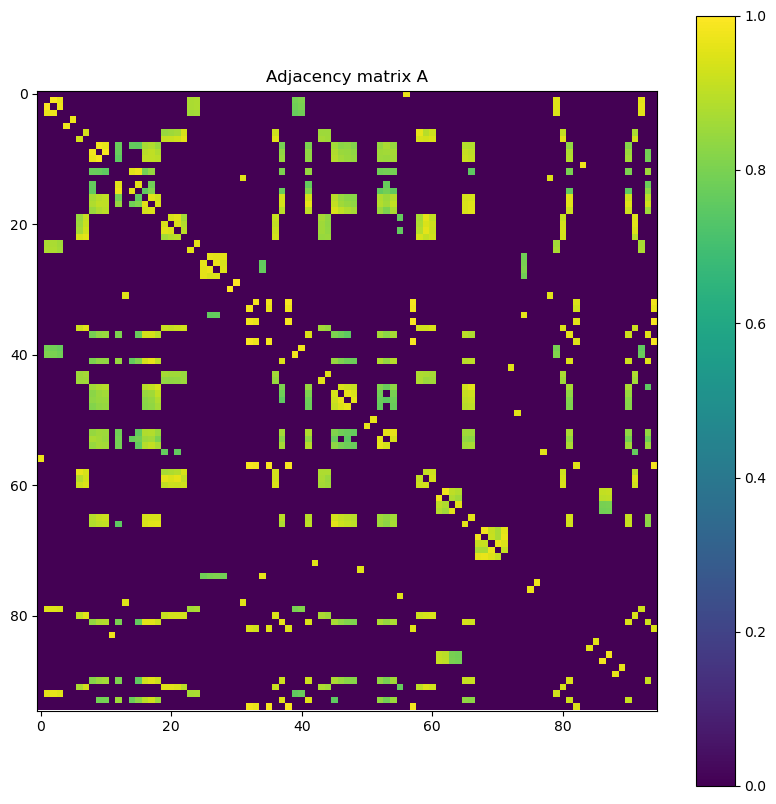

In [75]:
# Compute the matrix of connected correlations between genes
corr_matrix = np.corrcoef(X_train.T)
# Set to zero the diagonal terms
corr_matrix[np.diag_indices_from(corr_matrix)] = 0
# Set to zero the terms with absolute value below the threshold 0.75
corr_matrix[abs(corr_matrix)<0.75] = 0
A = corr_matrix
# Visualise the adjacency matrix A using imshow
plt.figure(figsize=(10, 10))
plt.imshow(A)
plt.title('Adjacency matrix A')
plt.colorbar()
plt.show()

We have successfully computed the matrix of connected correlations between genes and visualized the adjacency matrix A. We can notice that as expected the matrix is symmetric. We also observe that in this graph only some of the nodes would be connected (a lot of values are 0). On the other hand, we can see that we get bright patches of larger correlation among mostly dark areas (connected clusters).

2.2.2

In this second question, we compute the degree centrality of each node (gene) in the network, which is a measure of how important a node is in the network. We will then sort the genes in descending order by these values and print the index of the 5 top ranking genes.

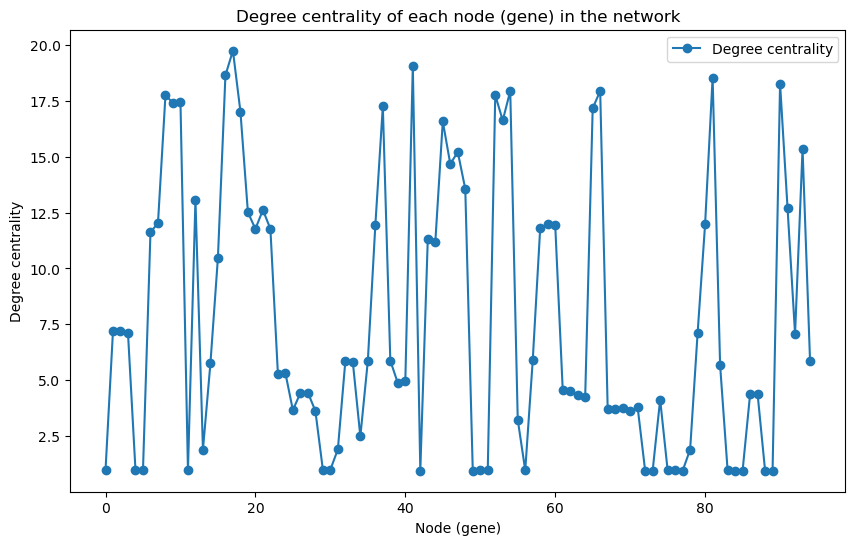

In [76]:
# Compute the degree centrality of each node (gene) in the network
degree = A.sum(axis=1) 
# Visualise the degree centrality of each node (gene) in the network
plt.figure(figsize=(10, 6))
plt.plot(degree, label='Degree centrality', marker='o')
plt.xlabel('Node (gene)')
plt.ylabel('Degree centrality')
plt.title('Degree centrality of each node (gene) in the network')
plt.legend()
plt.show()

> The degree centrality of a node is the number of edges connected to it. It is a measure of the importance of a node in a network. It is defined as the number of links connected to the node.

In [77]:
# Sort the genes in descending order by these values
sorted_genes = np.argsort(degree)[::-1]

In [78]:
# Print the index of the 5 top ranking genes
print('Top 5 genes:', sorted_genes[:5])
print('Top 5 degree centrality:', degree[sorted_genes[:5]])

Top 5 genes: [17 41 16 81 90]
Top 5 degree centrality: [19.73839866 19.04945567 18.64028395 18.53179044 18.2670517 ]


We can observe that there multiple different degree centrality values for different nodes. The values range from 0 to 20.

2.2.3

We now want to compute the symmetric normalized Laplacian of the graph, which is a matrix that describes the structure of the network. We will then derive its eigenvalues and eigenvectors, and plot the spectrum of eigenvalues. We will mark on the plot the gap between eigenvalues that, upon numerical rounding, have respectively zero and non-zero values. We will also provide the number r of zero eigenvalues and explain what they tell about the network structure.

In [79]:
# Compute the symmetric normalised Laplacian of the graph

# Define diagonal matrix of node degrees
weighted_degree = A.sum(axis=1) 

# Computing inverse square root vector of degree
weighted_degree_sqrt = 1.0 / np.sqrt(weighted_degree)

# Set a diagonal matrix of the inverse square root of degree
D_inv_sqrt = np.diag(weighted_degree_sqrt)

# Define the normalised Laplacian
L_norm = np.eye(A.shape[0]) - D_inv_sqrt.dot(A.dot(D_inv_sqrt))
print(L_norm.shape)

(95, 95)


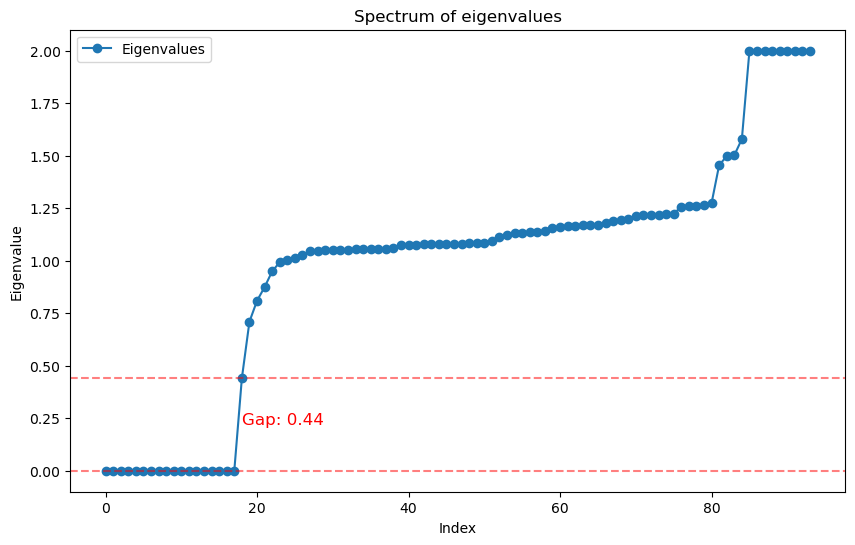

In [80]:
# Derive its eigenvalues and eigenvectors
eigenvals, eigenvecs = linalg.eigsh(L_norm, 94, which="SM", return_eigenvectors=True)

# Plot the spectrum of eigenvalues, marking on the plot the gap between eigenvalues that have respectively zero and non-zero values
plt.figure(figsize=(10, 6))
plt.plot(eigenvals, label='Eigenvalues', marker='o')
# add dotted line between eigenvalues zero and non-zero
plt.axhline(y=eigenvals[18], linestyle='--', color='r', alpha=0.5)
plt.axhline(y=0, linestyle='--', color='r', alpha=0.5)
# marking on the plot the gap
plt.text(18, eigenvals[18]/2, f"Gap: {eigenvals[18]:.2f}", fontsize=12, color='r')
plt.xlabel('Index')
plt.ylabel('Eigenvalue')
plt.title('Spectrum of eigenvalues')
plt.legend()
plt.show()

In [81]:
# Provide the number r of zero eigenvalues
r = 0
for i in range(len(eigenvals)):
    if eigenvals[i] < 1e-10:
        r += 1
print('Number of zero eigenvalues:', r)

Number of zero eigenvalues: 18


> We consider 1e-10 as the threshold for numerical rounding.

We have found that $r=18$. This means that there there are 18 connected components in our graph. In fact, as the eigenvectors $L_{norm}$ are directly related to the eigenvectors of $L$ through a similarity transformation, the number of connected components of the graph can be determined by counting the number of 0 eigenvalues of $L_{norm}$, which is equal to the number of 0 eigenvalues of $L$.

2.2.4

As indicated in the question guidelines, we will now form a new matrix T of size 95 x r by normalizing the rows of the matrix U to norm 1, where U is the 95 x r matrix containing the r eigenvectors of the symmetric normalized Laplacian corresponding to zero eigenvalues as columns. We will then apply k-means to the matrix T, varying k. We will use the normalized within-cluster distance and the elbow method to set the appropriate value of k. Finally, we will obtain the clustering corresponding to this k and provide an interpretation of such clusters.

In [82]:
# Get the eigenvectors corresponding to the r smallest eigenvalues
U = eigenvecs[:, :r]
print("Shape of U:", U.shape)

# Form a new matrix T by normalising the rows of U to norm 1
T = U / np.linalg.norm(U, axis=1, keepdims=True)

# Check that the rows of T have norm 1
print("Norm of rows of T:", np.linalg.norm(T, axis=1))

Shape of U: (95, 18)
Norm of rows of T: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


In [83]:
def normalised_within_cluster_distance(X, labels):
    # Compute the centroids of the clusters
    centroids = np.zeros((k, X.shape[1]))
    for i in range(k):
        centroids[i] = np.mean(X[labels==i], axis=0)
    # Compute the normalised within-cluster distance
    within_cluster_distance = 0
    for i in range(k):
        within_cluster_distance += np.sum(np.linalg.norm(X[labels==i]-centroids[i], axis=1))
    normalised_within_cluster_distance = within_cluster_distance
    return normalised_within_cluster_distance

> It is defined mathematcally as follows: $$ W(C) = \sum_{k=1}^{|C|} \sum_{i=1}^{n} \left(|x_{i} - c_k|^2 \cdot \delta_{k,l_i}\right) $$


/opt/anaconda3/envs/tf/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/envs/tf/lib/python3.9/site-packages/numpy/core/_methods.py:182: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
/opt/anaconda3/envs/tf/lib/python3.9/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


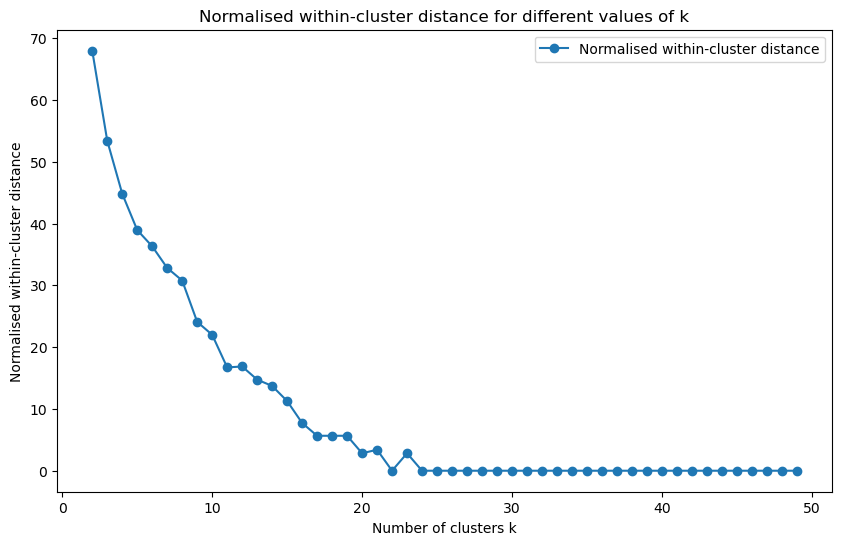

In [84]:
# Apply k-means clustering to the matrix T varying k using the normalised within-cluster distance
k_values = range(2, 50)
distance_values = []
for k in k_values:
    k_distance = []
    for i in range(50):
        centroids, labels, difference, ch = k_means(T, k=k, max_iter=100, verbose=False)
        k_distance.append(normalised_within_cluster_distance(T, labels))
    distance_values.append(np.min(k_distance))

# Plot the normalised within-cluster distance for different values of k
plt.figure(figsize=(10, 6))
plt.plot(k_values, distance_values, label='Normalised within-cluster distance', marker='o')
plt.xlabel('Number of clusters k')
plt.ylabel('Normalised within-cluster distance')
plt.title('Normalised within-cluster distance for different values of k')
plt.legend()
plt.show()

> We run k-means such that for each value in our range, we run the algorithm 50 times and compute the normalised within cluster distance. We then keep the minimum value for each value of k (as indicated in this edStem forum post: https://edstem.org/us/courses/31518/discussion/2801206). We then plot the average normalised within cluster distance as a function of k. 

We can easily notice that by the elbow method the optimal k is around 20. The curve is decreasing up to about $k=20$ then becomes relatively flat.

We thus run k-means with k=20 and obtain the following clusters:

In [85]:
# Using the elbow method to determine the optimal number of clusters
optimal_k = 20
print('Optimal number of clusters:', optimal_k)

# Apply k-means clustering to the matrix T using the optimal number of clusters
centroids, labels, difference, ch = k_means(T, k=optimal_k, max_iter=100, verbose=False)

print("Labels:", labels)

Optimal number of clusters: 20
Labels: [ 7 13 13 13  1  1 10 10 17 17 17 11 17 12 17 17 17 17 17 10 10 10 10 13
 13  0  0  0  0 14 14 12  3  3  0  3 10 17  3 13 13 17  3 10 10 17 17 17
 17 18  3  3 17 17 17 10  7  3 10 10 10  1  1  1  1 17 17  6  6  6  6  6
  3 18  0  9  9 10 12 13 10 17  3 11 12 12  1  1 15 15 17 10 13 17  3]


In [86]:
# Size of clusters 
pd.Series(labels).value_counts()

17    23
10    16
3     11
13     9
1      8
0      6
12     5
6      5
7      2
11     2
14     2
18     2
9      2
15     2
dtype: int64

In [87]:
# Indices of the genes in the biggest cluster
genes_in_biggest_cluster = np.where(labels==pd.Series(labels).value_counts().index[0])[0]
print('Indices of the genes in the biggest cluster:', genes_in_biggest_cluster)

Indices of the genes in the biggest cluster: [ 8  9 10 12 14 15 16 17 18 37 41 45 46 47 48 52 53 54 65 66 81 90 93]


> We notice that the genes with the biggest degree centrality are present in the biggest cluster identified by k-means.

In [88]:
# Number of empty clusters
empty_clusters = 0
for i in range(optimal_k):
    if len(T[labels==i]) == 0:
        empty_clusters += 1
print('Number of empty clusters:', empty_clusters)

Number of empty clusters: 6


By investigating the clusters obtained, we notice that these clusters are of very different sizes. In fact, the largest cluster has size 23 while multiple clusters have size 1 or 2. The largest cluster has size 23 and as the sizes of the clusters correspond to the sizes of the connected components, this cluster forms a highly correlated group.

Note that while doing this analysis, we could have noticed that when searching for the optimal k, multiple clustering that we have found actually contain empty clusters. This represent a problem for our analysis. We have tried to solve the issue by running the k-means algorithm multiple times and defining the centroids as points as suggested during the Q&A sessions. However, we have not been able to solve the issue as we still encountered this problem using this technique. 

2.2.5

We consider the biggest cluster identified in 2.2.4 and use the normalized Laplacian to perform spectral partitioning and derive a binary partition of the subgraph corresponding to this cluster. We will design a plot (or a set of plots) to visualize the magnitude of the network links within each partition and across the two partitions. We will also comment on the pattern we observe.

In [89]:
# Get the biggest cluster
biggest_cluster = np.argmax(np.bincount(labels))
print('Biggest cluster:', biggest_cluster, 'with', np.bincount(labels)[biggest_cluster], 'samples')
indices = np.where(labels==biggest_cluster)[0]
print('Indices of samples in the biggest cluster:', indices)

Biggest cluster: 17 with 23 samples
Indices of samples in the biggest cluster: [ 8  9 10 12 14 15 16 17 18 37 41 45 46 47 48 52 53 54 65 66 81 90 93]


> We recompute an adjancency matrix for this cluster as well as the normalized Laplacian matrix. We then compute the eigenvalues and eigenvectors of the subset normalized Laplacian matrix. We then compute the first two eigenvectors and use them to perform spectral partitioning. We then plot the magnitude of the network links within each partition and across the two partitions.

In [90]:
A_subset = A[indices, :][:, indices]
print('Shape of A_subset:', A_subset.shape)

# Compute the symmetric normalised Laplacian of the graph
weighted_degree_subset = A_subset.sum(axis=1) 

# Create diagonal matrix of degree
D_subset = np.diag(weighted_degree_subset)

weighted_degree_sqrt_subset = 1.0 / np.sqrt(weighted_degree_subset)

# set a diagonal matrix of the inverse square root of degree
D_inv_sqrt_subset = np.diag(weighted_degree_sqrt_subset)

# define the normalised Laplacian
L_norm_subset = np.eye(A_subset.shape[0]) - D_inv_sqrt_subset.dot(A_subset.dot(D_inv_sqrt_subset))
print("Shape of L_norm_subset:", L_norm_subset.shape)

Shape of A_subset: (23, 23)
Shape of L_norm_subset: (23, 23)


In [91]:
# Perform spectral partitioning using the normalised Laplacian of the graph L_norm
# return the smallest magnitude eigenvectors and eigenvalues
eigenvals, eigenvecs = linalg.eigsh(L_norm_subset, 2, which="SM", return_eigenvectors=True)

# printing the eigenvalues
print('The first eigenvalue is: {}'.format(eigenvals[0]))
print('The second eigenvalue is: {}'.format(eigenvals[1]))


# extract the second eigenvector
second_eigenvector = eigenvecs[:,1]

spectral_partition = second_eigenvector
spectral_partition[spectral_partition<0] = 0
spectral_partition[spectral_partition>0] = 1

print("Spectral partition:", spectral_partition)

The first eigenvalue is: 1.5334625835097244e-16
The second eigenvalue is: 0.7098248164224772
Spectral partition: [0. 1. 1. 0. 0. 0. 1. 0. 1. 0. 0. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 0.]


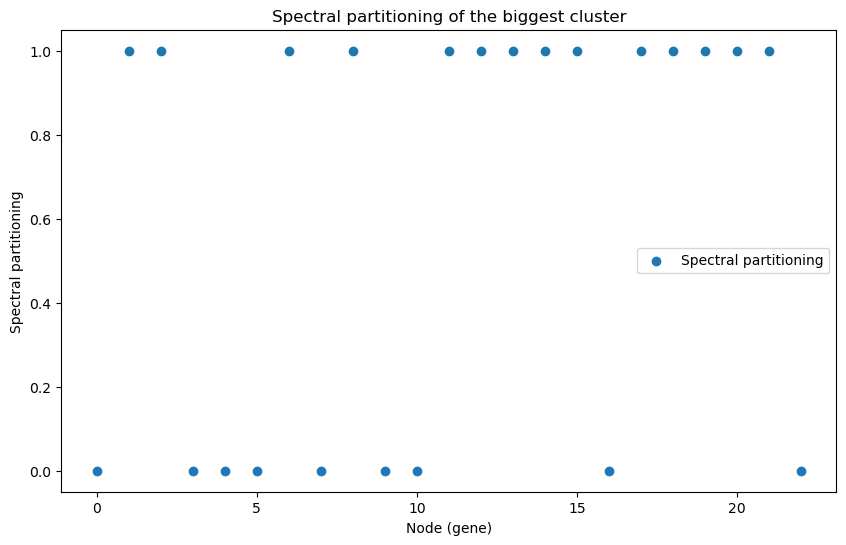

In [92]:
# Design a plot to visualise the magnitude of the network links within each partition and accross the two partitions
plt.figure(figsize=(10, 6))
plt.scatter(range(len(spectral_partition)), spectral_partition, label='Spectral partitioning', marker='o')
plt.xlabel('Node (gene)')
plt.ylabel('Spectral partitioning')
plt.title('Spectral partitioning of the biggest cluster')
plt.legend()
plt.show()

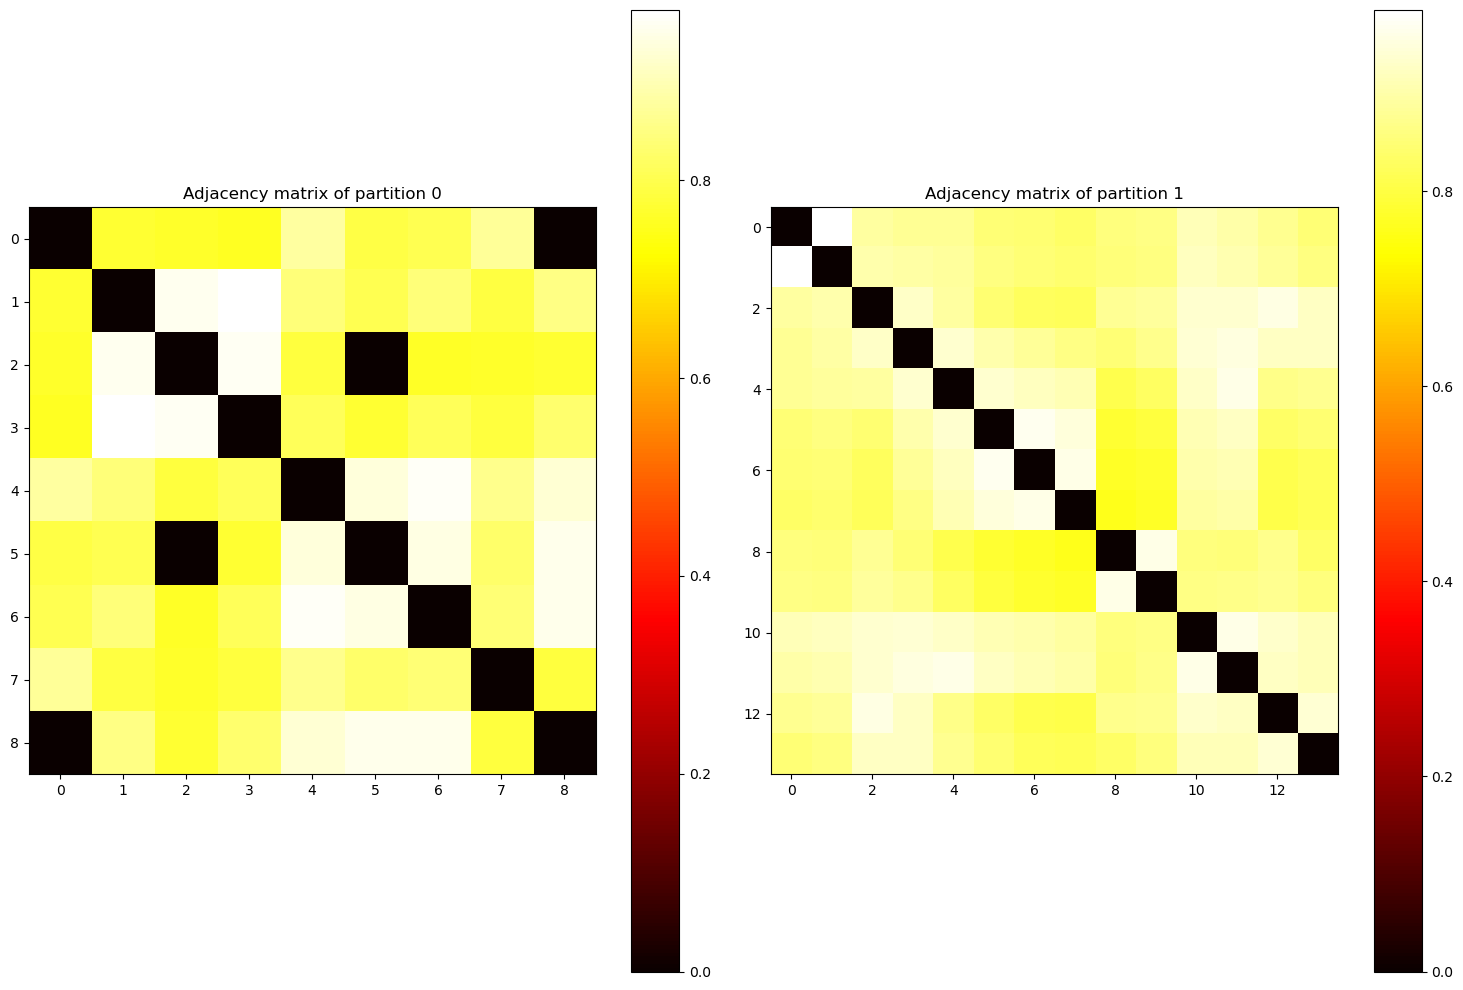

In [93]:
# Get the adjacency matrices of the two partitions
A0 = A_subset[spectral_partition==0][:, spectral_partition==0]
A1 = A_subset[spectral_partition==1][:, spectral_partition==1]

matrices = [A0, A1]
plt.figure(figsize=(15, 10))
for i in range(2):
    plt.subplot(1,2,i+1)
    plt.imshow(matrices[i], cmap='hot', interpolation='nearest')
    plt.colorbar()
    plt.title('Adjacency matrix of partition {}'.format(i))

plt.tight_layout()

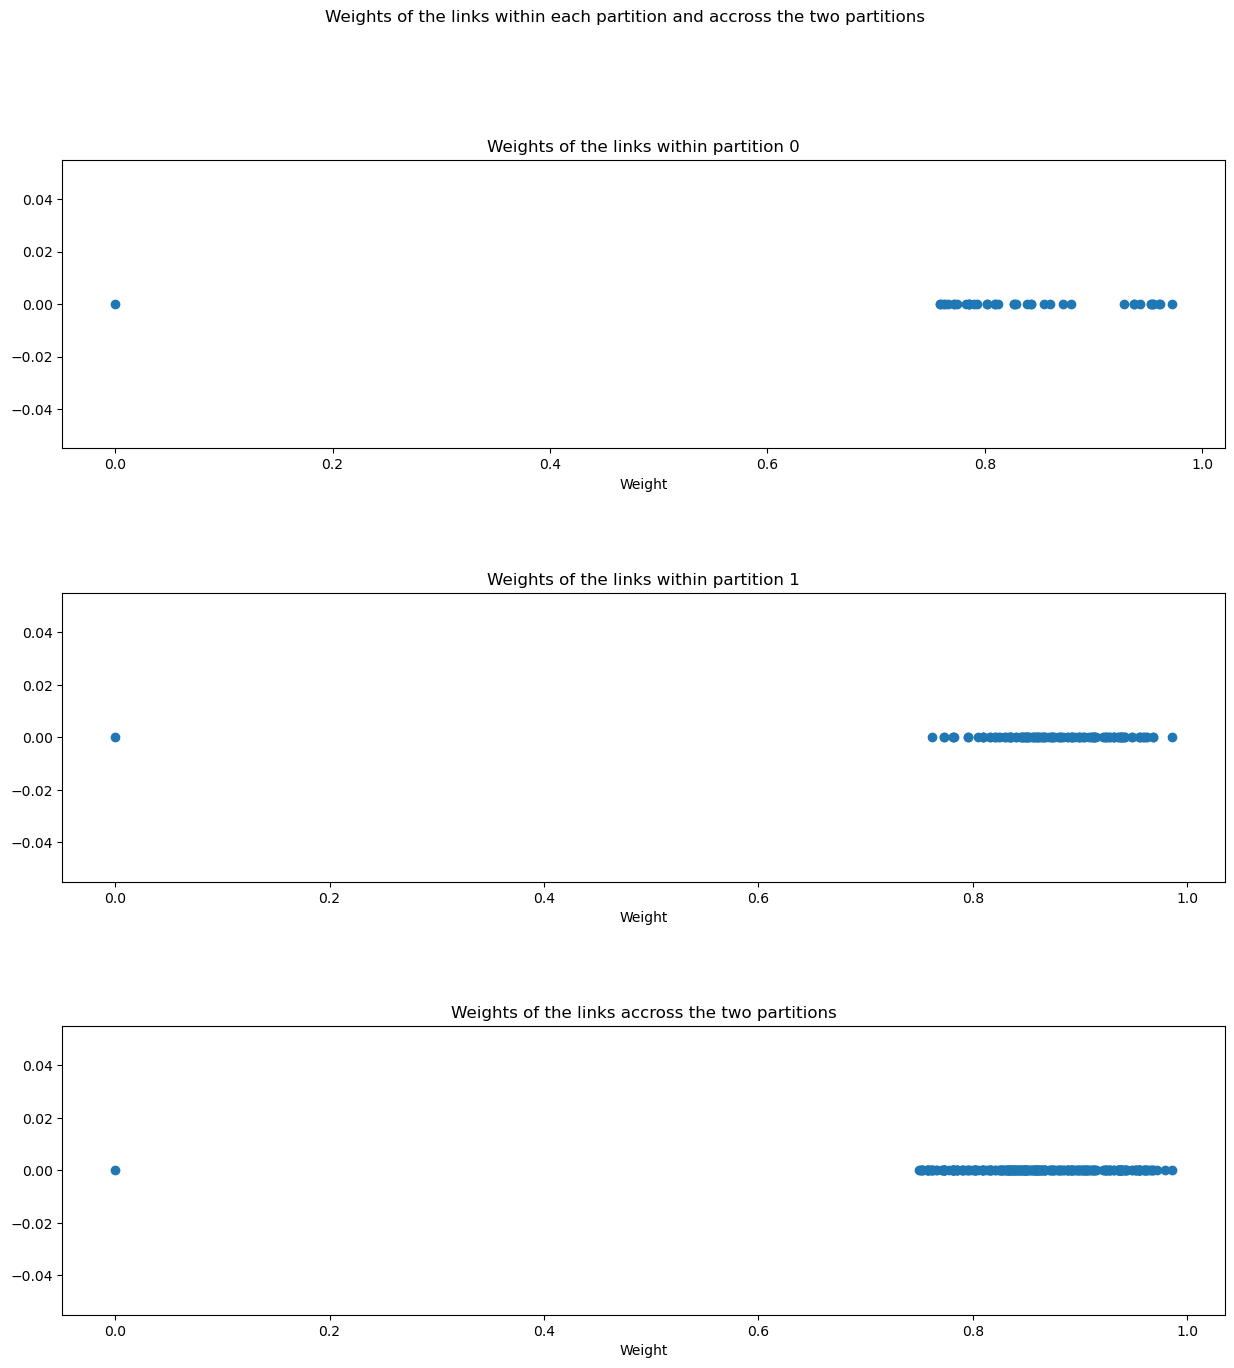

In [94]:
# Get the weights of the links within each partition and accross the two partitions
w = [np.unique(A0.flatten()), np.unique(A1.flatten()), np.unique(A_subset.flatten())]

# Plot the weights of the links within each partition and accross the two partitions
plt.figure(figsize=(15, 15))
plt.subplots_adjust(hspace=0.5)
for i in range(3):
    plt.subplot(3,1,i+1)
    plt.scatter(x=w[i], y=np.zeros(len(w[i])), marker='o')
    plt.xlabel('Weight')
    if i ==2:
        plt.title('Weights of the links accross the two partitions')
    else:
        plt.title('Weights of the links within partition {}'.format(i))

plt.suptitle('Weights of the links within each partition and accross the two partitions')
plt.show()

First of all, we have plotted the adjacency matrix of the partitions. We notice that both matrices have very high values for most points. This suggests that the partition could not be performing well because most of the points are strongly correlated.

Moreover, by plotting the weights of the links between the partitions we notice that if the partition was carried out efficiently, we would expect the weights within the partitions to be around 1 and across the partition to be near 0. This would indicate that the points are not strongly correlated as we separate them. However, most of the points in both the partitions and cross partitions show a high level of correlation, with a value greater than 0.7. Although we have set values less than 0.75 to 0, the histogram of the cross partition still shows very few 0 values. This suggests that the partition is not performing well. Nonetheless, the partition is particularly poor as the cluster mainly has strongly correlated values.

2.2.6

Finally, we consider the subgraph from 2.2.5 and compute the degree centrality of the nodes in this subgraph. We will print the index of the 5 top-ranking ones (like in 2.2.2). We will then compare the degree centrality values with the ones obtained for the full graph in 2.2.2, and explain the results of this comparison.

In [95]:
# Compute the degree centrality of the nodes
degree = A.sum(axis=1)
# Sort the degree centrality
sorted_degree_centrality = np.sort(degree)[::-1]

# Compute the degree centrality of the nodes in the biggest cluster
degree_subset = A_subset.sum(axis=1)
# Sort the degree centrality
sorted_degree_centrality_subset = np.sort(degree_subset)[::-1]

# Print the index of the 5 top ranking genes
print("=== Degree centrality for the whole matrix A ===")
print('Top 5 genes for the whole matrix A:', np.argsort(degree)[-5:][::-1])
print('Top 5 degree centrality for the whole matrix A:', sorted_degree_centrality[:5])

print("\n")

# Print index of the 5 top ranking genes of the cluster and their values
print("=== Degree centrality for the biggest cluster ===")
print('Indices of the top 5 genes for the biggest cluster (subset indices):', np.argsort(degree_subset)[-5:][::-1])
print('Top 5 genes for the biggest cluster (true indices):', indices[np.argsort(degree_subset)[-5:][::-1]])
print('Top 5 degree centrality for the biggest cluster:', sorted_degree_centrality[:5])

=== Degree centrality for the whole matrix A ===
Top 5 genes for the whole matrix A: [17 41 16 81 90]
Top 5 degree centrality for the whole matrix A: [19.73839866 19.04945567 18.64028395 18.53179044 18.2670517 ]


=== Degree centrality for the biggest cluster ===
Indices of the top 5 genes for the biggest cluster (subset indices): [ 7 10  6 20 21]
Top 5 genes for the biggest cluster (true indices): [17 41 16 81 90]
Top 5 degree centrality for the biggest cluster: [19.73839866 19.04945567 18.64028395 18.53179044 18.2670517 ]


We have computed the degree centrality for both our initial matrix A and for the matrix $A_{subset}$. We observe that the top 5 nodes with the highest degrees are the same. This implies that the most connected nodes are located within the largest cluster. This is expected as it is the largest identified cluster with a size of 23. 

On the other hand, the degree centralities of these nodes remain the same in the subgraph as these nodes are not connected to other nodes in the initial graph. This is valid because each cluster is a connected component.

## Task 3: Mastery component  (25 marks)

#### 3.1 Betweenness Centrality (10 marks)

Task 3.1 is focused on computing the betweenness centrality of each node in an unweighted graph and comparing the results with the degree centrality obtained in Task 2.2.

3.1.1

 In this task, we are asked to use the unweighted version of the graph from Task 2.2 and compute the betweenness centrality of each node using Brandes' algorithm. We need to code a function to compute the betweenness centrality. We use the skeleton function contained in the file skeleton_betweenness.ipynb to guide us through the implementation of Brandes' algorithm. After computing the betweenness centrality, we need to discuss our results and compare the ranking of nodes by betweenness centrality with the one obtained by degree centrality in Task 2.2.

In [96]:
def betweenness_centrality(A):
    '''Implements Brandes' algorithm for computing betweenness centrality in unweighted and undirected graphs.
    Input: an adjacency matrix `A` of size `n x n` where `n` is the number of nodes
    Output: a vector of betweenness centralities `bc` of length `n`
    Remark:
    If `sigma(i, j)` is the number of shortest paths from node `i` to node `j`, and `sigma(i, j | k)` is the 
    number of those shortest paths that pass through node `k`, then define the ratio 
            `delta(i, j | k) = sigma(i, j | k)/sigma(i, j)`
    and its aggregation over target nodes `j` as
            `delta(i | k) = \sum_j delta(i, j | k)`
    and further aggregation over source nodes `i` as the betweenness centrality of node `k`
            `bc(k) = \sum_i delta(i | k)`
    Brandes (2001) provides an efficient algorithm of estimating aggregated ratios `delta(i | k)` via breadth
    first search (BFS) and dynamic programming (DP). 
    See https://doi.org/10.1080/0022250X.2001.9990249
    '''
    
    # some input checking for undirected unweighted graphs
    assert A.shape[0] == A.shape[1], 'Adjacency matrix must be square'
    
    # number of nodes
    n = A.shape[0]
    
    # initialise a vector of betweenness centrality for all nodes
    bc = np.zeros(n)
    
    # for every node `i` compute its contribution to the betweenness centrality of all other nodes
    for i in range(n):
        # compute the lengths and counts of shortest paths from `i` to all other nodes via breadth first search (BFS)
        # initialise a stack of nodes that have been visited in the BFS
        S = []
        
        # initialise the queue of nodes that will be visited in the BFS
        Q = [i]
        
        # initialise the list of nodes that precede `j` on a shortest path from `i` to every node `j`
        P = [[] for _ in range(n)]
        
        # initialise the length of shortest paths, a.k.a. "distance", from `i` to every node `j`
        d = np.full(n, np.inf)
        d[i] = 0
        
        # initialise the number of shortest paths from `i` to every node `j`
        sigma = np.zeros(n)
        sigma[i] = 1
        
        # perform BFS until all nodes that are reachable from `i` have been reached
        while len(Q) > 0:

            # pop the next node `k` from the queue to be visited
            k = Q.pop(0)

            # push to the stack of visited nodes
            S.append(k)

            
            # for each node `j` that is a neighbour of node `k`
            for j in range(n):
                
                # if node `j` has been encountered for the first time
                if A[k][j]:
                    if np.isinf(d[j]):
                        # push `j` to the queue of nodes to be visited
                        Q.append(j)
                    
                        # update the distance from `i` to `j`
                        d[j] = d[k] + 1
                    
                    # if node `k` immediately precedes node `j` on a shortest path from `i` to `j`    
                    if d[k] + 1 == d[j]: 
                        
                        # update the number of shortest paths from `i` to `j`   
                        sigma[j] += sigma[k]
                        
                        # include `k` in the list of nodes that immediately precede `j` on shortest paths from `i` to `j`
                        P[j].append(k)
                    
        # accumulate aggregated ratios via dynamic programming (DP)
        # initialise aggregated ratios
        delta = np.zeros(n)
        
        # iterate over each vertex in the reverse order of being visited i.e. nodes farthest from `i` first
        while len(S) > 0:
            
            # pick the most recently visited node `j` from the stack
            j = S.pop()
            
            # go through the list of all nodes `k` that precede `j` on the shortest path from `i` to `j`
            for k in P[j]:
                # update aggregated ratios of `k` using the key result in Theorem 6 of Brandes (2001)
                delta[k] += (sigma[k] / sigma[j]) * (1 + delta[j])
            
            # update the contribution of shortest paths from `i` to the betweenness of node `j`
            if j != i:
                bc[j] += delta[j]
    
    # correct for undirected networks
    bc = bc/2
    
    return bc

In [97]:
# Copy the original adjacency matrix
A_bc = A.copy()
# Set all values bigger than 0 to 1
A_bc[A_bc > 0] = 1

# Compute the betweenness centrality of the nodes
betweenness = betweenness_centrality(A_bc)
print("Betweenness centrality of the nodes:\n ", betweenness)


Betweenness centrality of the nodes:
  [ 0.          0.8         0.8         0.8         0.          0.
  0.          0.          4.38976579  0.92769175  0.92769175  0.
  1.66269841  0.          0.05555556  0.91269841  1.78653014  4.66033966
  0.46224054  7.33333333  0.          7.33333333  0.          0.
  0.          0.          0.66666667  0.66666667  0.          0.
  0.          0.          0.          0.          0.          0.
  0.          1.3645313   0.          0.          0.          4.66033966
  0.          0.          0.          0.46224054  0.0625      0.19166667
  0.          0.          0.          0.          1.78653014  3.24330114
  1.78653014 14.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.46224054
  0.92769175  0.          0.          0.          0.          0.
  0.          0.          0.66666667  0.          0.          0.
  0.          0.8         0.          1.78653014  0.          0.
  0.       

> Betweenness centrality is a measure of the importance of a node in a network or graph, based on the number of shortest paths that pass through that node. It is a way of quantifying how much a node acts as a bridge between other nodes in the network.
>
> Nodes with high betweenness centrality are important for maintaining the connectivity of the network. They are often critical for communication and information flow between different parts of the network, and their removal can significantly disrupt the network's function or structure.
>
> Betweenness centrality and degree centrality can both be useful in understanding the structure and function of a network, but they capture different aspects of node importance. While degree centrality reflects a node's direct connections, betweenness centrality takes into account the indirect connections that a node enables by acting as a bridge between other nodes.

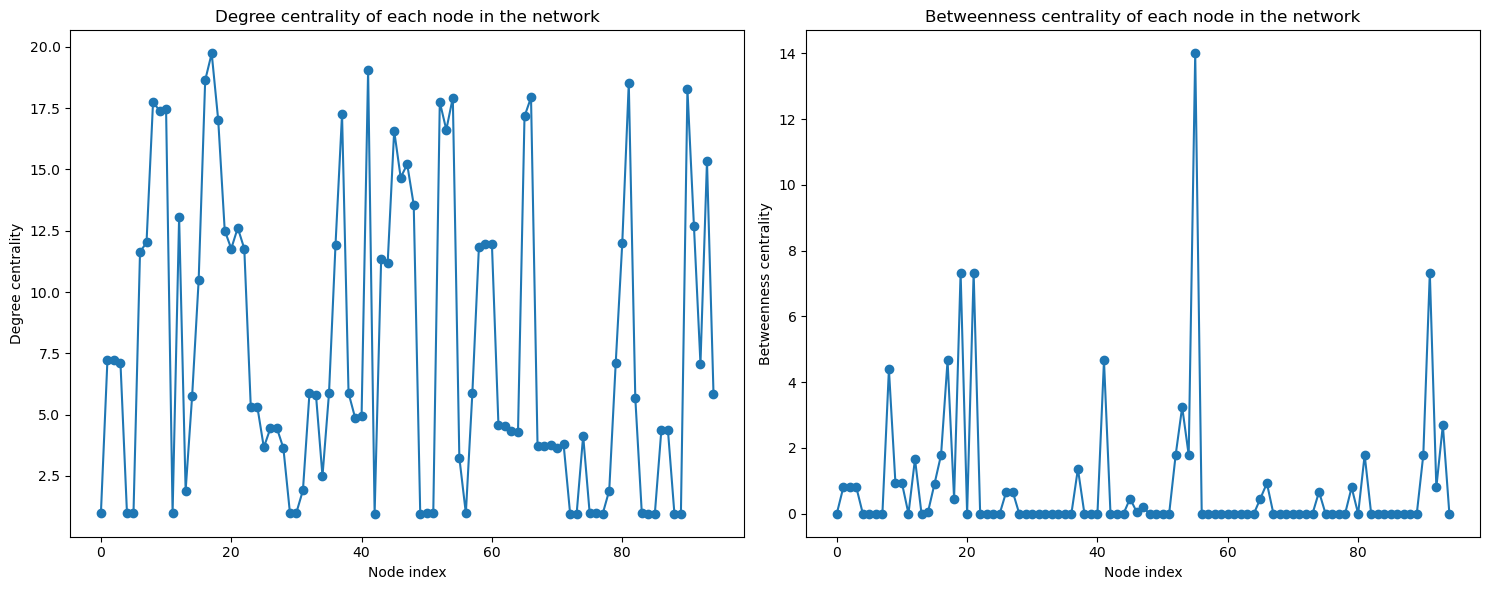

In [98]:
# Visualise the degree centrality of each node (gene) in the network 
plt.figure(figsize=(15, 6))
plt.subplot(1, 2, 1)
plt.plot(degree, 'o-')
plt.xlabel('Node index')
plt.ylabel('Degree centrality')
plt.title('Degree centrality of each node in the network')

# Visualise the betweenness centrality of each node in the network
plt.subplot(1, 2, 2)
plt.plot(betweenness, 'o-')
plt.xlabel('Node index')
plt.ylabel('Betweenness centrality')
plt.title('Betweenness centrality of each node in the network')

plt.tight_layout()
plt.show()


> We notice by comparing those plots that while multiple nodes have a high degree centrality, it seems that the betweenness centrality is more sparse. Only a few nodes have a high betweenness centrality. This is expected as the betweenness centrality is a measure of the importance of a node in a network or graph, based on the number of shortest paths that pass through that node. It may be more relevant in some cases to identify the nodes that are important for maintaining the connectivity of the network.

In [99]:
# Sort the genes in descending order by these values
sorted_genes = np.argsort(degree)[::-1]

print('Top 5 genes:', sorted_genes[:5])
print('Top 5 degree centrality:', degree[sorted_genes[:5]])

# Sort the genes in descending order by these values
sorted_genes = np.argsort(betweenness)[::-1]

# Print the index of the 5 top ranking genes
print('Top 5 genes:', sorted_genes[:5])
print('Top 5 betweenness centrality:', betweenness[sorted_genes[:5]])

Top 5 genes: [17 41 16 81 90]
Top 5 degree centrality: [19.73839866 19.04945567 18.64028395 18.53179044 18.2670517 ]
Top 5 genes: [55 21 19 91 17]
Top 5 betweenness centrality: [14.          7.33333333  7.33333333  7.33333333  4.66033966]


In [100]:
# Compute the degree centrality of the nodes
betweenness = betweenness_centrality(A_bc)
# Sort the degree centrality
sorted_betweeness_centrality = np.sort(betweenness)[::-1]

A_bc_subset = A_subset.copy()
# Set all values bigger than 0 to 1
A_bc_subset[A_bc_subset > 0] = 1
# Compute the degree centrality of the nodes in the biggest cluster
betweeness_subset = betweenness_centrality(A_bc_subset)
# Sort the degree centrality
sorted_betweeness_centrality_subset = np.sort(betweeness_subset)[::-1]

# Print the index of the 5 top ranking genes
print("=== Betweenness centrality for the whole matrix A ===")
print('Top 5 genes for the whole matrix A:', np.argsort(betweenness)[-5:][::-1])
print('Top 5 degree centrality for the whole matrix A:', sorted_betweeness_centrality[:5])

print("\n")

# Print index of the 5 top ranking genes of the cluster and their values
print("=== Betweenness centrality for the biggest cluster ===")
print('Indices of the top 5 genes for the biggest cluster (subset indices):', np.argsort(betweeness_subset)[-5:][::-1])
print('Top 5 genes for the biggest cluster (true indices):', indices[np.argsort(betweeness_subset)[-5:][::-1]])
print('Top 5 degree centrality for the biggest cluster:', sorted_betweeness_centrality_subset[:5])

=== Betweenness centrality for the whole matrix A ===
Top 5 genes for the whole matrix A: [55 21 19 91 17]
Top 5 degree centrality for the whole matrix A: [14.          7.33333333  7.33333333  7.33333333  4.66033966]


=== Betweenness centrality for the biggest cluster ===
Indices of the top 5 genes for the biggest cluster (subset indices): [ 7 10  0 16 22]
Top 5 genes for the biggest cluster (true indices): [17 41  8 53 93]
Top 5 degree centrality for the biggest cluster: [4.66033966 4.66033966 4.38976579 3.24330114 2.69415584]


The top 5 nodes with the highest betweenness centrality are not the same as the top 5 nodes with the highest degree centrality for the whole graph. In fact, none of the top 5 nodes with the highest betweenness centrality are in the top 5 nodes with the highest degree centrality. This could be expected as the betweenness centrality is a measure of the importance of a node in a network or graph, based on the number of shortest paths that pass through that node and not based on the number of direct connections. It captures different aspects of node importance and thus, we can expect different results.

Moreover, when comparing the top 5 nodes with the highest betweenness centrality in the whole graph and the top 5 nodes with the highest betweenness centrality in the biggest cluster, we notice that they are not the same set of nodes. Only node 17 is in common. This could mean that the most important nodes in terms of betweenness centrality are not present in the biggest cluster identified and that other nodes are more important for maintaining the connectivity of the network. We could guess that the biggest cluster has most nodes that are very connected and therefore do not carry a lot of betweenness centrality.

Furthermore, if we compare the top 5 nodes with the highest betweenness centrality with the top 5 nodes with the highest degree centrality for the biggest cluster, we notice that the top 5 nodes with the highest betweenness centrality are not the same as the top 5 nodes with the highest degree centrality for the biggest cluster. Only two nodes are in common, node 17 and 41. This means that nodes 17 and 41 are the most important node for maintaining the connectivity of the network for the biggest cluster both in terms of degree centrality and betweenness centrality. 

It may be more relevant in some cases to identify the nodes that are important for maintaining the connectivity of the network.

#### 3.2 Hidden Markov Models (15 marks)

Task 3.2 is focused on using Hidden Markov Models (HMMs) to analyze a time series dataset of monthly stock prices of the S&P 500 Stock Index from 2000-2015.

3.2.1

 In this task, we are asked to extract the closing price, return, and range from the dataset and visualize the time series. The closing price is the final price of a stock at the end of a trading day, the return is the percentage change in the closing price over a given period of time, and the range is the relative difference between the monthly low and high prices.

In [101]:
stock_df = pd.read_csv('stock.csv')
print(stock_df.shape)
stock_df.head()

(183, 7)


Date     Open     High      Low   Close*  Adj Close**       Volume
0  Mar 01, 2015  2105.23  2117.52  2039.69  2067.89      2067.89  76675850000
1  Feb 01, 2015  1996.67  2119.59  1980.90  2104.50      2104.50  68775560000
2  Jan 01, 2015  2058.90  2072.36  1988.12  1994.99      1994.99  77330040000
3  Dec 01, 2014  2065.78  2093.55  1972.56  2058.90      2058.90  80743820000
4  Oct 31, 2014  2018.21  2075.76  2001.01  2067.56      2067.56  63600190000

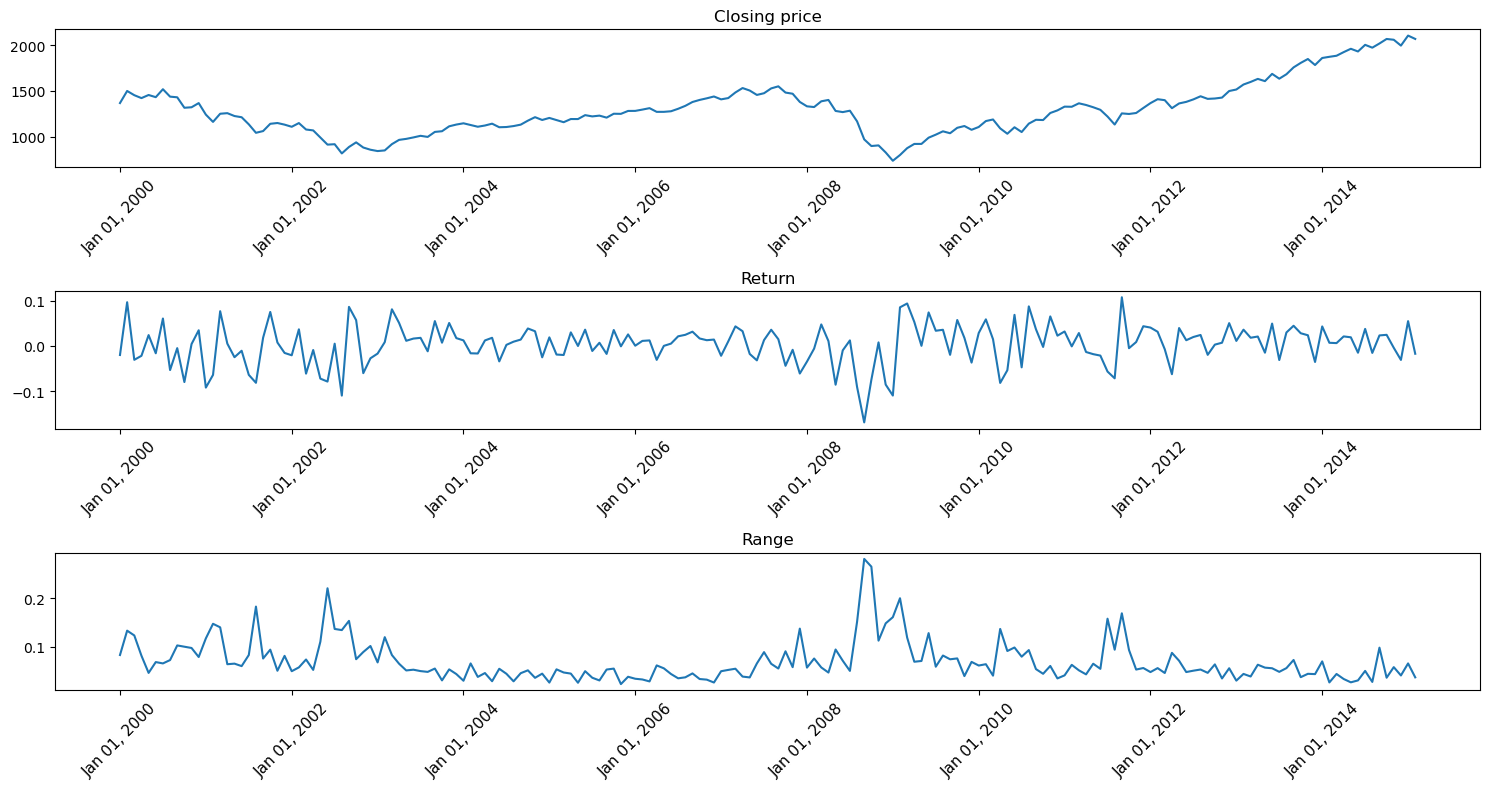

In [102]:
# Reversed 
stock_df = stock_df.iloc[::-1]
# Extract the closing price
closing_price = stock_df['Close*'].values

# Extract the return (percentage of the monthly change of closing price) 
return_price = (stock_df['Close*'].pct_change()).values

# Extract the range (the relative difference between the monthly low and high prices)
range_price = ((stock_df['High'] - stock_df['Low'])/stock_df['High']).values

# Delete first value because of the NaN value in the return
closing_price = np.delete(closing_price, 0)
return_price = np.delete(return_price, 0)
range_price = np.delete(range_price, 0)

# Set x ticks labels using dates in stock_df['Date']
x_ticks = stock_df['Date'].values

# Visualise the time series as 3 subplots with legend
fig, ax = plt.subplots(3, 1, figsize=(15, 8))
ax[0].plot(closing_price)
ax[0].set_title('Closing price')
ax[0].set_xticks(range(0, len(x_ticks), 24))
ax[0].set_xticklabels(x_ticks[::24], rotation=45, fontsize=11)
ax[1].plot(return_price)
ax[1].set_xticks(range(0, len(x_ticks), 24))
ax[1].set_xticklabels(x_ticks[::24], rotation=45, fontsize=11)
ax[1].set_title('Return')
ax[2].plot(range_price)
ax[2].set_title('Range')
ax[2].set_xticks(range(0, len(x_ticks), 24))
ax[2].set_xticklabels(x_ticks[::24], rotation=45, fontsize=11)
plt.tight_layout()
plt.show()

> We delete the first value of each time series as it is a NaN value for the returns. Indeed, when calculating the percentage change, the first value cannot be computed as it would depend on past data. As our dataset is already sorted by date and already pretty big, we can simply delete the first value of each time series to avoid facing any issue.

We have successfully built and plotted our time series by extracting the closing price, the return and the range from the dataset. We notice that the closing price is a smooth curve, while the return and the range are more noisy. This is expected as the closing price is the final price of a stock at the end of a trading day, while the return and the range are the percentage change in the closing price and the relative difference between the monthly low and high prices over a given period of time. The closing price is thus a more stable value than the return and the range.

3.2.2

The Expectation-Maximization (EM) algorithm will be used to train an HMM with three components on the extracted time series data. We will need to provide an interpretation of the hidden states by visualizing the means and variances of the mixture components.

In [103]:
# Use the Expectation-Maximisation (EM) algorithm with a suitable termination criterion to train an HMM with three components on the time series obtained. 
import scipy.stats as st
class HMM:
    """struct holding the parameters of the Hidden Markov Model"""
    """:param n_states: number of hidden states (clusters)"""
    """:param prior: initial distribution (pi)"""
    """:param A: transition matrix"""
    """:param n_dims: dimension of observations"""
    """:param mu: emission probability means for each cluster"""
    """:param sigma: emission probability covariance matrix for each cluster"""
    
    def __init__(self, n_states):
        """:param n_states: number of hidden states (K)"""
        self.n_states = n_states
        self.random_state = np.random.RandomState(0)
        
        #Normalize random initial state
        self.prior = normalize(self.random_state.rand(self.n_states, 1))
        self.A = normalize(self.random_state.rand(self.n_states, self.n_states))
        
        self.mu = None
        self.sigma = None
        self.n_dims = None
        
def initialise(model, obs):
    """initialises the parameters of the HMM from some observations"""
    if model.n_dims is None:
        model.n_dims = obs.shape[0]
    if model.mu is None:
        subset = model.random_state.choice(np.arange(model.n_dims), size=model.n_states, replace=False)
        model.mu = np.transpose(obs[:, subset])
    if model.sigma is None:
        model.sigma = np.zeros((model.n_states, model.n_dims, model.n_dims))
        model.sigma += np.diag(np.diag(np.cov(obs)))[None, :, :]
        
def normalize(x):
    """Normalises vectors and matrices"""
    temp = x
    if len(x.shape)>1:
        for s in range(temp.shape[0]):
            temp[s,:] /= np.sum(temp[s,:])
        return temp
    else:
        return (x) / np.sum(x,0)

In [104]:
def compute_emission_probabilites(model, obs):
    obs = np.atleast_2d(obs)
    B = np.zeros((model.n_states, obs.shape[1]))
    for s in range(model.n_states):
        B[s, :] = st.multivariate_normal.pdf(obs.T, mean=model.mu[s], cov=model.sigma[s])
    return B    

## EDIT THIS FUNCTION
def forwardbackward(model, B):
    """Implementation of the forward-backward algorithm"""
    """:param model: this is the HMM, emmission """
    """:param B: emission matrix """
    
    log_likelihood = 0.
    T = B.shape[1]
    
    # forward algorithm
    alpha = np.zeros(B.shape)
    for t in range(T):
        if t == 0:
            alpha[:, t] = B[:, t] * model.prior.ravel()
        else:
            alpha[:, t] = B[:, t] * np.dot(model.A.T, alpha[:, t - 1])

        alpha_sum = np.sum(alpha[:, t])
        alpha[:, t] /= alpha_sum
        log_likelihood = log_likelihood + np.log(alpha_sum)
    
    # backward algorithm
    beta = np.zeros(B.shape);
    beta[:, -1] = np.ones(B.shape[0])

    for t in range(T - 1)[::-1]:
        beta[:, t] = np.dot(model.A, (B[:, t + 1] * beta[:, t + 1]))
        beta[:, t] /= np.sum(beta[:, t])
        
    # smoothed solution
    gamma = np.zeros((model.n_states, T))
    for t in range(T):
        gamma[:, t] = alpha[:, t] * beta[:, t]  ### <- fill in   
    
    return log_likelihood, alpha, beta, gamma

def predict0(model, obs):
    """MAP of filtered cluster probabilities (hard clustering)"""
    B = compute_emission_probabilites(model, obs)
    T = B.shape[1]
    
    _, alpha, _, _ = forwardbackward(model,B)
        
    return np.argmax(alpha.T, axis=1)

def predict(model, obs):
    """MAP of smoothed cluster probabilities (hard clustering)"""
    B = compute_emission_probabilites(model, obs)
    T = B.shape[1]
    
    _, _, _, gamma = forwardbackward(model,B)
        
    return np.argmax(gamma.T, axis=1)

def AIC(model, obs):
    """Computes the Akaike Information Criterion"""
    B = compute_emission_probabilites(model, obs)
    T = B.shape[1]
    
    log_likelihood, _, _, _ = forwardbackward(model,B)
    
    return 2 * model.n_states * model.n_dims - 2 * log_likelihood


In [105]:
def em_step(model, obs): 
    """One step of the EM training for the HMM"""

    initialise(model,obs)

    obs = np.atleast_2d(obs)
    B = compute_emission_probabilites(model,obs)
    T = obs.shape[1]

    # evaluate forward and backward probabilities (E step)
    log_likelihood, alpha, beta, gamma = forwardbackward(model,B)

    #E-Step: update model        
    expected_prior = normalize(gamma[:, 0])        
    xi = np.zeros((model.n_states, model.n_states))
    for t in range(T - 1):
        xi += normalize(model.A * np.dot(alpha[:, t], (beta[:, t+1] * B[:, t + 1]).T))
    expected_A = normalize(xi)

    # M-Step: update mu and sigma              
    expected_mu = np.zeros((model.n_states, model.n_dims))
    expected_sigma = np.zeros((model.n_states, model.n_dims, model.n_dims))

    for s in range(model.n_states):
        weight = gamma[s,:]/(gamma[s,:].sum())            
        expected_mu[s] = (obs @ weight)
        expected_sigma[s] = np.cov(obs, aweights=weight, bias=True)

    # update
    model.prior = expected_prior
    model.mu = expected_mu
    model.sigma = expected_sigma
    model.A = expected_A
    return log_likelihood


def train(model, obs, n_iter=1, tol=1e-7, evaluate=False):
    """Several EM steps with an appropriate stopping criterion"""
    prev_log_likelihood = -np.inf # log_likelihood of previous iteration set to -inf 
    for i in range(n_iter):
        log_likelihood = em_step(model,obs)
        print("Iteration %d: log_likelihood = %.3f" % (i+1, log_likelihood))
        if abs(log_likelihood - prev_log_likelihood) < tol: # stopping criterion
            print("Converged after %d iterations" % (i+1))
            break
        prev_log_likelihood = log_likelihood
    if evaluate:
        return log_likelihood, AIC(model, obs) # return log_likelihood and AIC for evaluation


> We have implemented the EM algorithm to train an HMM on extracted time series data. We have used the code provided in the coding tutorial to guide us through the implementation of the algorithm. We have added a stopping criterion to the algorithm to avoid it to run for too long and ensure convergence. 

In [106]:
from matplotlib.patches import Ellipse
import matplotlib.pyplot as plt

def draw_ellipse(position, covariance, ax=None, **kwargs): # modified from coding tutorial
    """Draw an ellipse with a given position and covariance in dims 3"""
    ax = ax or plt.gca()
    
    # find the rotation matrix and radii of the axes
    U, s, rotation = np.linalg.svd(covariance)
    radii = 2*np.sqrt(s)

    # now carry on with EOL's answer
    u = np.linspace(0.0, 2.0 * np.pi, 100)
    v = np.linspace(0.0, np.pi, 100)
    x = radii[0] * np.outer(np.cos(u), np.sin(v))
    y = radii[1] * np.outer(np.sin(u), np.sin(v))
    z = radii[2] * np.outer(np.ones_like(u), np.cos(v))
    for i in range(len(x)):
        for j in range(len(x)):
            [x[i,j],y[i,j],z[i,j]] = np.dot([x[i,j],y[i,j],z[i,j]], rotation) + position

    ax.plot_wireframe(x, y, z, **kwargs)
        
def plot_gmm(model, X, label=True, ax=None): # modified from coding tutorial
    ax = ax or plt.gca()
    if label:
        labels = predict(model,X.T)
        ax.scatter3D(X[:, 0], X[:, 1], X[:, 2], c=labels, s=40, cmap='viridis', zorder=2)
    else:
        ax.scatter3D(X[:, 0], X[:, 1], X[:, 2], s=40, zorder=2)
    
    w_factor = 0.2
    for pos, covar, w in zip(model.mu, model.sigma, model.prior):
        draw_ellipse(pos, covar, alpha=0.2)

> We have reused the plotting functions introduced the coding tutorials. However, we have made some slight changes to adapt to the exercise guidelines and provide better visualisations. 

In [107]:
# Stack closing price, return price and range price into one vector with 3 cols
X = np.column_stack((closing_price, return_price, range_price))
print("X.shape = ", X.shape)

X.shape =  (182, 3)


In [108]:
# Training the HMM model
np.random.seed(42)
m1 = HMM(3)
train(m1, X.T, 1000)

Iteration 1: log_likelihood = -790.934
Iteration 2: log_likelihood = -566.374
Iteration 3: log_likelihood = -529.906
Iteration 4: log_likelihood = -520.507
Iteration 5: log_likelihood = -518.065
Iteration 6: log_likelihood = -517.306
Iteration 7: log_likelihood = -517.091
Iteration 8: log_likelihood = -517.050
Iteration 9: log_likelihood = -517.060
Iteration 10: log_likelihood = -517.079
Iteration 11: log_likelihood = -517.097
Iteration 12: log_likelihood = -517.109
Iteration 13: log_likelihood = -517.115
Iteration 14: log_likelihood = -517.116
Iteration 15: log_likelihood = -517.112
Iteration 16: log_likelihood = -517.099
Iteration 17: log_likelihood = -517.073
Iteration 18: log_likelihood = -517.026
Iteration 19: log_likelihood = -516.948
Iteration 20: log_likelihood = -516.847
Iteration 21: log_likelihood = -516.751
Iteration 22: log_likelihood = -516.690
Iteration 23: log_likelihood = -516.662
Iteration 24: log_likelihood = -516.653
Iteration 25: log_likelihood = -516.651
Iteration

In [109]:
m1.mu

array([[ 1.14141346e+03, -4.67258033e-02,  1.13551866e-01],
       [ 1.36481349e+03,  4.16984825e-02,  6.47419133e-02],
       [ 1.36247718e+03, -3.53504062e-03,  4.75137784e-02]])

In [110]:
m1.sigma

array([[[ 4.12469686e+04,  2.51675192e+00, -4.78490871e+00],
        [ 2.51675192e+00,  1.81773448e-03, -1.52317253e-03],
        [-4.78490871e+00, -1.52317253e-03,  3.02370795e-03]],

       [[ 1.04188195e+05, -3.18346119e+00, -4.00908807e+00],
        [-3.18346119e+00,  5.61141839e-04,  6.35215139e-04],
        [-4.00908807e+00,  6.35215139e-04,  1.13128865e-03]],

       [[ 8.87194100e+04, -1.06676933e+00, -1.28185044e+00],
        [-1.06676933e+00,  3.46521699e-04, -7.87009181e-05],
        [-1.28185044e+00, -7.87009181e-05,  1.69115771e-04]]])

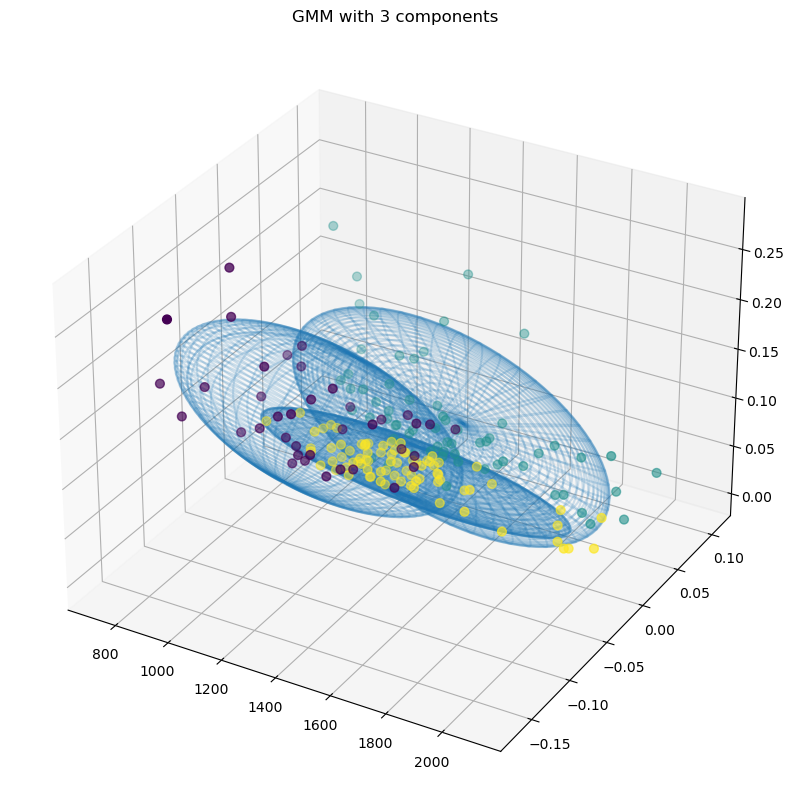

In [111]:
# Visualize the means and covariance of the mixture components
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')
plot_gmm(m1, X, ax=ax)
plt.title("GMM with 3 components")
plt.show()

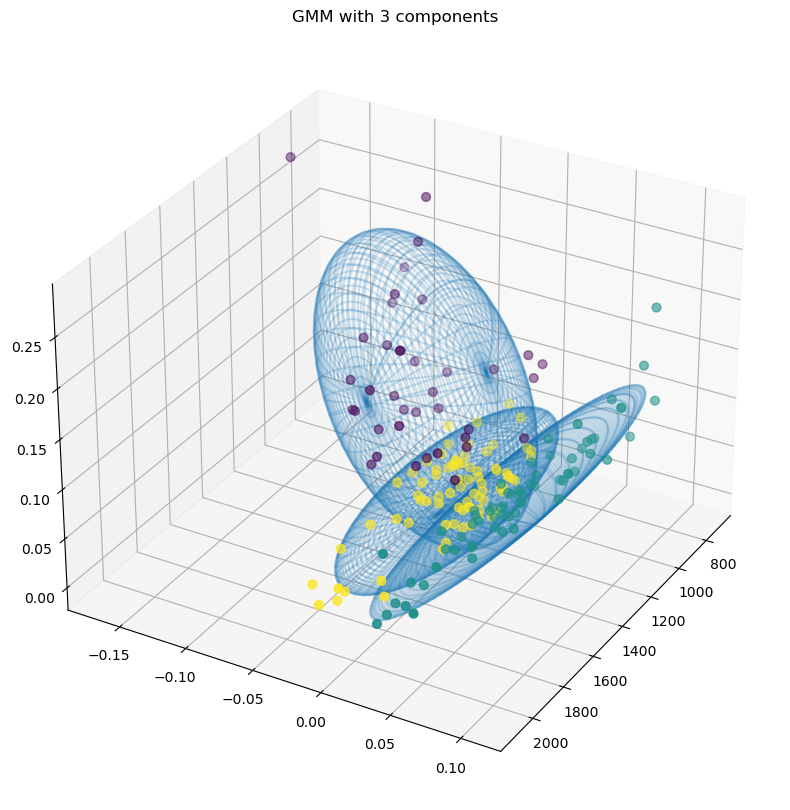

In [112]:
# Visualize the means and covariance of the mixture components
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')
plot_gmm(m1, X, ax=ax)
# Change angle for better view
ax.view_init(30, 30)
plt.title("GMM with 3 components")
plt.show()


By training an HMM with three components and visualising the means and variances of the mixture components, we have identified three hidden states. In an HMM, the hidden states are unobservable variables that represent the underlying system that generates a sequence of observable outputs. The interpretation of the hidden states depends on the specific application of the HMM. The first hidden state is characterized by a low mean and a low variance. The second hidden state is characterized by a high mean and a high variance. The third hidden state is characterized by a relatively high mean and variance.

3.2.3

This task requires us to cluster the time series and visualize the inferred sequence of hidden states by distinguishing them in the original time series using different plot markers.

In [113]:
# Extract the hidden states predictions
predictions = predict(m1, X.T)

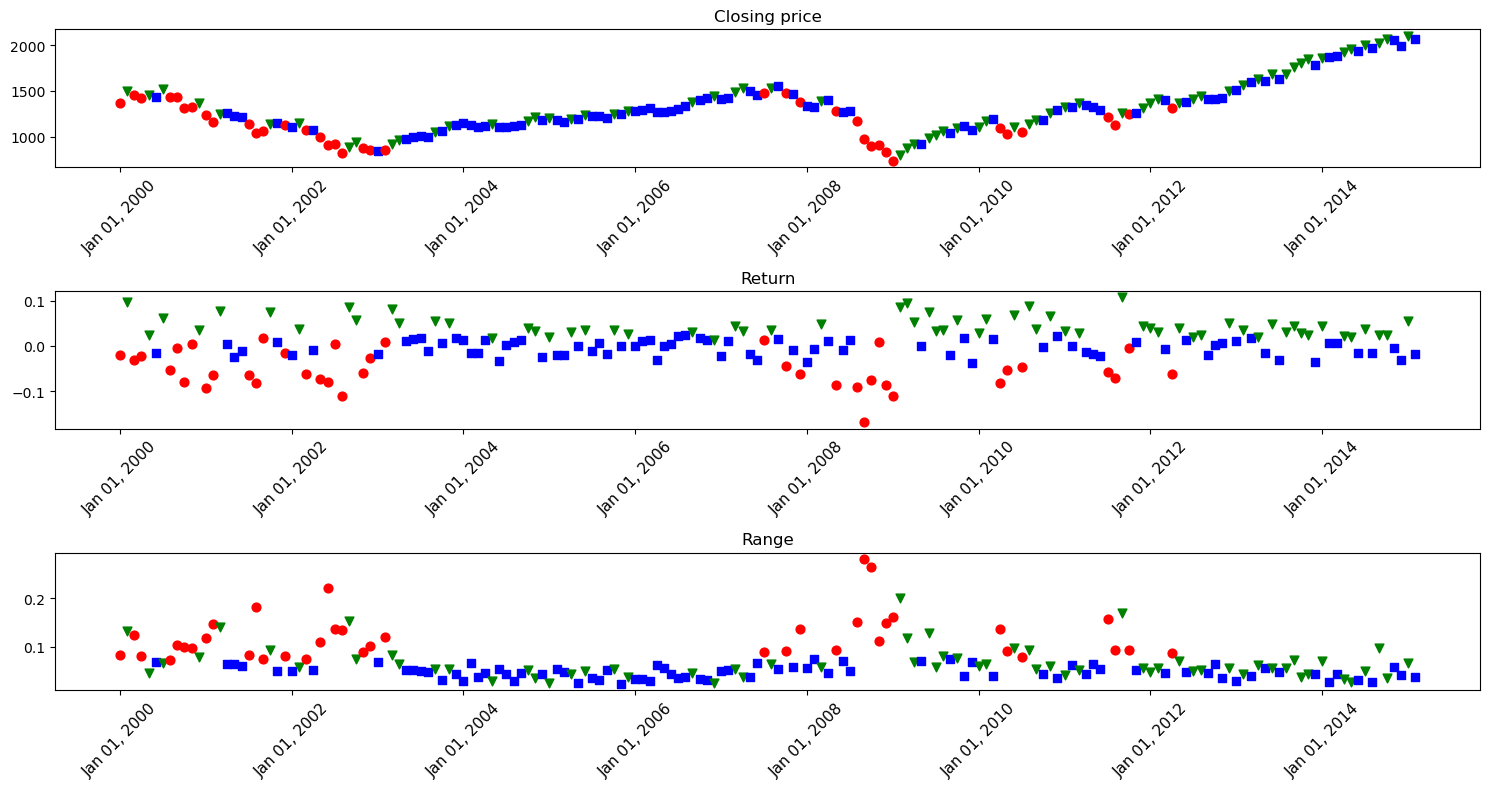

In [114]:
# Cluster the time series and visualise the inferred sequence of hidden states by distinguishing them in the original time series 
markers = ['o', 'v', 's']
colors = ['r', 'g', 'b']
# Visualise the time series as 3 subplots with legend with different markers for each labels value
fig, ax = plt.subplots(3, 1, figsize=(15, 8))
for i in range(len(X[:,0])):
    ax[0].scatter(i, X[i,0], c=colors[predictions[i]], marker=markers[predictions[i]], s=40)
ax[0].set_title('Closing price')
ax[0].set_xticks(range(0, len(x_ticks), 24))
ax[0].set_xticklabels(x_ticks[::24], rotation=45, fontsize=11)
for i in range(len(X[:,1])):
    ax[1].scatter(i, X[i,1], c=colors[predictions[i]], marker=markers[predictions[i]], s=40)
ax[1].set_title('Return')
ax[1].set_xticks(range(0, len(x_ticks), 24))
ax[1].set_xticklabels(x_ticks[::24], rotation=45, fontsize=11)
for i in range(len(X[:,2])):
    ax[2].scatter(i, X[i,2], c=colors[predictions[i]], marker=markers[predictions[i]], s=40)
ax[2].set_title('Range')
ax[2].set_xticks(range(0, len(x_ticks), 24))
ax[2].set_xticklabels(x_ticks[::24], rotation=45, fontsize=11)
plt.tight_layout()
plt.show()

> In this plot each color/marker represent a different hidden state. We have made to choose different markers and colors for each hidden state to make the plot more readable. 

We have successfully clustered our times series in terms hidden states. By plotting the different hidden states with different markers and colors, we are able to distinguish different behaviours and interpretations for each hidden state. For instance, we can easily observe that the red circles represent a period of decrease of the closing price as they are located each time the closing price is decreasing. We can also observe that the blue squares represent a period of increase of the closing price as they are located each time the closing price is increasing. This is a good indication that our model has correctly converged and has been able to identify three hidden states with different behaviours.

3.2.4

We will perform a grid search to optimize the number of mixture components in the HMM by using the Akaike Information Criterion (AIC) in a specified range. We can initialize the EM algorithm using the optimal values of the HMM with one less component. The inferred sequence of hidden states for the optimum number of mixture components will be visualized.

In [115]:
# Perform grid search using the AIC 
k_values = range(2, 11)
aic_values = []
log_likelihood_values = []
models_store = []
n_iter = 10
# Initialise for k = 1 
m = HMM(1)
initialise(m, X.T)
log_likelihood, aic = train(m, X.T, n_iter, evaluate=True)
print('k = {}, AIC = {}'.format(1, aic))
aic_values.append(aic)
log_likelihood_values.append(log_likelihood)
prev_m = m
for k in k_values:
    m = HMM(k)
    # Use prev mu and extend by 1 dimension
    mu_extend = m.random_state.choice(X.T.shape[0], size=1, replace=False)
    mu_extend = np.transpose(X.T[:, mu_extend])
    m.mu = np.concatenate((prev_m.mu, mu_extend), axis=0)
    # Use prev sigma and extend by 1 dimension
    sigma_extend = np.zeros((1, X.T.shape[0], X.T.shape[0]))
    sigma_extend += np.diag(np.diag(np.cov(X.T)))[None, :, :]
    m.sigma = np.concatenate((prev_m.sigma, sigma_extend), axis=0)
    # Use prev A and extend by 1 dimension in each axis
    m.A[:prev_m.n_states, :prev_m.n_states] = prev_m.A
    m.A = normalize(m.A)
    # Use prev prior and extend by 1 dimension
    prior_extend = m.random_state.rand(1, 1).reshape(1,)
    m.prior = normalize(np.concatenate((prev_m.prior, prior_extend), axis=0))
    initialise(m, X.T)
    log_likelihood, aic = train(m, X.T, n_iter, evaluate=True)
    print('k = {}, AIC = {}, log_likelihood = {}'.format(k, aic, log_likelihood))
    aic_values.append(aic)
    log_likelihood_values.append(log_likelihood)
    models_store.append(m)
    prev_m = m


Iteration 1: log_likelihood = -697.985
Iteration 2: log_likelihood = -630.991
Iteration 3: log_likelihood = -630.991
Converged after 3 iterations
k = 1, AIC = 1267.9823707850985
Iteration 1: log_likelihood = -664.544
Iteration 2: log_likelihood = -577.285
Iteration 3: log_likelihood = -545.018
Iteration 4: log_likelihood = -534.312
Iteration 5: log_likelihood = -530.576
Iteration 6: log_likelihood = -528.055
Iteration 7: log_likelihood = -525.635
Iteration 8: log_likelihood = -524.447
Iteration 9: log_likelihood = -524.139
Iteration 10: log_likelihood = -524.085
k = 2, AIC = 1060.1941373807765, log_likelihood = -524.0845267293585
Iteration 1: log_likelihood = -556.566
Iteration 2: log_likelihood = -534.903
Iteration 3: log_likelihood = -526.038
Iteration 4: log_likelihood = -519.639
Iteration 5: log_likelihood = -516.379
Iteration 6: log_likelihood = -514.186
Iteration 7: log_likelihood = -512.284
Iteration 8: log_likelihood = -510.372
Iteration 9: log_likelihood = -508.203
Iteration 1

> During the training of each HMM, we set initialise the EM algorithm using the optimal values of the HMM with one less component as it was suggested in the exercise guidelines. We also notice that this allows us much faster convergence of the algorithm.

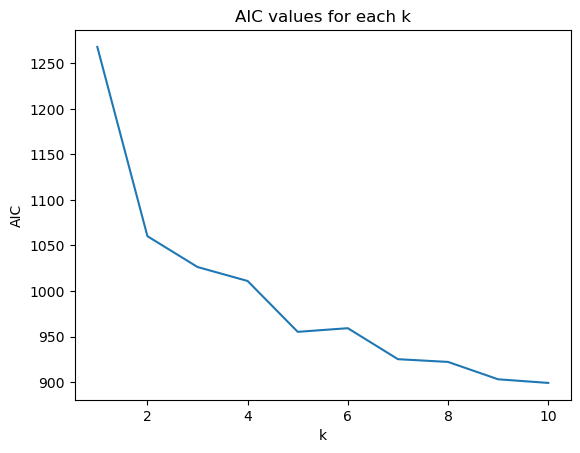

In [116]:
# Plot the AIC values for each k
k_values_plot = [1] + list(k_values)
plt.plot(k_values_plot, aic_values)
plt.xlabel('k')
plt.ylabel('AIC')
plt.title('AIC values for each k')
plt.show()

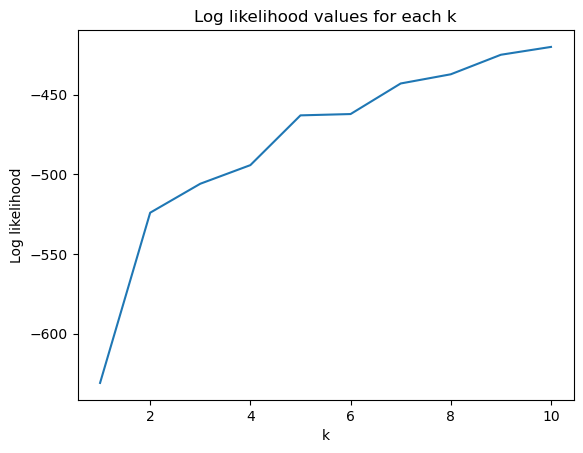

In [117]:
# Plot the log likelihood values for each k
k_values_plot = [1] + list(k_values)
plt.plot(k_values_plot, log_likelihood_values)
plt.xlabel('k')
plt.ylabel('Log likelihood')
plt.title('Log likelihood values for each k')
plt.show()

In [118]:
# Optimal k (with lowest AIC)
k_opt = k_values_plot[np.argmin(aic_values)]
print('Optimal k = {}'.format(k_opt), 'with AIC = {}'.format(np.min(aic_values)))

Optimal k = 10 with AIC = 899.1299234197724


> We have found that the optimal k is $k=10$. Indeed, as indicated by the exercise guidelines, we have used the AIC criterion to find the optimal number of mixture components. The AIC is particularly relevant for our case as it is a measure of the relative quality of statistical models for a given set of data. It provides a way to compare different models based on how well they fit the data while taking into account the complexity of the model.

Training HMM with optimal k = 10


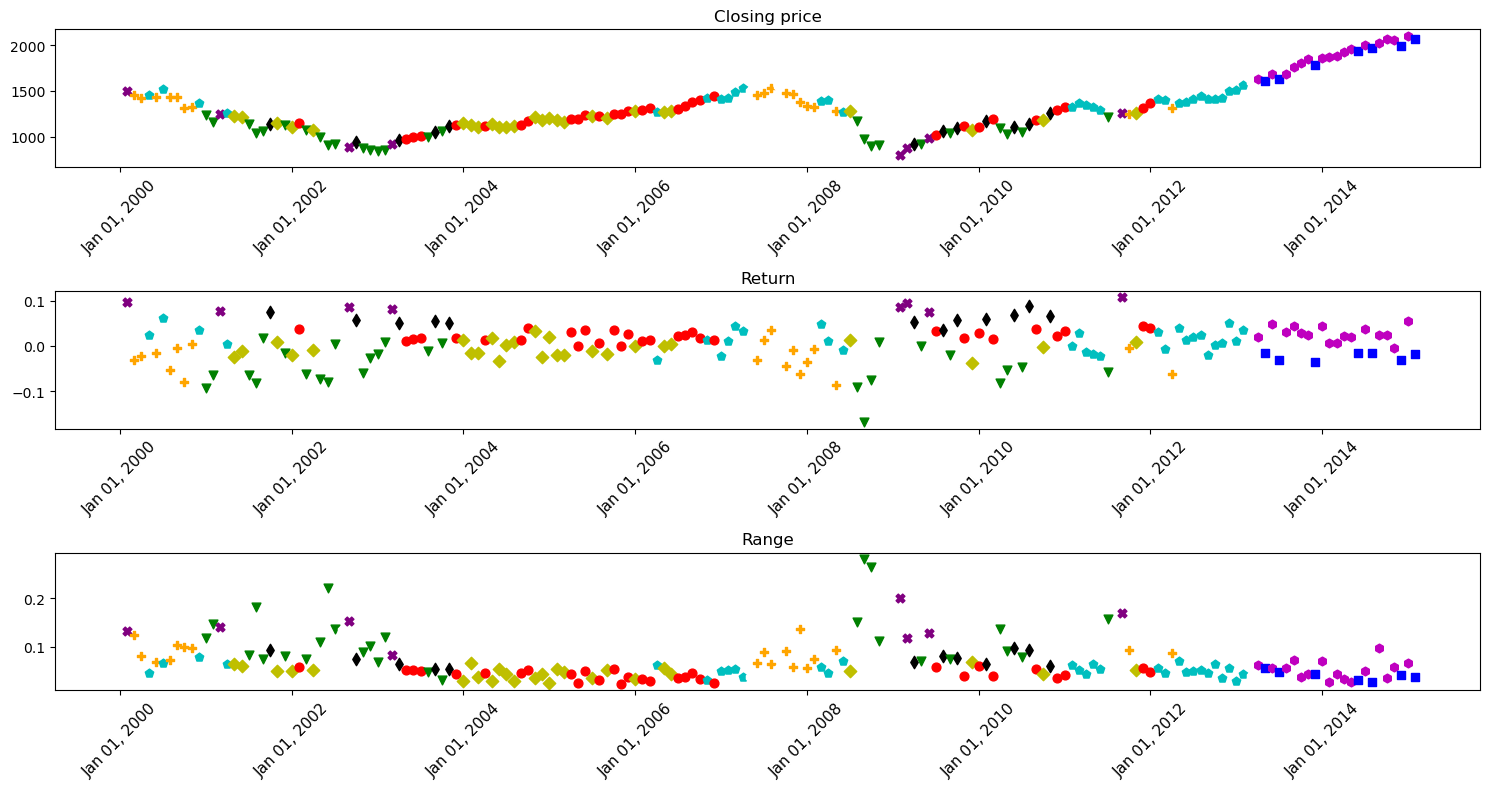

In [119]:
# Retrieve the model with the optimal k
print('Training HMM with optimal k = {}'.format(k_opt))
m = models_store[k_opt-2]

# Extract the hidden states predictions
predictions = predict(m, X.T)

# Cluster the time series and visualise the inferred sequence of hidden states by distinguishing them in the original time series 
markers = ['o', 'v', 's', 'p', 'h', 'D', 'd', '8', 'P', 'X']
colors = ['r', 'g', 'b', 'c', 'm', 'y', 'k', 'w', 'orange', 'purple']
# Visualise the time series as 3 subplots with legend with different markers for each labels value
fig, ax = plt.subplots(3, 1, figsize=(15, 8))
for i in range(len(X[:,0])):
    ax[0].scatter(i, X[i,0], c=colors[predictions[i]], marker=markers[predictions[i]], s=40)
ax[0].set_title('Closing price')
ax[0].set_xticks(range(0, len(x_ticks), 24))
ax[0].set_xticklabels(x_ticks[::24], rotation=45, fontsize=11)
for i in range(len(X[:,1])):
    ax[1].scatter(i, X[i,1], c=colors[predictions[i]], marker=markers[predictions[i]], s=40)
ax[1].set_title('Return')
ax[1].set_xticks(range(0, len(x_ticks), 24))
ax[1].set_xticklabels(x_ticks[::24], rotation=45, fontsize=11)
for i in range(len(X[:,2])):
    ax[2].scatter(i, X[i,2], c=colors[predictions[i]], marker=markers[predictions[i]], s=40)
ax[2].set_title('Range')
ax[2].set_xticks(range(0, len(x_ticks), 24))
ax[2].set_xticklabels(x_ticks[::24], rotation=45, fontsize=11)
plt.tight_layout()
plt.show()

By performing a grid search over the number k of optimal components, we have found that the optimal k is $k=10$. These means that the optimal number of mixture components is 10. We have found that the AIC value for k=10 is the lowest among all the values of k we have tested.

In this case, anaylising and intepreting the hidden states is more difficult as we have 10 hidden states. However, we can still observe that the yellow crosses represent a period of decrease of the closing price. 


3.2.5

 For this task, we will repeat the clustering by considering only data before August 2007. We will then sample 10 times from the underlying Markov chain and provide a forecast of the time series for the following two years. We will also comment on the predictive capacity of the model in general and with respect to the dip of the Global Financial Crisis (2007-2008) and briefly discuss the findings in connection with the Markov assumption underlying HMMs.

In [120]:
stock_df

Date     Open     High      Low   Close*  Adj Close**  \
182  Jan 01, 2000  1469.25  1478.00  1350.14  1394.46      1394.46   
181  Feb 01, 2000  1394.46  1444.55  1325.07  1366.42      1366.42   
180  Mar 01, 2000  1366.42  1552.87  1346.62  1498.58      1498.58   
179  Apr 01, 2000  1498.58  1527.19  1339.40  1452.43      1452.43   
178  Apr 30, 2000  1452.43  1481.51  1361.09  1420.60      1420.60   
..            ...      ...      ...      ...      ...          ...   
4    Oct 31, 2014  2018.21  2075.76  2001.01  2067.56      2067.56   
3    Dec 01, 2014  2065.78  2093.55  1972.56  2058.90      2058.90   
2    Jan 01, 2015  2058.90  2072.36  1988.12  1994.99      1994.99   
1    Feb 01, 2015  1996.67  2119.59  1980.90  2104.50      2104.50   
0    Mar 01, 2015  2105.23  2117.52  2039.69  2067.89      2067.89   

          Volume  
182  21494400000  
181  20912000000  
180  26156200000  
179  20106460000  
178  19898300000  
..           ...  
4    63600190000  
3    80743820000  
2    77330040000  
1    68775560000  
0    76675850000  

[183 rows x 7 columns]

In [121]:
# Reload the data
stock_df = pd.read_csv('stock.csv')
# Convert the date column to datetime format (Month day, year)
stock_df['Date_transformed'] = pd.to_datetime(stock_df['Date'], format='%b %d, %Y')
# Keep only the data before Aug 2007
stock_df = stock_df[stock_df['Date_transformed'] < '2007-08-01']

> We have transformed our data to only contain data before the 2007-08 financial crisis, i.e. before August 2007. We have then trained a new HMM with 10 components on this new dataset. We have then sampled 10 times from the underlying Markov chain and provided a forecast of the time series for the following two years.

In [122]:
# Check the date range
stock_df

Date     Open     High      Low   Close*  Adj Close**  \
91   Jul 31, 2007  1455.18  1503.89  1370.60  1473.99      1473.99   
92   Jun 30, 2007  1504.66  1555.90  1454.25  1455.27      1455.27   
93   May 31, 2007  1530.62  1540.56  1484.18  1503.35      1503.35   
94   Apr 30, 2007  1482.37  1535.56  1476.70  1530.62      1530.62   
95   Mar 31, 2007  1420.83  1498.02  1416.37  1482.37      1482.37   
..            ...      ...      ...      ...      ...          ...   
178  Apr 30, 2000  1452.43  1481.51  1361.09  1420.60      1420.60   
179  Apr 01, 2000  1498.58  1527.19  1339.40  1452.43      1452.43   
180  Mar 01, 2000  1366.42  1552.87  1346.62  1498.58      1498.58   
181  Feb 01, 2000  1394.46  1444.55  1325.07  1366.42      1366.42   
182  Jan 01, 2000  1469.25  1478.00  1350.14  1394.46      1394.46   

          Volume Date_transformed  
91   91381760000       2007-07-31  
92   70337430000       2007-06-30  
93   65322800000       2007-05-31  
94   64958050000       2007-04-30  
95   57032470000       2007-03-31  
..           ...              ...  
178  19898300000       2000-04-30  
179  20106460000       2000-04-01  
180  26156200000       2000-03-01  
181  20912000000       2000-02-01  
182  21494400000       2000-01-01  

[92 rows x 8 columns]

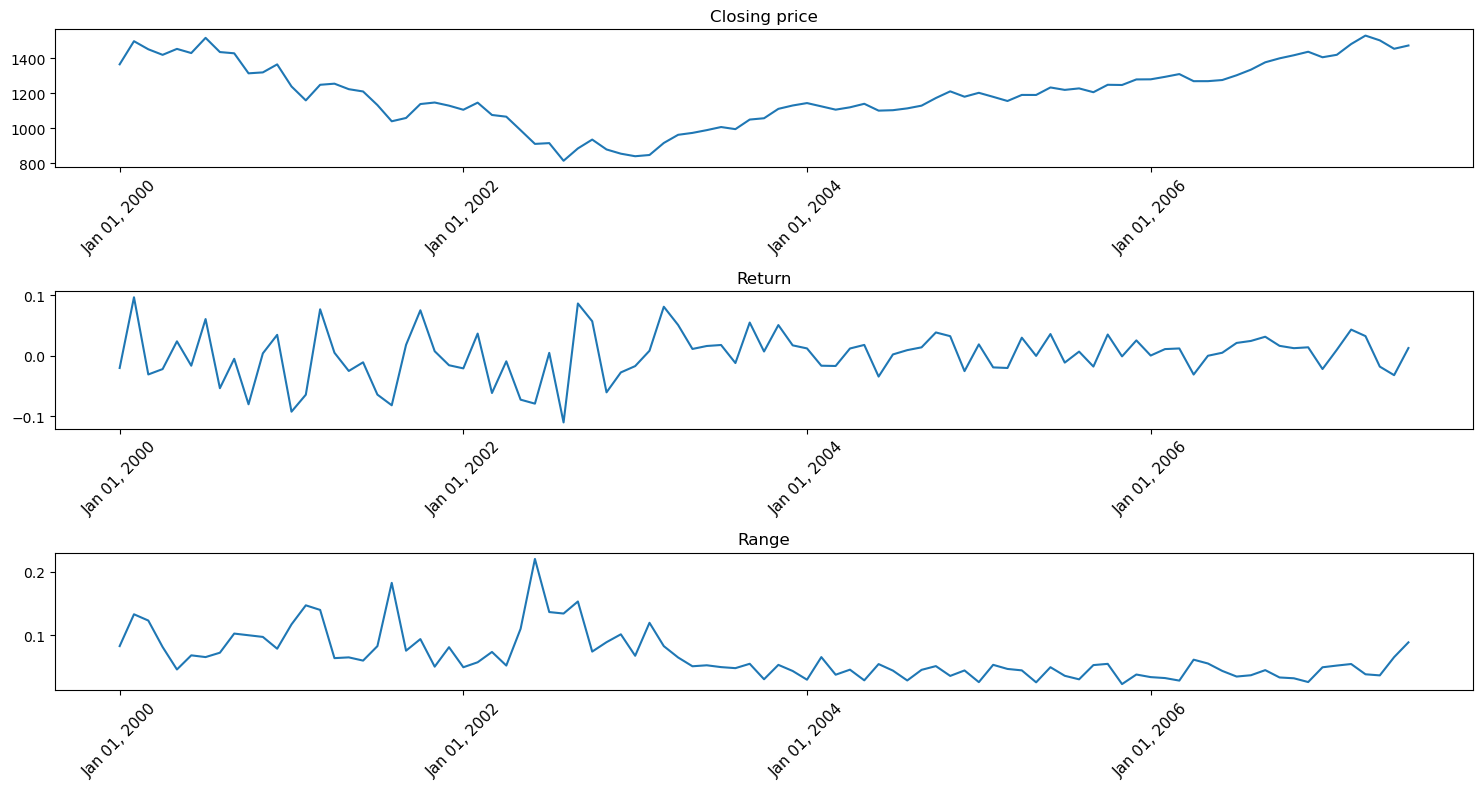

In [123]:
# Reversed 
stock_df = stock_df.iloc[::-1]
# Extract the closing price
closing_price = stock_df['Close*'].values

# Extract the return (percentage of the monthly change of closing price) 
return_price = (stock_df['Close*'].pct_change()).values
# Replace the first element with 0
return_price[0] = 0

# Extract the range (the relative difference between the monthly low and high prices)
range_price = ((stock_df['High'] - stock_df['Low']).values) / stock_df['High'].values

# Delete the first row
closing_price = np.delete(closing_price, 0)
return_price = np.delete(return_price, 0)
range_price = np.delete(range_price, 0)

# Extract the date
x_ticks = stock_df['Date'].values



# Visualise the time series as 3 subplots with legend
fig, ax = plt.subplots(3, 1, figsize=(15, 8))
ax[0].plot(closing_price)
ax[0].set_title('Closing price')
ax[0].set_xticks(range(0, len(x_ticks), 24))
ax[0].set_xticklabels(x_ticks[::24], rotation=45, fontsize=11)
ax[1].plot(return_price)
ax[1].set_title('Return')
ax[1].set_xticks(range(0, len(x_ticks), 24))
ax[1].set_xticklabels(x_ticks[::24], rotation=45, fontsize=11)
ax[2].plot(range_price)
ax[2].set_title('Range')
ax[2].set_xticks(range(0, len(x_ticks), 24))
ax[2].set_xticklabels(x_ticks[::24], rotation=45, fontsize=11)
plt.tight_layout()
plt.show()

> We plot the original data until August 2007 to check that the data has been correctly transformed. We can see that the data has been correctly transformed as the data after August 2007 is not plotted.

In [124]:
# Sampling 10 times from the underlying Markov chain and we provide a forecast of the time series for the following two years
# We will use the model with k = 5
# We train the model 5 times with different initializations and take the average
models_m = []
for i in range(5):
    # Initialise the model
    m = HMM(10)
    # Initialise mu by hand 
    m.n_dims = X.T.shape[0]
    subset = m.random_state.choice(np.arange(m.n_dims), size=m.n_states, replace=True)
    m.mu = np.transpose(X.T[:, subset])
    # Train the model
    train(m, X.T, 9)
    models_m.append(m)


Iteration 1: log_likelihood = -785.862
Iteration 2: log_likelihood = -572.315
Iteration 3: log_likelihood = -526.929
Iteration 4: log_likelihood = -498.171
Iteration 5: log_likelihood = -476.362
Iteration 6: log_likelihood = -462.266
Iteration 7: log_likelihood = -452.395
Iteration 8: log_likelihood = -444.540
Iteration 9: log_likelihood = -437.442
Iteration 1: log_likelihood = -785.862
Iteration 2: log_likelihood = -572.315
Iteration 3: log_likelihood = -526.929
Iteration 4: log_likelihood = -498.171
Iteration 5: log_likelihood = -476.362
Iteration 6: log_likelihood = -462.266
Iteration 7: log_likelihood = -452.395
Iteration 8: log_likelihood = -444.540
Iteration 9: log_likelihood = -437.442
Iteration 1: log_likelihood = -785.862
Iteration 2: log_likelihood = -572.315
Iteration 3: log_likelihood = -526.929
Iteration 4: log_likelihood = -498.171
Iteration 5: log_likelihood = -476.362
Iteration 6: log_likelihood = -462.266
Iteration 7: log_likelihood = -452.395
Iteration 8: log_likeliho

In [125]:
def sampleHMM(model, T=10):
    import random
       
    state_sequence=[]
    observation_sequence=[]
    
    weights = model.prior
    for t in range(T):
        state_sequence.append(random.choices(range(model.n_states), weights=weights)[0])
        observation_sequence.append(np.random.multivariate_normal(model.mu[state_sequence[-1]], model.sigma[state_sequence[-1]]))
        weights=model.A[state_sequence[-1],:]
    
    return np.array(state_sequence), np.array(observation_sequence) 

In [126]:
values_store =[]
for k in range(10):
    val_samples = []
    for i in range(5):
        # Sample from the model
        sampled = sampleHMM(models_m[i], T=24)
        # Store the sampled values
        val_samples.append(sampled[1])
    # Store the mean of the sampled values for the different models (different initiliazations)
    values_store.append(np.mean(val_samples, axis=0))

> As suggested during a Q&A session, we have implemented a similar method to the k-means one to train our models and predict values. In fact, we are training 5 different models with 10 components with different initialisations to ensure that we have consistent predictions. We then sample 10 times as suggested in the exercise guidelines. We then average the predictions of the 5 models to obtain a final prediction.

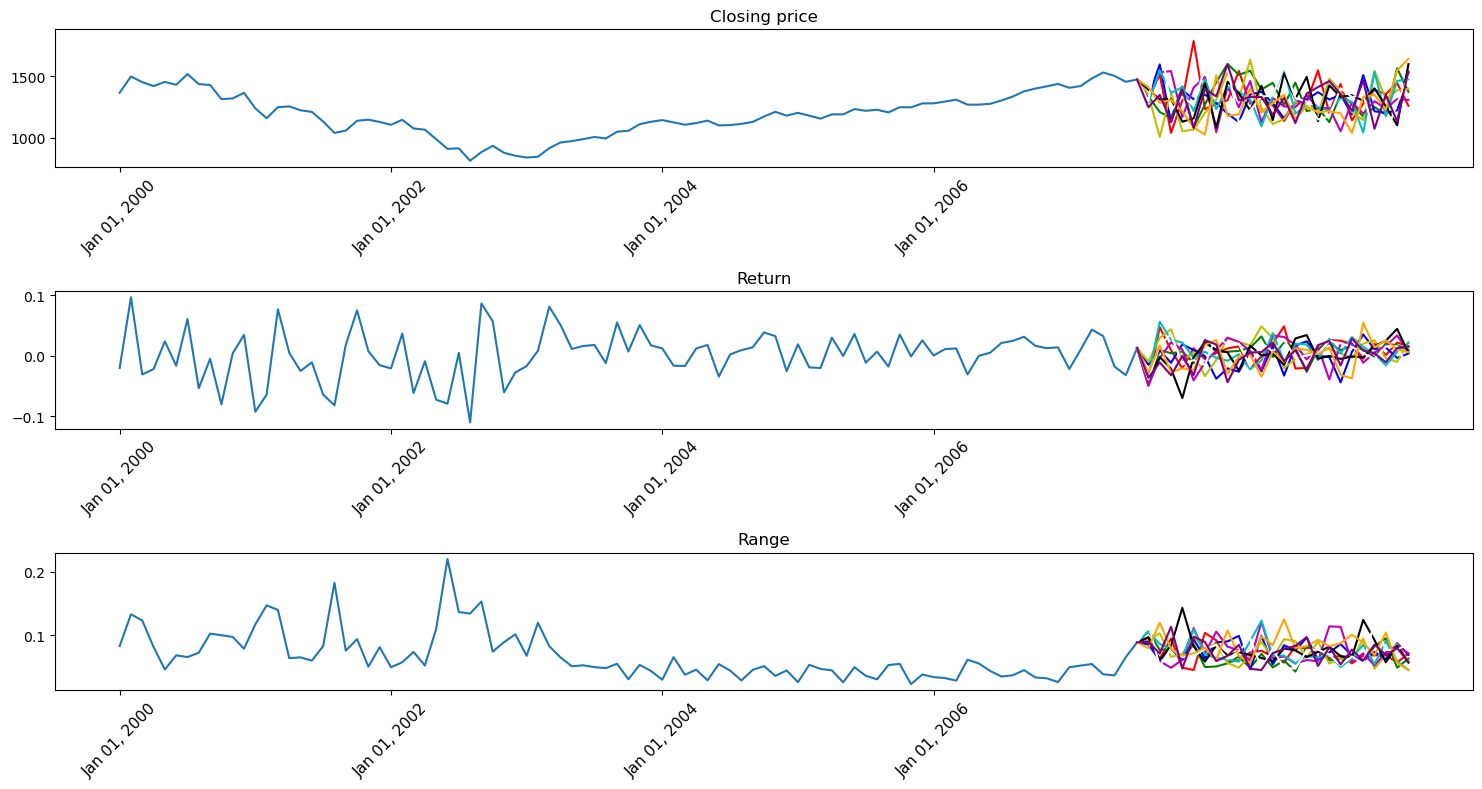

In [127]:
# Plot all the sampled sequences of hidden states
# Visualise the time series as 3 subplots with legend
colors = ['r', 'g', 'b', 'y', 'm', 'c', 'k', 'w', 'orange', 'purple']
fig, ax = plt.subplots(3, 1, figsize=(15, 8))
ax[0].plot(closing_price)
# at the end of the time series, we plot the sampled sequence of hidden states
for i in range(len(values_store)):
    ax[0].plot(range(len(closing_price)-1, len(closing_price)+len(sampled[0])), np.concatenate((closing_price[-1:], values_store[i][:,0])), c= colors[i])
ax[0].set_title('Closing price')
ax[1].plot(return_price)
for i in range(len(values_store)):
    ax[1].plot(range(len(return_price)-1, len(return_price)+len(sampled[0])), np.concatenate((return_price[-1:], values_store[i][:,1])), c=colors[i])
ax[1].set_title('Return')
ax[2].plot(range_price)
for i in range(len(values_store)):
    ax[2].plot(range(len(range_price)-1, len(range_price)+len(sampled[0])), np.concatenate((range_price[-1:], values_store[i][:,2])), c=colors[i])
ax[2].set_title('Range')

# Set the x-ticks
ax[0].set_xticks(range(0, len(x_ticks), 24))
ax[0].set_xticklabels(x_ticks[::24], rotation=45, fontsize=11)
ax[1].set_xticks(range(0, len(x_ticks), 24))
ax[1].set_xticklabels(x_ticks[::24], rotation=45, fontsize=11)
ax[2].set_xticks(range(0, len(x_ticks), 24))
ax[2].set_xticklabels(x_ticks[::24], rotation=45, fontsize=11)
# add space between subplots
plt.tight_layout()

plt.show()

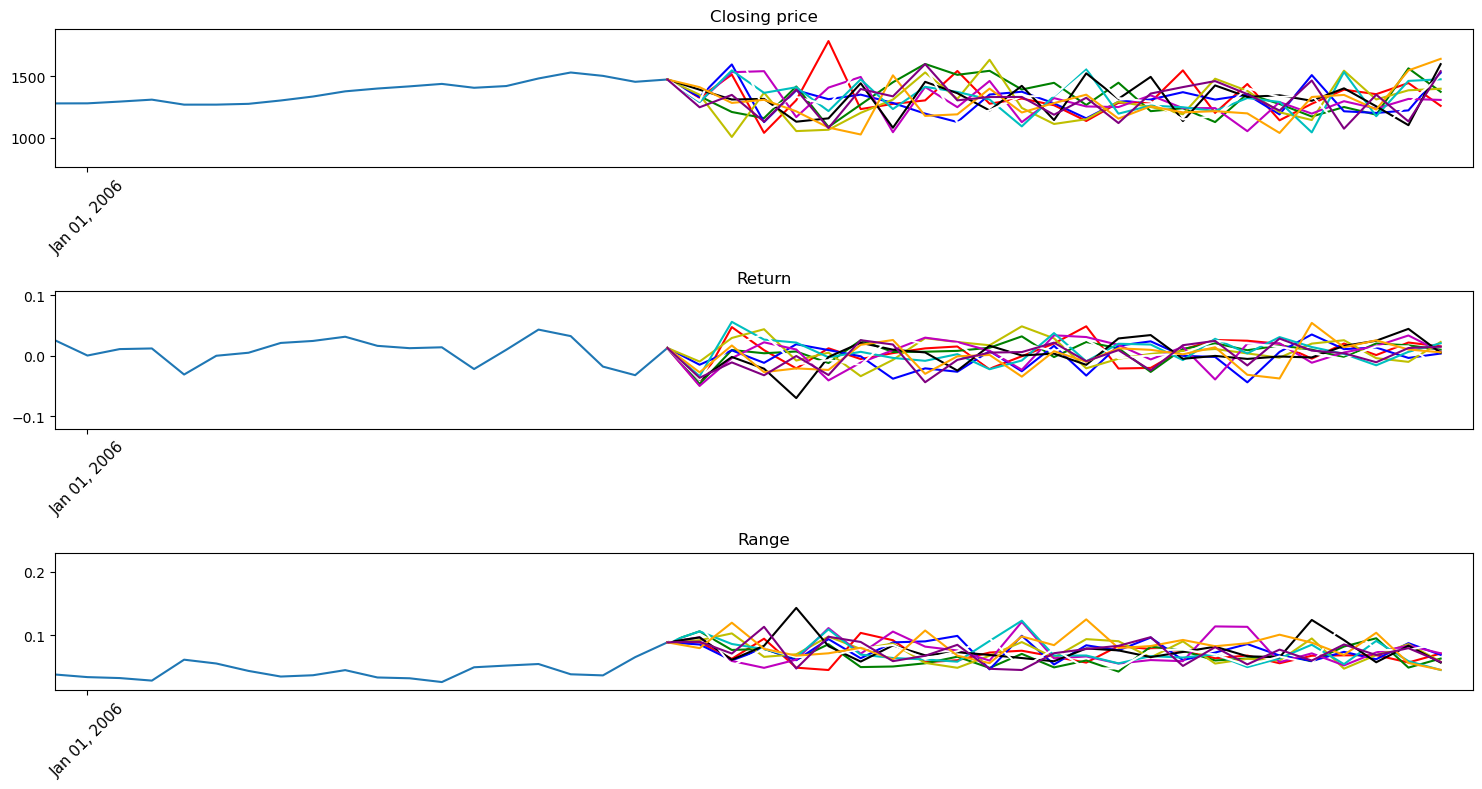

In [128]:
# Plot all the sampled sequences of hidden states
# Visualise the time series as 3 subplots with legend
colors = ['r', 'g', 'b', 'y', 'm', 'c', 'k', 'w', 'orange', 'purple']
fig, ax = plt.subplots(3, 1, figsize=(15, 8))
ax[0].plot(closing_price)
# at the end of the time series, we plot the sampled sequence of hidden states
for i in range(len(values_store)):
    ax[0].plot(range(len(closing_price)-1, len(closing_price)+len(sampled[0])), np.concatenate((closing_price[-1:], values_store[i][:,0])), c= colors[i])
ax[0].set_title('Closing price')
ax[1].plot(return_price)
for i in range(len(values_store)):
    ax[1].plot(range(len(return_price)-1, len(return_price)+len(sampled[0])), np.concatenate((return_price[-1:], values_store[i][:,1])), c=colors[i])
ax[1].set_title('Return')
ax[2].plot(range_price)
for i in range(len(values_store)):
    ax[2].plot(range(len(range_price)-1, len(range_price)+len(sampled[0])), np.concatenate((range_price[-1:], values_store[i][:,2])), c=colors[i])
ax[2].set_title('Range')

# Set the x-ticks
ax[0].set_xticks(range(0, len(x_ticks), 24))
ax[0].set_xticklabels(x_ticks[::24], rotation=45, fontsize=11)
ax[1].set_xticks(range(0, len(x_ticks), 24))
ax[1].set_xticklabels(x_ticks[::24], rotation=45, fontsize=11)
ax[2].set_xticks(range(0, len(x_ticks), 24))
ax[2].set_xticklabels(x_ticks[::24], rotation=45, fontsize=11)
# add space between subplots
plt.tight_layout()

# Zoom-in
ax[0].set_xlim([len(closing_price)-20, len(closing_price)+len(sampled[0])])
ax[1].set_xlim([len(return_price)-20, len(return_price)+len(sampled[0])])
ax[2].set_xlim([len(range_price)-20, len(range_price)+len(sampled[0])])

plt.show()

> We have plotted a zoomed version of our previous plot for better readability of the period of interest. We can observe that by visualising the 10 predictions, that these predictions are quite different and erratic. This is expected when using HMM models, as they are based on the Markov assumption. Indeed, the Markov assumption states that the future is independent of the past given the present. This assumption is not always true, especially in the case of financial data. Indeed, the financial crisis of 2007-2008 is a good example of this. The financial crisis of 2007-2008 was a severe worldwide financial crisis that began in 2007 and lasted until 2009. It was the most serious financial crisis since the Great Depression of the 1930s.

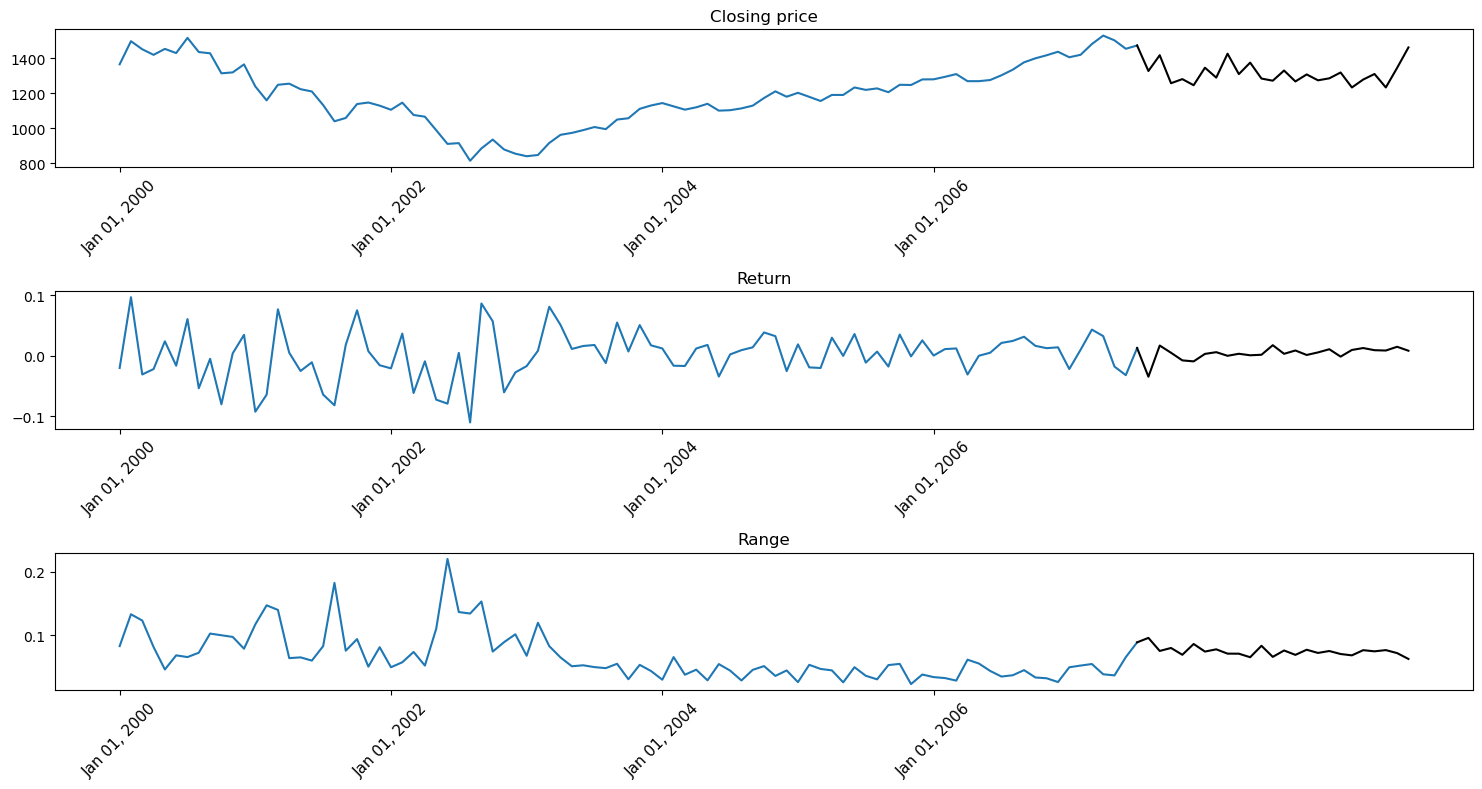

In [129]:
# Replot with the sampled sequence of hidden states
# Visualise the time series as 3 subplots with legend
fig, ax = plt.subplots(3, 1, figsize=(15, 8))
ax[0].plot(closing_price)
# at the end of the time series, we plot the sampled sequence of hidden states
ax[0].plot(range(len(closing_price)-1, len(closing_price)+len(sampled[0])), np.concatenate((closing_price[-1:], np.mean(values_store, axis=0)[:,0])), c='k')
ax[0].set_title('Closing price')
ax[1].plot(return_price)
ax[1].plot(range(len(return_price)-1, len(return_price)+len(sampled[0])), np.concatenate((return_price[-1:], np.mean(values_store, axis=0)[:,1])), c='k')
ax[1].set_title('Return')
ax[2].plot(range_price)
ax[2].plot(range(len(range_price)-1, len(range_price)+len(sampled[0])), np.concatenate((range_price[-1:], np.mean(values_store, axis=0)[:,2])), c='k')
ax[2].set_title('Range')

# Set the x-ticks
ax[0].set_xticks(range(0, len(x_ticks), 24))
ax[0].set_xticklabels(x_ticks[::24], rotation=45, fontsize=11)
ax[1].set_xticks(range(0, len(x_ticks), 24))
ax[1].set_xticklabels(x_ticks[::24], rotation=45, fontsize=11)
ax[2].set_xticks(range(0, len(x_ticks), 24))
ax[2].set_xticklabels(x_ticks[::24], rotation=45, fontsize=11)
# add space between subplots
plt.tight_layout()
plt.show()

In [130]:
# Reload the data
stock_df = pd.read_csv('stock.csv')
# Convert the date column to datetime format (Month day, year)
stock_df['Date_transformed'] = pd.to_datetime(stock_df['Date'], format='%b %d, %Y')
# Keep only the data before Aug 2007
stock_df = stock_df[stock_df['Date_transformed'] < '2009-08-01']

# Reversed 
stock_df = stock_df.iloc[::-1]
# Extract the closing price
closing_price_original = stock_df['Close*'].values

# Extract the return (percentage of the monthly change of closing price) 
return_price_original = (stock_df['Close*'].pct_change()).values
# Replace the first element with 0
return_price_original[0] = 0

# Extract the range (the relative difference between the monthly low and high prices)
range_price_original = ((stock_df['High'] - stock_df['Low']).values) / stock_df['High'].values

# Delete the first row
closing_price_original = np.delete(closing_price_original, 0)
return_price_original = np.delete(return_price_original, 0)
range_price_original = np.delete(range_price_original, 0)

# Extract the date
x_ticks = stock_df['Date'].values

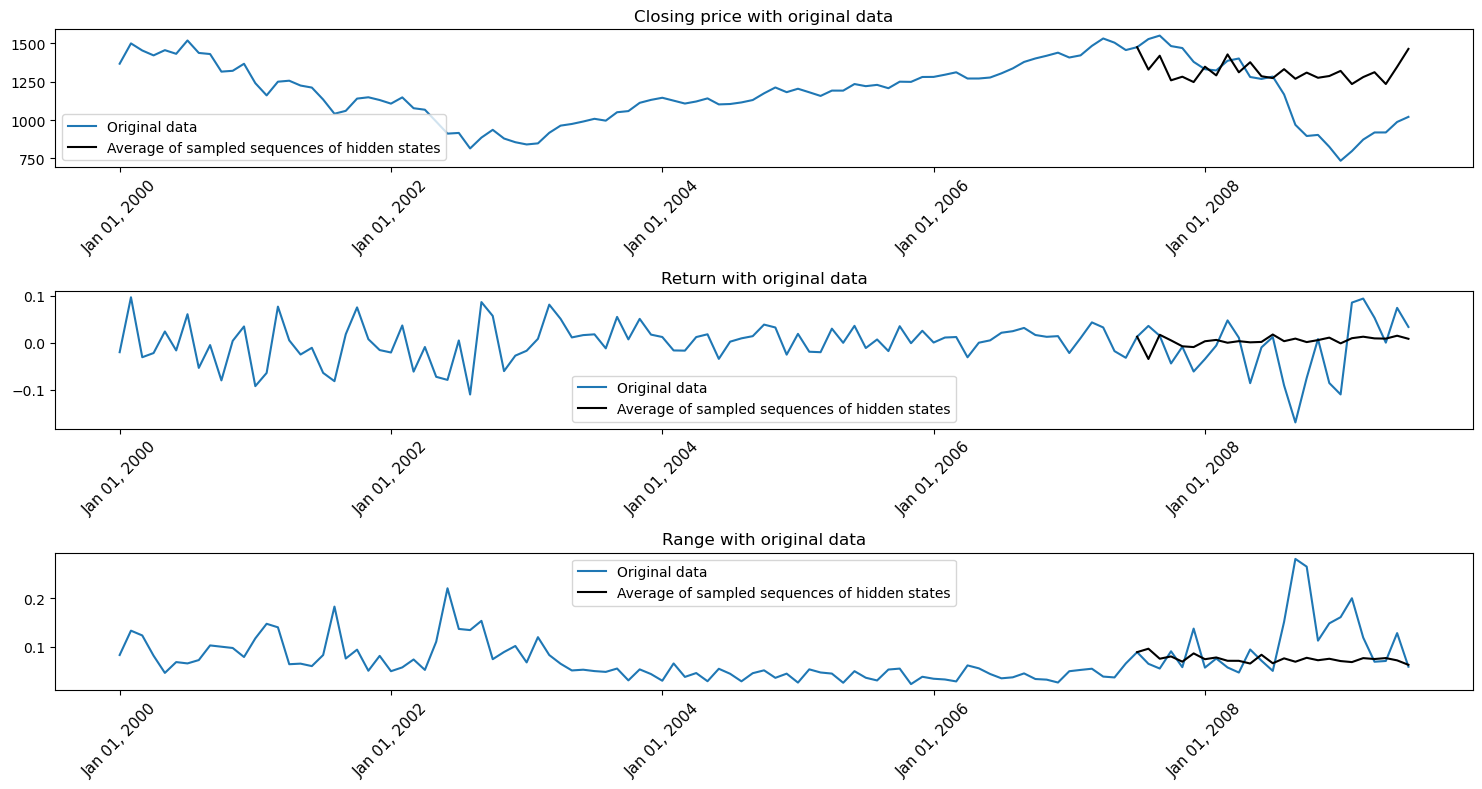

In [131]:
# Replot with the sampled sequence of hidden states
# Visualise the time series as 3 subplots with legend
fig, ax = plt.subplots(3, 1, figsize=(15, 8))
ax[0].plot(closing_price_original)
# at the end of the time series, we plot the sampled sequence of hidden states
ax[0].plot(range(len(closing_price)-1, len(closing_price)+len(sampled[0])), np.concatenate((closing_price[-1:], np.mean(values_store, axis=0)[:,0])), c='k')
ax[0].set_title('Closing price with original data')
ax[0].legend(['Original data', 'Average of sampled sequences of hidden states'])
ax[1].plot(return_price_original)
ax[1].plot(range(len(return_price)-1, len(return_price)+len(sampled[0])), np.concatenate((return_price[-1:], np.mean(values_store, axis=0)[:,1])), c='k')
ax[1].set_title('Return with original data')
ax[1].legend(['Original data', 'Average of sampled sequences of hidden states'])
ax[2].plot(range_price_original)
ax[2].plot(range(len(range_price)-1, len(range_price)+len(sampled[0])), np.concatenate((range_price[-1:], np.mean(values_store, axis=0)[:,2])), c='k')
ax[2].set_title('Range with original data')
ax[2].legend(['Original data', 'Average of sampled sequences of hidden states'])

# Set the x-ticks
ax[0].set_xticks(range(0, len(x_ticks), 24))
ax[0].set_xticklabels(x_ticks[::24], rotation=45, fontsize=11)
ax[1].set_xticks(range(0, len(x_ticks), 24))
ax[1].set_xticklabels(x_ticks[::24], rotation=45, fontsize=11)
ax[2].set_xticks(range(0, len(x_ticks), 24))
ax[2].set_xticklabels(x_ticks[::24], rotation=45, fontsize=11)
# add space between subplots
plt.tight_layout()
plt.show()

> By taking the average of the 10 sampled predictions, we notice that our mean prediction is quite stable. Moreover, it does not really reflect the reality and the financial crisis of 2007-2008.

We have been able to forecast the time series during the dip of the Global Financial Crisis (2007-2008). However, we notice that our model struggles to accurately predict the financial crisis and in the contrary, the closing prices remain quite stable. This is mainly due to the fact that our HMM model is based on the Markov assumption. Indeed, the Markov assumption states that the future is independent of the past given the present and this assumption is not always true, especially in the case of financial data. 

The fact that we average predictions play also an important role in making our accuracy "more stable". It has a smoothing effect on the predictions. Indeed, by averaging the predictions of the 5 models, we are able to reduce the variance of our predictions. This is why we notice that our mean prediction is quite stable.

Overall, we can conclude that our model is not very accurate in predicting the financial crisis in 2007-2008. It has a very limited predictive capacity in general and is not able to accurately predict the financial crisis. However, it is still interesting to see how the HMM model can be used to predict the future.